In [2]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [3]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 1")
    device_num = 3
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

num_folds = 15

num_classes = 3

max_epochs = 1000

net_dims = 3
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 2

num_slices = 48
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-3D-PR"

Device number assumed to be 1


In [4]:
if not os.path.exists(model_filename_base):
    os.mkdir(model_filename_base)

model_filename_base = model_filename_base+"/"

In [5]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Num images / labels = 62 62


In [6]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.nii.gz
../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.interpolated-overlay.nii.gz


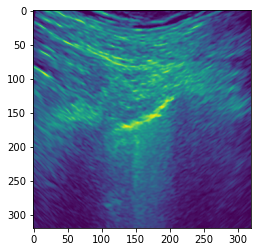

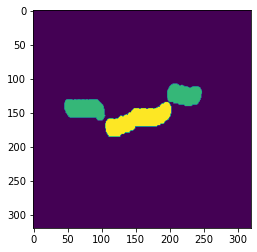

In [7]:
imgnum = 40 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['trilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image', 'label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            center_slice=30,
            axis=3,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [9]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00, 11.74it/s]


torch.Size([2, 1, 320, 320, 48])
torch.Size([1, 320, 320, 48])
image shape: torch.Size([1, 320, 320, 48]), label shape: torch.Size([1, 320, 320, 48])


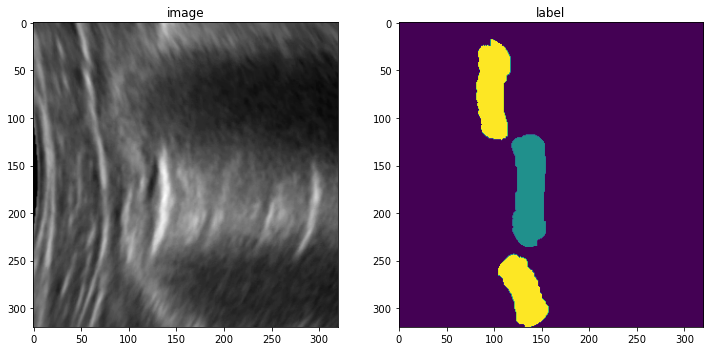

tensor(0.) tensor(2.)


In [10]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 24], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 24])
plt.show()
print(label.min(), label.max())

In [11]:
device = torch.device("cuda:"+str(device_num))


In [16]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2]+metric_values[-3])/3
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
for i in range(0,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/1000
1/1, train_loss: 0.8098
2/1, train_loss: 0.8019
3/1, train_loss: 0.8024
4/1, train_loss: 0.8037
5/1, train_loss: 0.7991
6/1, train_loss: 0.7905
7/1, train_loss: 0.7982
0 epoch 1 average loss: 0.8008
----------
0: epoch 2/1000
1/1, train_loss: 0.7862
2/1, train_loss: 0.7971
3/1, train_loss: 0.7951
4/1, train_loss: 0.7844
5/1, train_loss: 0.7846
6/1, train_loss: 0.7752
7/1, train_loss: 0.7877
0 epoch 2 average loss: 0.7872
current epoch: 2 current mean dice: 0.0749
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/1000
1/1, train_loss: 0.7800
2/1, train_loss: 0.7921
3/1, train_loss: 0.7830
4/1, train_loss: 0.7756
5/1, train_loss: 0.7797
6/1, train_loss: 0.7685
7/1, train_loss: 0.7679
0 epoch 3 average loss: 0.7781
----------
0: epoch 4/1000
1/1, train_loss: 0.7728
2/1, train_loss: 0.7708
3/1, train_loss: 0.7669
4/1, train_loss: 0.7773
5/1, train_loss: 0.7693
6/1, train_loss: 0.7664
7/1, train_loss: 0.7810
0 epoch 4 average loss: 0.7721
current epoch: 4

7/1, train_loss: 0.6591
0 epoch 31 average loss: 0.6297
----------
0: epoch 32/1000
1/1, train_loss: 0.6227
2/1, train_loss: 0.6162
3/1, train_loss: 0.6325
4/1, train_loss: 0.6139
5/1, train_loss: 0.6393
6/1, train_loss: 0.6059
7/1, train_loss: 0.6313
0 epoch 32 average loss: 0.6231
current epoch: 32 current mean dice: 0.2867
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 33/1000
1/1, train_loss: 0.6210
2/1, train_loss: 0.6277
3/1, train_loss: 0.6316
4/1, train_loss: 0.6033
5/1, train_loss: 0.6163
6/1, train_loss: 0.6040
7/1, train_loss: 0.6207
0 epoch 33 average loss: 0.6178
----------
0: epoch 34/1000
1/1, train_loss: 0.5770
2/1, train_loss: 0.6219
3/1, train_loss: 0.6290
4/1, train_loss: 0.6205
5/1, train_loss: 0.6154
6/1, train_loss: 0.6042
7/1, train_loss: 0.6430
0 epoch 34 average loss: 0.6159
current epoch: 34 current mean dice: 0.3679
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 35/1000
1/1, train_loss: 0.6167
2/1, train_loss: 0.6011
3/1, train_loss: 0.608

4/1, train_loss: 0.4863
5/1, train_loss: 0.4633
6/1, train_loss: 0.5147
7/1, train_loss: 0.5268
0 epoch 62 average loss: 0.4949
current epoch: 62 current mean dice: 0.4018
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 63/1000
1/1, train_loss: 0.4872
2/1, train_loss: 0.4880
3/1, train_loss: 0.5157
4/1, train_loss: 0.4566
5/1, train_loss: 0.4730
6/1, train_loss: 0.5026
7/1, train_loss: 0.4785
0 epoch 63 average loss: 0.4859
----------
0: epoch 64/1000
1/1, train_loss: 0.4848
2/1, train_loss: 0.4755
3/1, train_loss: 0.5050
4/1, train_loss: 0.4725
5/1, train_loss: 0.4852
6/1, train_loss: 0.4885
7/1, train_loss: 0.4944
0 epoch 64 average loss: 0.4866
current epoch: 64 current mean dice: 0.3694
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 65/1000
1/1, train_loss: 0.4765
2/1, train_loss: 0.4724
3/1, train_loss: 0.4959
4/1, train_loss: 0.4820
5/1, train_loss: 0.4694
6/1, train_loss: 0.4679
7/1, train_loss: 0.4993
0 epoch 65 average loss: 0.4805
----------
0: epoch 66/100

1/1, train_loss: 0.4150
2/1, train_loss: 0.4328
3/1, train_loss: 0.3729
4/1, train_loss: 0.3914
5/1, train_loss: 0.3764
6/1, train_loss: 0.3995
7/1, train_loss: 0.3692
0 epoch 93 average loss: 0.3939
----------
0: epoch 94/1000
1/1, train_loss: 0.3713
2/1, train_loss: 0.3921
3/1, train_loss: 0.3976
4/1, train_loss: 0.3710
5/1, train_loss: 0.3793
6/1, train_loss: 0.4052
7/1, train_loss: 0.4143
0 epoch 94 average loss: 0.3901
current epoch: 94 current mean dice: 0.4767
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 95/1000
1/1, train_loss: 0.3759
2/1, train_loss: 0.4224
3/1, train_loss: 0.4017
4/1, train_loss: 0.3683
5/1, train_loss: 0.3864
6/1, train_loss: 0.3753
7/1, train_loss: 0.4169
0 epoch 95 average loss: 0.3924
----------
0: epoch 96/1000
1/1, train_loss: 0.3751
2/1, train_loss: 0.4062
3/1, train_loss: 0.3778
4/1, train_loss: 0.3869
5/1, train_loss: 0.4002
6/1, train_loss: 0.4050
7/1, train_loss: 0.3735
0 epoch 96 average loss: 0.3892
current epoch: 96 current mean dice

1/1, train_loss: 0.3171
2/1, train_loss: 0.3195
3/1, train_loss: 0.3232
4/1, train_loss: 0.3279
5/1, train_loss: 0.3052
6/1, train_loss: 0.3410
7/1, train_loss: 0.3330
0 epoch 123 average loss: 0.3238
----------
0: epoch 124/1000
1/1, train_loss: 0.2941
2/1, train_loss: 0.3039
3/1, train_loss: 0.3241
4/1, train_loss: 0.2948
5/1, train_loss: 0.3234
6/1, train_loss: 0.3440
7/1, train_loss: 0.3253
0 epoch 124 average loss: 0.3157
current epoch: 124 current mean dice: 0.4701
best mean dice: 0.5287 at epoch: 110
----------
0: epoch 125/1000
1/1, train_loss: 0.3195
2/1, train_loss: 0.2905
3/1, train_loss: 0.3141
4/1, train_loss: 0.3298
5/1, train_loss: 0.3186
6/1, train_loss: 0.3629
7/1, train_loss: 0.3651
0 epoch 125 average loss: 0.3286
----------
0: epoch 126/1000
1/1, train_loss: 0.3235
2/1, train_loss: 0.3298
3/1, train_loss: 0.3276
4/1, train_loss: 0.2960
5/1, train_loss: 0.3230
6/1, train_loss: 0.3295
7/1, train_loss: 0.3497
0 epoch 126 average loss: 0.3256
current epoch: 126 current 

1/1, train_loss: 0.2451
2/1, train_loss: 0.2589
3/1, train_loss: 0.2561
4/1, train_loss: 0.2870
5/1, train_loss: 0.2989
6/1, train_loss: 0.2599
7/1, train_loss: 0.2389
0 epoch 153 average loss: 0.2635
----------
0: epoch 154/1000
1/1, train_loss: 0.2325
2/1, train_loss: 0.2752
3/1, train_loss: 0.2522
4/1, train_loss: 0.2636
5/1, train_loss: 0.2555
6/1, train_loss: 0.2985
7/1, train_loss: 0.2231
0 epoch 154 average loss: 0.2572
current epoch: 154 current mean dice: 0.5695
best mean dice: 0.5784 at epoch: 152
----------
0: epoch 155/1000
1/1, train_loss: 0.2752
2/1, train_loss: 0.2386
3/1, train_loss: 0.2621
4/1, train_loss: 0.2664
5/1, train_loss: 0.2735
6/1, train_loss: 0.2445
7/1, train_loss: 0.2665
0 epoch 155 average loss: 0.2610
----------
0: epoch 156/1000
1/1, train_loss: 0.2714
2/1, train_loss: 0.2553
3/1, train_loss: 0.2316
4/1, train_loss: 0.2502
5/1, train_loss: 0.2458
6/1, train_loss: 0.2791
7/1, train_loss: 0.2535
0 epoch 156 average loss: 0.2553
current epoch: 156 current 

current epoch: 182 current mean dice: 0.6140
best mean dice: 0.6316 at epoch: 172
----------
0: epoch 183/1000
1/1, train_loss: 0.1771
2/1, train_loss: 0.2214
3/1, train_loss: 0.1849
4/1, train_loss: 0.2183
5/1, train_loss: 0.2232
6/1, train_loss: 0.1978
7/1, train_loss: 0.2065
0 epoch 183 average loss: 0.2042
----------
0: epoch 184/1000
1/1, train_loss: 0.1826
2/1, train_loss: 0.1934
3/1, train_loss: 0.1978
4/1, train_loss: 0.2154
5/1, train_loss: 0.2409
6/1, train_loss: 0.1960
7/1, train_loss: 0.1906
0 epoch 184 average loss: 0.2024
current epoch: 184 current mean dice: 0.6173
best mean dice: 0.6316 at epoch: 172
----------
0: epoch 185/1000
1/1, train_loss: 0.2000
2/1, train_loss: 0.2062
3/1, train_loss: 0.1868
4/1, train_loss: 0.1924
5/1, train_loss: 0.1898
6/1, train_loss: 0.2292
7/1, train_loss: 0.1853
0 epoch 185 average loss: 0.1985
----------
0: epoch 186/1000
1/1, train_loss: 0.1827
2/1, train_loss: 0.1969
3/1, train_loss: 0.2105
4/1, train_loss: 0.1716
5/1, train_loss: 0.20

1/1, train_loss: 0.1762
2/1, train_loss: 0.1674
3/1, train_loss: 0.1631
4/1, train_loss: 0.1724
5/1, train_loss: 0.1714
6/1, train_loss: 0.1702
7/1, train_loss: 0.1548
0 epoch 213 average loss: 0.1679
----------
0: epoch 214/1000
1/1, train_loss: 0.1577
2/1, train_loss: 0.1571
3/1, train_loss: 0.1810
4/1, train_loss: 0.1643
5/1, train_loss: 0.1725
6/1, train_loss: 0.1640
7/1, train_loss: 0.1771
0 epoch 214 average loss: 0.1677
current epoch: 214 current mean dice: 0.6304
best mean dice: 0.6420 at epoch: 210
----------
0: epoch 215/1000
1/1, train_loss: 0.1648
2/1, train_loss: 0.1609
3/1, train_loss: 0.1701
4/1, train_loss: 0.1617
5/1, train_loss: 0.1585
6/1, train_loss: 0.1676
7/1, train_loss: 0.1787
0 epoch 215 average loss: 0.1660
----------
0: epoch 216/1000
1/1, train_loss: 0.1571
2/1, train_loss: 0.1521
3/1, train_loss: 0.1756
4/1, train_loss: 0.1590
5/1, train_loss: 0.1774
6/1, train_loss: 0.1612
7/1, train_loss: 0.1649
0 epoch 216 average loss: 0.1639
current epoch: 216 current 

4/1, train_loss: 0.1356
5/1, train_loss: 0.1592
6/1, train_loss: 0.1454
7/1, train_loss: 0.1419
0 epoch 243 average loss: 0.1462
----------
0: epoch 244/1000
1/1, train_loss: 0.1481
2/1, train_loss: 0.1372
3/1, train_loss: 0.1580
4/1, train_loss: 0.1667
5/1, train_loss: 0.1379
6/1, train_loss: 0.1362
7/1, train_loss: 0.1411
0 epoch 244 average loss: 0.1465
current epoch: 244 current mean dice: 0.6173
best mean dice: 0.6420 at epoch: 210
----------
0: epoch 245/1000
1/1, train_loss: 0.1423
2/1, train_loss: 0.1332
3/1, train_loss: 0.1444
4/1, train_loss: 0.1562
5/1, train_loss: 0.1479
6/1, train_loss: 0.1491
7/1, train_loss: 0.1503
0 epoch 245 average loss: 0.1462
----------
0: epoch 246/1000
1/1, train_loss: 0.1614
2/1, train_loss: 0.1464
3/1, train_loss: 0.1545
4/1, train_loss: 0.1334
5/1, train_loss: 0.1400
6/1, train_loss: 0.1606
7/1, train_loss: 0.1409
0 epoch 246 average loss: 0.1482
current epoch: 246 current mean dice: 0.6274
best mean dice: 0.6420 at epoch: 210
----------
0: epo

6/1, train_loss: 0.1310
7/1, train_loss: 0.1324
0 epoch 273 average loss: 0.1409
----------
0: epoch 274/1000
1/1, train_loss: 0.1418
2/1, train_loss: 0.1392
3/1, train_loss: 0.1558
4/1, train_loss: 0.1362
5/1, train_loss: 0.1272
6/1, train_loss: 0.1383
7/1, train_loss: 0.1243
0 epoch 274 average loss: 0.1375
current epoch: 274 current mean dice: 0.6224
best mean dice: 0.6422 at epoch: 270
----------
0: epoch 275/1000
1/1, train_loss: 0.1387
2/1, train_loss: 0.1385
3/1, train_loss: 0.1465
4/1, train_loss: 0.1447
5/1, train_loss: 0.1223
6/1, train_loss: 0.1376
7/1, train_loss: 0.1557
0 epoch 275 average loss: 0.1406
----------
0: epoch 276/1000
1/1, train_loss: 0.1269
2/1, train_loss: 0.1442
3/1, train_loss: 0.1469
4/1, train_loss: 0.1373
5/1, train_loss: 0.1303
6/1, train_loss: 0.1367
7/1, train_loss: 0.1366
0 epoch 276 average loss: 0.1370
current epoch: 276 current mean dice: 0.6303
best mean dice: 0.6422 at epoch: 270
----------
0: epoch 277/1000
1/1, train_loss: 0.1355
2/1, train_l

7/1, train_loss: 0.1326
0 epoch 303 average loss: 0.1319
----------
0: epoch 304/1000
1/1, train_loss: 0.1188
2/1, train_loss: 0.1361
3/1, train_loss: 0.1407
4/1, train_loss: 0.1421
5/1, train_loss: 0.1325
6/1, train_loss: 0.1301
7/1, train_loss: 0.1463
0 epoch 304 average loss: 0.1352
current epoch: 304 current mean dice: 0.6406
best mean dice: 0.6477 at epoch: 282
----------
0: epoch 305/1000
1/1, train_loss: 0.1335
2/1, train_loss: 0.1223
3/1, train_loss: 0.1355
4/1, train_loss: 0.1332
5/1, train_loss: 0.1411
6/1, train_loss: 0.1190
7/1, train_loss: 0.1320
0 epoch 305 average loss: 0.1309
----------
0: epoch 306/1000
1/1, train_loss: 0.1234
2/1, train_loss: 0.1296
3/1, train_loss: 0.1352
4/1, train_loss: 0.1285
5/1, train_loss: 0.1240
6/1, train_loss: 0.1261
7/1, train_loss: 0.1398
0 epoch 306 average loss: 0.1295
current epoch: 306 current mean dice: 0.6471
best mean dice: 0.6477 at epoch: 282
----------
0: epoch 307/1000
1/1, train_loss: 0.1191
2/1, train_loss: 0.1282
3/1, train_l

1/1, train_loss: 0.1162
2/1, train_loss: 0.1190
3/1, train_loss: 0.1251
4/1, train_loss: 0.1241
5/1, train_loss: 0.1280
6/1, train_loss: 0.1145
7/1, train_loss: 0.1201
0 epoch 334 average loss: 0.1210
current epoch: 334 current mean dice: 0.6342
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 335/1000
1/1, train_loss: 0.1244
2/1, train_loss: 0.1270
3/1, train_loss: 0.1110
4/1, train_loss: 0.1231
5/1, train_loss: 0.1254
6/1, train_loss: 0.1173
7/1, train_loss: 0.1227
0 epoch 335 average loss: 0.1216
----------
0: epoch 336/1000
1/1, train_loss: 0.1162
2/1, train_loss: 0.1179
3/1, train_loss: 0.1186
4/1, train_loss: 0.1141
5/1, train_loss: 0.1218
6/1, train_loss: 0.1354
7/1, train_loss: 0.1440
0 epoch 336 average loss: 0.1240
current epoch: 336 current mean dice: 0.6279
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 337/1000
1/1, train_loss: 0.1227
2/1, train_loss: 0.1388
3/1, train_loss: 0.1302
4/1, train_loss: 0.1195
5/1, train_loss: 0.1233
6/1, train_loss: 0.1113
7/

4/1, train_loss: 0.1229
5/1, train_loss: 0.1175
6/1, train_loss: 0.1260
7/1, train_loss: 0.1274
0 epoch 364 average loss: 0.1202
current epoch: 364 current mean dice: 0.6449
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 365/1000
1/1, train_loss: 0.1182
2/1, train_loss: 0.1153
3/1, train_loss: 0.1222
4/1, train_loss: 0.1291
5/1, train_loss: 0.1113
6/1, train_loss: 0.1245
7/1, train_loss: 0.1306
0 epoch 365 average loss: 0.1216
----------
0: epoch 366/1000
1/1, train_loss: 0.1110
2/1, train_loss: 0.1150
3/1, train_loss: 0.1248
4/1, train_loss: 0.1190
5/1, train_loss: 0.1238
6/1, train_loss: 0.1157
7/1, train_loss: 0.1330
0 epoch 366 average loss: 0.1203
current epoch: 366 current mean dice: 0.6337
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 367/1000
1/1, train_loss: 0.1113
2/1, train_loss: 0.1208
3/1, train_loss: 0.1209
4/1, train_loss: 0.1279
5/1, train_loss: 0.1319
6/1, train_loss: 0.1213
7/1, train_loss: 0.1120
0 epoch 367 average loss: 0.1209
----------
0: epo

7/1, train_loss: 0.1288
0 epoch 394 average loss: 0.1137
current epoch: 394 current mean dice: 0.6107
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 395/1000
1/1, train_loss: 0.1063
2/1, train_loss: 0.1171
3/1, train_loss: 0.1159
4/1, train_loss: 0.1125
5/1, train_loss: 0.1281
6/1, train_loss: 0.1105
7/1, train_loss: 0.1150
0 epoch 395 average loss: 0.1151
----------
0: epoch 396/1000
1/1, train_loss: 0.1252
2/1, train_loss: 0.1176
3/1, train_loss: 0.1238
4/1, train_loss: 0.1111
5/1, train_loss: 0.1095
6/1, train_loss: 0.1104
7/1, train_loss: 0.1052
0 epoch 396 average loss: 0.1147
current epoch: 396 current mean dice: 0.6087
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 397/1000
1/1, train_loss: 0.1142
2/1, train_loss: 0.0970
3/1, train_loss: 0.1172
4/1, train_loss: 0.1037
5/1, train_loss: 0.1090
6/1, train_loss: 0.1136
7/1, train_loss: 0.1232
0 epoch 397 average loss: 0.1111
----------
0: epoch 398/1000
1/1, train_loss: 0.1111
2/1, train_loss: 0.1109
3/1, train_l

1/1, train_loss: 0.1119
2/1, train_loss: 0.1067
3/1, train_loss: 0.1150
4/1, train_loss: 0.1076
5/1, train_loss: 0.1108
6/1, train_loss: 0.1137
7/1, train_loss: 0.1126
0 epoch 425 average loss: 0.1112
----------
0: epoch 426/1000
1/1, train_loss: 0.1118
2/1, train_loss: 0.1084
3/1, train_loss: 0.1083
4/1, train_loss: 0.1207
5/1, train_loss: 0.1151
6/1, train_loss: 0.1120
7/1, train_loss: 0.0994
0 epoch 426 average loss: 0.1108
current epoch: 426 current mean dice: 0.6091
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 427/1000
1/1, train_loss: 0.1083
2/1, train_loss: 0.1158
3/1, train_loss: 0.1008
4/1, train_loss: 0.1192
5/1, train_loss: 0.1176
6/1, train_loss: 0.1118
7/1, train_loss: 0.1016
0 epoch 427 average loss: 0.1107
----------
0: epoch 428/1000
1/1, train_loss: 0.1084
2/1, train_loss: 0.1064
3/1, train_loss: 0.1085
4/1, train_loss: 0.1206
5/1, train_loss: 0.1206
6/1, train_loss: 0.1112
7/1, train_loss: 0.0928
0 epoch 428 average loss: 0.1098
current epoch: 428 current 

4/1, train_loss: 0.1058
5/1, train_loss: 0.1066
6/1, train_loss: 0.1154
7/1, train_loss: 0.1168
0 epoch 455 average loss: 0.1125
----------
0: epoch 456/1000
1/1, train_loss: 0.1046
2/1, train_loss: 0.1087
3/1, train_loss: 0.1098
4/1, train_loss: 0.1165
5/1, train_loss: 0.1069
6/1, train_loss: 0.1192
7/1, train_loss: 0.0986
0 epoch 456 average loss: 0.1092
current epoch: 456 current mean dice: 0.6207
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 457/1000
1/1, train_loss: 0.1152
2/1, train_loss: 0.1037
3/1, train_loss: 0.1152
4/1, train_loss: 0.1061
5/1, train_loss: 0.1074
6/1, train_loss: 0.1104
7/1, train_loss: 0.0963
0 epoch 457 average loss: 0.1078
----------
0: epoch 458/1000
1/1, train_loss: 0.1074
2/1, train_loss: 0.1064
3/1, train_loss: 0.1096
4/1, train_loss: 0.1108
5/1, train_loss: 0.1011
6/1, train_loss: 0.1104
7/1, train_loss: 0.1015
0 epoch 458 average loss: 0.1067
current epoch: 458 current mean dice: 0.6182
best mean dice: 0.6511 at epoch: 308
----------
0: epo

7/1, train_loss: 0.1116
0 epoch 485 average loss: 0.1066
----------
0: epoch 486/1000
1/1, train_loss: 0.1067
2/1, train_loss: 0.1136
3/1, train_loss: 0.1128
4/1, train_loss: 0.1073
5/1, train_loss: 0.0990
6/1, train_loss: 0.1125
7/1, train_loss: 0.1014
0 epoch 486 average loss: 0.1076
current epoch: 486 current mean dice: 0.6112
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 487/1000
1/1, train_loss: 0.1094
2/1, train_loss: 0.0998
3/1, train_loss: 0.1046
4/1, train_loss: 0.1015
5/1, train_loss: 0.1143
6/1, train_loss: 0.1042
7/1, train_loss: 0.1203
0 epoch 487 average loss: 0.1077
----------
0: epoch 488/1000
1/1, train_loss: 0.1099
2/1, train_loss: 0.1106
3/1, train_loss: 0.1028
4/1, train_loss: 0.1028
5/1, train_loss: 0.1070
6/1, train_loss: 0.1012
7/1, train_loss: 0.1145
0 epoch 488 average loss: 0.1070
current epoch: 488 current mean dice: 0.6158
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 489/1000
1/1, train_loss: 0.0957
2/1, train_loss: 0.1117
3/1, train_l

1/1, train_loss: 0.1069
2/1, train_loss: 0.0965
3/1, train_loss: 0.0913
4/1, train_loss: 0.1119
5/1, train_loss: 0.1040
6/1, train_loss: 0.1028
7/1, train_loss: 0.0979
0 epoch 516 average loss: 0.1016
current epoch: 516 current mean dice: 0.6171
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 517/1000
1/1, train_loss: 0.1014
2/1, train_loss: 0.1110
3/1, train_loss: 0.1043
4/1, train_loss: 0.1088
5/1, train_loss: 0.0992
6/1, train_loss: 0.0962
7/1, train_loss: 0.0986
0 epoch 517 average loss: 0.1028
----------
0: epoch 518/1000
1/1, train_loss: 0.1118
2/1, train_loss: 0.1064
3/1, train_loss: 0.1099
4/1, train_loss: 0.1129
5/1, train_loss: 0.1024
6/1, train_loss: 0.0959
7/1, train_loss: 0.1136
0 epoch 518 average loss: 0.1075
current epoch: 518 current mean dice: 0.6254
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 519/1000
1/1, train_loss: 0.0977
2/1, train_loss: 0.1000
3/1, train_loss: 0.1098
4/1, train_loss: 0.1037
5/1, train_loss: 0.0986
6/1, train_loss: 0.1028
7/

4/1, train_loss: 0.0984
5/1, train_loss: 0.0952
6/1, train_loss: 0.1039
7/1, train_loss: 0.1125
0 epoch 546 average loss: 0.1014
current epoch: 546 current mean dice: 0.6191
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 547/1000
1/1, train_loss: 0.0954
2/1, train_loss: 0.1015
3/1, train_loss: 0.1072
4/1, train_loss: 0.1064
5/1, train_loss: 0.0990
6/1, train_loss: 0.1021
7/1, train_loss: 0.0926
0 epoch 547 average loss: 0.1006
----------
0: epoch 548/1000
1/1, train_loss: 0.1004
2/1, train_loss: 0.1075
3/1, train_loss: 0.1004
4/1, train_loss: 0.1003
5/1, train_loss: 0.1026
6/1, train_loss: 0.0971
7/1, train_loss: 0.1005
0 epoch 548 average loss: 0.1013
current epoch: 548 current mean dice: 0.6203
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 549/1000
1/1, train_loss: 0.1037
2/1, train_loss: 0.0948
3/1, train_loss: 0.1022
4/1, train_loss: 0.0903
5/1, train_loss: 0.0993
6/1, train_loss: 0.1076
7/1, train_loss: 0.1023
0 epoch 549 average loss: 0.1000
----------
0: epo

7/1, train_loss: 0.0975
0 epoch 576 average loss: 0.0951
current epoch: 576 current mean dice: 0.6308
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 577/1000
1/1, train_loss: 0.1030
2/1, train_loss: 0.0943
3/1, train_loss: 0.0984
4/1, train_loss: 0.0989
5/1, train_loss: 0.1074
6/1, train_loss: 0.0941
7/1, train_loss: 0.1033
0 epoch 577 average loss: 0.0999
----------
0: epoch 578/1000
1/1, train_loss: 0.0942
2/1, train_loss: 0.0926
3/1, train_loss: 0.0912
4/1, train_loss: 0.0998
5/1, train_loss: 0.0998
6/1, train_loss: 0.0993
7/1, train_loss: 0.0995
0 epoch 578 average loss: 0.0966
current epoch: 578 current mean dice: 0.6267
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 579/1000
1/1, train_loss: 0.1018
2/1, train_loss: 0.0951
3/1, train_loss: 0.0911
4/1, train_loss: 0.0981
5/1, train_loss: 0.0796
6/1, train_loss: 0.1027
7/1, train_loss: 0.1063
0 epoch 579 average loss: 0.0964
----------
0: epoch 580/1000
1/1, train_loss: 0.0962
2/1, train_loss: 0.0858
3/1, train_l

1/1, train_loss: 0.0932
2/1, train_loss: 0.0945
3/1, train_loss: 0.0969
4/1, train_loss: 0.0925
5/1, train_loss: 0.0976
6/1, train_loss: 0.1025
7/1, train_loss: 0.1021
0 epoch 607 average loss: 0.0971
----------
0: epoch 608/1000
1/1, train_loss: 0.1066
2/1, train_loss: 0.1085
3/1, train_loss: 0.0893
4/1, train_loss: 0.0916
5/1, train_loss: 0.1019
6/1, train_loss: 0.0880
7/1, train_loss: 0.0958
0 epoch 608 average loss: 0.0974
current epoch: 608 current mean dice: 0.6376
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 609/1000
1/1, train_loss: 0.0906
2/1, train_loss: 0.0980
3/1, train_loss: 0.0856
4/1, train_loss: 0.1047
5/1, train_loss: 0.1073
6/1, train_loss: 0.0960
7/1, train_loss: 0.1016
0 epoch 609 average loss: 0.0977
----------
0: epoch 610/1000
1/1, train_loss: 0.0881
2/1, train_loss: 0.0937
3/1, train_loss: 0.1035
4/1, train_loss: 0.0936
5/1, train_loss: 0.0926
6/1, train_loss: 0.0967
7/1, train_loss: 0.0922
0 epoch 610 average loss: 0.0943
current epoch: 610 current 

4/1, train_loss: 0.0926
5/1, train_loss: 0.0994
6/1, train_loss: 0.0876
7/1, train_loss: 0.0989
0 epoch 637 average loss: 0.0932
----------
0: epoch 638/1000
1/1, train_loss: 0.0832
2/1, train_loss: 0.0950
3/1, train_loss: 0.0885
4/1, train_loss: 0.1059
5/1, train_loss: 0.0934
6/1, train_loss: 0.1041
7/1, train_loss: 0.0953
0 epoch 638 average loss: 0.0951
current epoch: 638 current mean dice: 0.6214
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 639/1000
1/1, train_loss: 0.0861
2/1, train_loss: 0.1033
3/1, train_loss: 0.0942
4/1, train_loss: 0.0919
5/1, train_loss: 0.0908
6/1, train_loss: 0.0942
7/1, train_loss: 0.0993
0 epoch 639 average loss: 0.0942
----------
0: epoch 640/1000
1/1, train_loss: 0.0863
2/1, train_loss: 0.1026
3/1, train_loss: 0.0900
4/1, train_loss: 0.0990
5/1, train_loss: 0.0896
6/1, train_loss: 0.0909
7/1, train_loss: 0.0933
0 epoch 640 average loss: 0.0931
current epoch: 640 current mean dice: 0.6328
best mean dice: 0.6511 at epoch: 308
----------
0: epo

7/1, train_loss: 0.0938
0 epoch 667 average loss: 0.0929
----------
0: epoch 668/1000
1/1, train_loss: 0.0885
2/1, train_loss: 0.0967
3/1, train_loss: 0.0929
4/1, train_loss: 0.0935
5/1, train_loss: 0.0898
6/1, train_loss: 0.0857
7/1, train_loss: 0.0916
0 epoch 668 average loss: 0.0912
current epoch: 668 current mean dice: 0.6256
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 669/1000
1/1, train_loss: 0.0835
2/1, train_loss: 0.0931
3/1, train_loss: 0.0981
4/1, train_loss: 0.0957
5/1, train_loss: 0.0933
6/1, train_loss: 0.0899
7/1, train_loss: 0.1077
0 epoch 669 average loss: 0.0945
----------
0: epoch 670/1000
1/1, train_loss: 0.1037
2/1, train_loss: 0.0852
3/1, train_loss: 0.0967
4/1, train_loss: 0.0994
5/1, train_loss: 0.1015
6/1, train_loss: 0.0892
7/1, train_loss: 0.0979
0 epoch 670 average loss: 0.0962
current epoch: 670 current mean dice: 0.6227
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 671/1000
1/1, train_loss: 0.0903
2/1, train_loss: 0.0913
3/1, train_l

1/1, train_loss: 0.0860
2/1, train_loss: 0.1005
3/1, train_loss: 0.0850
4/1, train_loss: 0.0877
5/1, train_loss: 0.0846
6/1, train_loss: 0.1014
7/1, train_loss: 0.1018
0 epoch 698 average loss: 0.0924
current epoch: 698 current mean dice: 0.6400
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 699/1000
1/1, train_loss: 0.0863
2/1, train_loss: 0.0899
3/1, train_loss: 0.0975
4/1, train_loss: 0.0851
5/1, train_loss: 0.0910
6/1, train_loss: 0.0914
7/1, train_loss: 0.0818
0 epoch 699 average loss: 0.0890
----------
0: epoch 700/1000
1/1, train_loss: 0.0919
2/1, train_loss: 0.0934
3/1, train_loss: 0.0917
4/1, train_loss: 0.0823
5/1, train_loss: 0.0885
6/1, train_loss: 0.0861
7/1, train_loss: 0.0985
0 epoch 700 average loss: 0.0903
current epoch: 700 current mean dice: 0.6433
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 701/1000
1/1, train_loss: 0.0947
2/1, train_loss: 0.0984
3/1, train_loss: 0.0853
4/1, train_loss: 0.0885
5/1, train_loss: 0.0900
6/1, train_loss: 0.0896
7/

4/1, train_loss: 0.0950
5/1, train_loss: 0.0940
6/1, train_loss: 0.0833
7/1, train_loss: 0.0984
0 epoch 728 average loss: 0.0922
current epoch: 728 current mean dice: 0.6282
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 729/1000
1/1, train_loss: 0.0885
2/1, train_loss: 0.0925
3/1, train_loss: 0.0805
4/1, train_loss: 0.1002
5/1, train_loss: 0.0815
6/1, train_loss: 0.0862
7/1, train_loss: 0.0921
0 epoch 729 average loss: 0.0888
----------
0: epoch 730/1000
1/1, train_loss: 0.0874
2/1, train_loss: 0.0869
3/1, train_loss: 0.0807
4/1, train_loss: 0.0887
5/1, train_loss: 0.0931
6/1, train_loss: 0.0824
7/1, train_loss: 0.0900
0 epoch 730 average loss: 0.0870
current epoch: 730 current mean dice: 0.6349
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 731/1000
1/1, train_loss: 0.0889
2/1, train_loss: 0.0818
3/1, train_loss: 0.0811
4/1, train_loss: 0.0887
5/1, train_loss: 0.0824
6/1, train_loss: 0.0955
7/1, train_loss: 0.0926
0 epoch 731 average loss: 0.0873
----------
0: epo

7/1, train_loss: 0.0971
0 epoch 758 average loss: 0.0898
current epoch: 758 current mean dice: 0.6385
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 759/1000
1/1, train_loss: 0.0900
2/1, train_loss: 0.0791
3/1, train_loss: 0.0896
4/1, train_loss: 0.0897
5/1, train_loss: 0.0781
6/1, train_loss: 0.0867
7/1, train_loss: 0.0850
0 epoch 759 average loss: 0.0854
----------
0: epoch 760/1000
1/1, train_loss: 0.0891
2/1, train_loss: 0.0771
3/1, train_loss: 0.0909
4/1, train_loss: 0.0899
5/1, train_loss: 0.0797
6/1, train_loss: 0.0968
7/1, train_loss: 0.0888
0 epoch 760 average loss: 0.0875
current epoch: 760 current mean dice: 0.6370
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 761/1000
1/1, train_loss: 0.0878
2/1, train_loss: 0.0889
3/1, train_loss: 0.0901
4/1, train_loss: 0.0880
5/1, train_loss: 0.0864
6/1, train_loss: 0.0841
7/1, train_loss: 0.0858
0 epoch 761 average loss: 0.0873
----------
0: epoch 762/1000
1/1, train_loss: 0.0902
2/1, train_loss: 0.0881
3/1, train_l

1/1, train_loss: 0.0913
2/1, train_loss: 0.0853
3/1, train_loss: 0.0877
4/1, train_loss: 0.0739
5/1, train_loss: 0.0890
6/1, train_loss: 0.0837
7/1, train_loss: 0.0986
0 epoch 789 average loss: 0.0871
----------
0: epoch 790/1000
1/1, train_loss: 0.0779
2/1, train_loss: 0.0789
3/1, train_loss: 0.0833
4/1, train_loss: 0.0933
5/1, train_loss: 0.0848
6/1, train_loss: 0.1005
7/1, train_loss: 0.0953
0 epoch 790 average loss: 0.0877
current epoch: 790 current mean dice: 0.6363
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 791/1000
1/1, train_loss: 0.0903
2/1, train_loss: 0.0924
3/1, train_loss: 0.0805
4/1, train_loss: 0.0877
5/1, train_loss: 0.0839
6/1, train_loss: 0.0804
7/1, train_loss: 0.0850
0 epoch 791 average loss: 0.0857
----------
0: epoch 792/1000
1/1, train_loss: 0.0857
2/1, train_loss: 0.0866
3/1, train_loss: 0.0826
4/1, train_loss: 0.0950
5/1, train_loss: 0.0908
6/1, train_loss: 0.0917
7/1, train_loss: 0.0850
0 epoch 792 average loss: 0.0882
current epoch: 792 current 

4/1, train_loss: 0.0840
5/1, train_loss: 0.0895
6/1, train_loss: 0.0827
7/1, train_loss: 0.0852
0 epoch 819 average loss: 0.0843
----------
0: epoch 820/1000
1/1, train_loss: 0.0906
2/1, train_loss: 0.0850
3/1, train_loss: 0.0829
4/1, train_loss: 0.0755
5/1, train_loss: 0.0952
6/1, train_loss: 0.0857
7/1, train_loss: 0.1002
0 epoch 820 average loss: 0.0879
current epoch: 820 current mean dice: 0.6406
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 821/1000
1/1, train_loss: 0.0835
2/1, train_loss: 0.0962
3/1, train_loss: 0.0886
4/1, train_loss: 0.0820
5/1, train_loss: 0.0935
6/1, train_loss: 0.0851
7/1, train_loss: 0.0889
0 epoch 821 average loss: 0.0883
----------
0: epoch 822/1000
1/1, train_loss: 0.0853
2/1, train_loss: 0.0808
3/1, train_loss: 0.0843
4/1, train_loss: 0.0860
5/1, train_loss: 0.0834
6/1, train_loss: 0.0830
7/1, train_loss: 0.0876
0 epoch 822 average loss: 0.0843
current epoch: 822 current mean dice: 0.6314
best mean dice: 0.6511 at epoch: 308
----------
0: epo

7/1, train_loss: 0.0921
0 epoch 849 average loss: 0.0850
----------
0: epoch 850/1000
1/1, train_loss: 0.0778
2/1, train_loss: 0.0738
3/1, train_loss: 0.0855
4/1, train_loss: 0.0766
5/1, train_loss: 0.0805
6/1, train_loss: 0.0935
7/1, train_loss: 0.0946
0 epoch 850 average loss: 0.0832
current epoch: 850 current mean dice: 0.6393
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 851/1000
1/1, train_loss: 0.0812
2/1, train_loss: 0.0828
3/1, train_loss: 0.0907
4/1, train_loss: 0.0884
5/1, train_loss: 0.0895
6/1, train_loss: 0.0808
7/1, train_loss: 0.0810
0 epoch 851 average loss: 0.0849
----------
0: epoch 852/1000
1/1, train_loss: 0.0913
2/1, train_loss: 0.0766
3/1, train_loss: 0.0846
4/1, train_loss: 0.0891
5/1, train_loss: 0.0832
6/1, train_loss: 0.0889
7/1, train_loss: 0.0892
0 epoch 852 average loss: 0.0861
current epoch: 852 current mean dice: 0.6411
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 853/1000
1/1, train_loss: 0.0860
2/1, train_loss: 0.0833
3/1, train_l

1/1, train_loss: 0.0784
2/1, train_loss: 0.0846
3/1, train_loss: 0.0894
4/1, train_loss: 0.0856
5/1, train_loss: 0.0757
6/1, train_loss: 0.0792
7/1, train_loss: 0.0859
0 epoch 880 average loss: 0.0827
current epoch: 880 current mean dice: 0.6298
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 881/1000
1/1, train_loss: 0.0844
2/1, train_loss: 0.0822
3/1, train_loss: 0.0806
4/1, train_loss: 0.0834
5/1, train_loss: 0.0787
6/1, train_loss: 0.0786
7/1, train_loss: 0.0858
0 epoch 881 average loss: 0.0819
----------
0: epoch 882/1000
1/1, train_loss: 0.0849
2/1, train_loss: 0.0852
3/1, train_loss: 0.0813
4/1, train_loss: 0.0749
5/1, train_loss: 0.0854
6/1, train_loss: 0.0911
7/1, train_loss: 0.0783
0 epoch 882 average loss: 0.0830
current epoch: 882 current mean dice: 0.6304
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 883/1000
1/1, train_loss: 0.0852
2/1, train_loss: 0.0877
3/1, train_loss: 0.0787
4/1, train_loss: 0.0773
5/1, train_loss: 0.0738
6/1, train_loss: 0.0883
7/

4/1, train_loss: 0.0940
5/1, train_loss: 0.0829
6/1, train_loss: 0.0910
7/1, train_loss: 0.0818
0 epoch 910 average loss: 0.0844
current epoch: 910 current mean dice: 0.6346
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 911/1000
1/1, train_loss: 0.0855
2/1, train_loss: 0.0769
3/1, train_loss: 0.0837
4/1, train_loss: 0.0849
5/1, train_loss: 0.0772
6/1, train_loss: 0.0884
7/1, train_loss: 0.0865
0 epoch 911 average loss: 0.0833
----------
0: epoch 912/1000
1/1, train_loss: 0.0834
2/1, train_loss: 0.0891
3/1, train_loss: 0.0745
4/1, train_loss: 0.0851
5/1, train_loss: 0.0782
6/1, train_loss: 0.0864
7/1, train_loss: 0.0878
0 epoch 912 average loss: 0.0835
current epoch: 912 current mean dice: 0.6304
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 913/1000
1/1, train_loss: 0.0840
2/1, train_loss: 0.0923
3/1, train_loss: 0.0822
4/1, train_loss: 0.0841
5/1, train_loss: 0.0740
6/1, train_loss: 0.0771
7/1, train_loss: 0.0791
0 epoch 913 average loss: 0.0818
----------
0: epo

7/1, train_loss: 0.0764
0 epoch 940 average loss: 0.0790
current epoch: 940 current mean dice: 0.6341
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 941/1000
1/1, train_loss: 0.0806
2/1, train_loss: 0.0831
3/1, train_loss: 0.0778
4/1, train_loss: 0.0875
5/1, train_loss: 0.0700
6/1, train_loss: 0.0848
7/1, train_loss: 0.0825
0 epoch 941 average loss: 0.0809
----------
0: epoch 942/1000
1/1, train_loss: 0.0880
2/1, train_loss: 0.0757
3/1, train_loss: 0.0819
4/1, train_loss: 0.0759
5/1, train_loss: 0.0788
6/1, train_loss: 0.0745
7/1, train_loss: 0.0761
0 epoch 942 average loss: 0.0787
current epoch: 942 current mean dice: 0.6309
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 943/1000
1/1, train_loss: 0.0731
2/1, train_loss: 0.0736
3/1, train_loss: 0.0835
4/1, train_loss: 0.0860
5/1, train_loss: 0.0743
6/1, train_loss: 0.0768
7/1, train_loss: 0.0860
0 epoch 943 average loss: 0.0790
----------
0: epoch 944/1000
1/1, train_loss: 0.0834
2/1, train_loss: 0.0779
3/1, train_l

1/1, train_loss: 0.0779
2/1, train_loss: 0.0803
3/1, train_loss: 0.0760
4/1, train_loss: 0.0815
5/1, train_loss: 0.0824
6/1, train_loss: 0.0667
7/1, train_loss: 0.1014
0 epoch 971 average loss: 0.0809
----------
0: epoch 972/1000
1/1, train_loss: 0.0787
2/1, train_loss: 0.0657
3/1, train_loss: 0.0820
4/1, train_loss: 0.0760
5/1, train_loss: 0.0859
6/1, train_loss: 0.0792
7/1, train_loss: 0.0979
0 epoch 972 average loss: 0.0808
current epoch: 972 current mean dice: 0.6368
best mean dice: 0.6511 at epoch: 308
----------
0: epoch 973/1000
1/1, train_loss: 0.0754
2/1, train_loss: 0.0834
3/1, train_loss: 0.0815
4/1, train_loss: 0.0773
5/1, train_loss: 0.0843
6/1, train_loss: 0.0786
7/1, train_loss: 0.0664
0 epoch 973 average loss: 0.0781
----------
0: epoch 974/1000
1/1, train_loss: 0.0829
2/1, train_loss: 0.0829
3/1, train_loss: 0.0776
4/1, train_loss: 0.0741
5/1, train_loss: 0.0833
6/1, train_loss: 0.0767
7/1, train_loss: 0.0766
0 epoch 974 average loss: 0.0792
current epoch: 974 current 

4/1, train_loss: 0.7801
5/1, train_loss: 0.7769
6/1, train_loss: 0.7789
7/1, train_loss: 0.7811
1 epoch 1 average loss: 0.7788
----------
1: epoch 2/1000
1/1, train_loss: 0.7721
2/1, train_loss: 0.7670
3/1, train_loss: 0.7708
4/1, train_loss: 0.7744
5/1, train_loss: 0.7698
6/1, train_loss: 0.7679
7/1, train_loss: 0.7630
1 epoch 2 average loss: 0.7693
current epoch: 2 current mean dice: 0.0540
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 3/1000
1/1, train_loss: 0.7665
2/1, train_loss: 0.7651
3/1, train_loss: 0.7572
4/1, train_loss: 0.7560
5/1, train_loss: 0.7611
6/1, train_loss: 0.7539
7/1, train_loss: 0.7648
1 epoch 3 average loss: 0.7607
----------
1: epoch 4/1000
1/1, train_loss: 0.7558
2/1, train_loss: 0.7489
3/1, train_loss: 0.7500
4/1, train_loss: 0.7514
5/1, train_loss: 0.7499
6/1, train_loss: 0.7487
7/1, train_loss: 0.7586
1 epoch 4 average loss: 0.7519
current epoch: 4 current mean dice: 0.0522
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 5/1000
1/1, tra

2/1, train_loss: 0.5973
3/1, train_loss: 0.5956
4/1, train_loss: 0.5807
5/1, train_loss: 0.5836
6/1, train_loss: 0.5788
7/1, train_loss: 0.5764
1 epoch 32 average loss: 0.5849
current epoch: 32 current mean dice: 0.2441
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 33/1000
1/1, train_loss: 0.5648
2/1, train_loss: 0.5918
3/1, train_loss: 0.5981
4/1, train_loss: 0.5776
5/1, train_loss: 0.5927
6/1, train_loss: 0.5772
7/1, train_loss: 0.5588
1 epoch 33 average loss: 0.5801
----------
1: epoch 34/1000
1/1, train_loss: 0.5588
2/1, train_loss: 0.5699
3/1, train_loss: 0.5742
4/1, train_loss: 0.5799
5/1, train_loss: 0.5998
6/1, train_loss: 0.5815
7/1, train_loss: 0.5900
1 epoch 34 average loss: 0.5791
current epoch: 34 current mean dice: 0.3524
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 35/1000
1/1, train_loss: 0.5796
2/1, train_loss: 0.5758
3/1, train_loss: 0.5778
4/1, train_loss: 0.5691
5/1, train_loss: 0.5580
6/1, train_loss: 0.5689
7/1, train_loss: 0.6065
1 epoch 35

1 epoch 62 average loss: 0.3846
current epoch: 62 current mean dice: 0.4529
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 63/1000
1/1, train_loss: 0.3407
2/1, train_loss: 0.3915
3/1, train_loss: 0.3679
4/1, train_loss: 0.4001
5/1, train_loss: 0.3930
6/1, train_loss: 0.3795
7/1, train_loss: 0.3445
1 epoch 63 average loss: 0.3739
----------
1: epoch 64/1000
1/1, train_loss: 0.3723
2/1, train_loss: 0.3497
3/1, train_loss: 0.3621
4/1, train_loss: 0.3794
5/1, train_loss: 0.3618
6/1, train_loss: 0.3795
7/1, train_loss: 0.3690
1 epoch 64 average loss: 0.3677
current epoch: 64 current mean dice: 0.3859
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 65/1000
1/1, train_loss: 0.3519
2/1, train_loss: 0.3443
3/1, train_loss: 0.3700
4/1, train_loss: 0.3588
5/1, train_loss: 0.3697
6/1, train_loss: 0.3609
7/1, train_loss: 0.3498
1 epoch 65 average loss: 0.3579
----------
1: epoch 66/1000
1/1, train_loss: 0.3955
2/1, train_loss: 0.3397
3/1, train_loss: 0.3554
4/1, train_loss: 0.333

1/1, train_loss: 0.2369
2/1, train_loss: 0.2258
3/1, train_loss: 0.2379
4/1, train_loss: 0.2314
5/1, train_loss: 0.2126
6/1, train_loss: 0.2148
7/1, train_loss: 0.2161
1 epoch 93 average loss: 0.2250
----------
1: epoch 94/1000
1/1, train_loss: 0.2120
2/1, train_loss: 0.2256
3/1, train_loss: 0.2169
4/1, train_loss: 0.2222
5/1, train_loss: 0.2223
6/1, train_loss: 0.2547
7/1, train_loss: 0.2244
1 epoch 94 average loss: 0.2254
current epoch: 94 current mean dice: 0.4722
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 95/1000
1/1, train_loss: 0.2129
2/1, train_loss: 0.2264
3/1, train_loss: 0.2133
4/1, train_loss: 0.2327
5/1, train_loss: 0.2151
6/1, train_loss: 0.2665
7/1, train_loss: 0.2258
1 epoch 95 average loss: 0.2275
----------
1: epoch 96/1000
1/1, train_loss: 0.2252
2/1, train_loss: 0.2384
3/1, train_loss: 0.2199
4/1, train_loss: 0.2232
5/1, train_loss: 0.2308
6/1, train_loss: 0.2249
7/1, train_loss: 0.2065
1 epoch 96 average loss: 0.2241
current epoch: 96 current mean dice

2/1, train_loss: 0.1615
3/1, train_loss: 0.1723
4/1, train_loss: 0.1815
5/1, train_loss: 0.1734
6/1, train_loss: 0.1864
7/1, train_loss: 0.1849
1 epoch 123 average loss: 0.1768
----------
1: epoch 124/1000
1/1, train_loss: 0.1901
2/1, train_loss: 0.1798
3/1, train_loss: 0.1836
4/1, train_loss: 0.1623
5/1, train_loss: 0.1801
6/1, train_loss: 0.1848
7/1, train_loss: 0.1671
1 epoch 124 average loss: 0.1783
current epoch: 124 current mean dice: 0.3990
best mean dice: 0.4341 at epoch: 114
----------
1: epoch 125/1000
1/1, train_loss: 0.1704
2/1, train_loss: 0.1682
3/1, train_loss: 0.1946
4/1, train_loss: 0.1685
5/1, train_loss: 0.1792
6/1, train_loss: 0.1883
7/1, train_loss: 0.1686
1 epoch 125 average loss: 0.1769
----------
1: epoch 126/1000
1/1, train_loss: 0.1905
2/1, train_loss: 0.1664
3/1, train_loss: 0.1709
4/1, train_loss: 0.1802
5/1, train_loss: 0.1673
6/1, train_loss: 0.1765
7/1, train_loss: 0.1580
1 epoch 126 average loss: 0.1728
current epoch: 126 current mean dice: 0.3926
best m

5/1, train_loss: 0.1555
6/1, train_loss: 0.1552
7/1, train_loss: 0.1595
1 epoch 153 average loss: 0.1562
----------
1: epoch 154/1000
1/1, train_loss: 0.1713
2/1, train_loss: 0.1369
3/1, train_loss: 0.1452
4/1, train_loss: 0.1646
5/1, train_loss: 0.1618
6/1, train_loss: 0.1446
7/1, train_loss: 0.1611
1 epoch 154 average loss: 0.1551
current epoch: 154 current mean dice: 0.3894
best mean dice: 0.4341 at epoch: 114
----------
1: epoch 155/1000
1/1, train_loss: 0.1536
2/1, train_loss: 0.1484
3/1, train_loss: 0.1542
4/1, train_loss: 0.1722
5/1, train_loss: 0.1511
6/1, train_loss: 0.1754
7/1, train_loss: 0.1557
1 epoch 155 average loss: 0.1587
----------
1: epoch 156/1000
1/1, train_loss: 0.1585
2/1, train_loss: 0.1605
3/1, train_loss: 0.1523
4/1, train_loss: 0.1392
5/1, train_loss: 0.1569
6/1, train_loss: 0.1682
7/1, train_loss: 0.1806
1 epoch 156 average loss: 0.1595
current epoch: 156 current mean dice: 0.3960
best mean dice: 0.4341 at epoch: 114
----------
1: epoch 157/1000
1/1, train_l

7/1, train_loss: 0.1564
1 epoch 183 average loss: 0.1403
----------
1: epoch 184/1000
1/1, train_loss: 0.1362
2/1, train_loss: 0.1485
3/1, train_loss: 0.1392
4/1, train_loss: 0.1356
5/1, train_loss: 0.1453
6/1, train_loss: 0.1356
7/1, train_loss: 0.1324
1 epoch 184 average loss: 0.1390
current epoch: 184 current mean dice: 0.4060
best mean dice: 0.4425 at epoch: 162
----------
1: epoch 185/1000
1/1, train_loss: 0.1362
2/1, train_loss: 0.1581
3/1, train_loss: 0.1351
4/1, train_loss: 0.1363
5/1, train_loss: 0.1436
6/1, train_loss: 0.1452
7/1, train_loss: 0.1410
1 epoch 185 average loss: 0.1422
----------
1: epoch 186/1000
1/1, train_loss: 0.1542
2/1, train_loss: 0.1441
3/1, train_loss: 0.1641
4/1, train_loss: 0.1365
5/1, train_loss: 0.1351
6/1, train_loss: 0.1376
7/1, train_loss: 0.1323
1 epoch 186 average loss: 0.1434
current epoch: 186 current mean dice: 0.4142
best mean dice: 0.4425 at epoch: 162
----------
1: epoch 187/1000
1/1, train_loss: 0.1418
2/1, train_loss: 0.1345
3/1, train_l

1/1, train_loss: 0.1301
2/1, train_loss: 0.1415
3/1, train_loss: 0.1529
4/1, train_loss: 0.1214
5/1, train_loss: 0.1242
6/1, train_loss: 0.1355
7/1, train_loss: 0.1296
1 epoch 214 average loss: 0.1336
current epoch: 214 current mean dice: 0.4075
best mean dice: 0.4425 at epoch: 162
----------
1: epoch 215/1000
1/1, train_loss: 0.1418
2/1, train_loss: 0.1274
3/1, train_loss: 0.1251
4/1, train_loss: 0.1390
5/1, train_loss: 0.1469
6/1, train_loss: 0.1385
7/1, train_loss: 0.1549
1 epoch 215 average loss: 0.1391
----------
1: epoch 216/1000
1/1, train_loss: 0.1310
2/1, train_loss: 0.1228
3/1, train_loss: 0.1333
4/1, train_loss: 0.1304
5/1, train_loss: 0.1482
6/1, train_loss: 0.1430
7/1, train_loss: 0.1367
1 epoch 216 average loss: 0.1351
current epoch: 216 current mean dice: 0.3858
best mean dice: 0.4425 at epoch: 162
----------
1: epoch 217/1000
1/1, train_loss: 0.1453
2/1, train_loss: 0.1293
3/1, train_loss: 0.1284
4/1, train_loss: 0.1434
5/1, train_loss: 0.1538
6/1, train_loss: 0.1363
7/

4/1, train_loss: 0.1235
5/1, train_loss: 0.1346
6/1, train_loss: 0.1278
7/1, train_loss: 0.1224
1 epoch 244 average loss: 0.1273
current epoch: 244 current mean dice: 0.4097
best mean dice: 0.4425 at epoch: 162
----------
1: epoch 245/1000
1/1, train_loss: 0.1212
2/1, train_loss: 0.1332
3/1, train_loss: 0.1242
4/1, train_loss: 0.1263
5/1, train_loss: 0.1431
6/1, train_loss: 0.1177
7/1, train_loss: 0.1227
1 epoch 245 average loss: 0.1269
----------
1: epoch 246/1000
1/1, train_loss: 0.1275
2/1, train_loss: 0.1219
3/1, train_loss: 0.1276
4/1, train_loss: 0.1312
5/1, train_loss: 0.1337
6/1, train_loss: 0.1182
7/1, train_loss: 0.1318
1 epoch 246 average loss: 0.1274
current epoch: 246 current mean dice: 0.4077
best mean dice: 0.4425 at epoch: 162
----------
1: epoch 247/1000
1/1, train_loss: 0.1267
2/1, train_loss: 0.1327
3/1, train_loss: 0.1290
4/1, train_loss: 0.1214
5/1, train_loss: 0.1300
6/1, train_loss: 0.1232
7/1, train_loss: 0.1195
1 epoch 247 average loss: 0.1261
----------
1: epo

7/1, train_loss: 0.1141
1 epoch 274 average loss: 0.1199
current epoch: 274 current mean dice: 0.4267
best mean dice: 0.4425 at epoch: 162
----------
1: epoch 275/1000
1/1, train_loss: 0.1239
2/1, train_loss: 0.1262
3/1, train_loss: 0.1335
4/1, train_loss: 0.1194
5/1, train_loss: 0.1096
6/1, train_loss: 0.1350
7/1, train_loss: 0.1272
1 epoch 275 average loss: 0.1250
----------
1: epoch 276/1000
1/1, train_loss: 0.1152
2/1, train_loss: 0.1272
3/1, train_loss: 0.1345
4/1, train_loss: 0.1208
5/1, train_loss: 0.1250
6/1, train_loss: 0.1154
7/1, train_loss: 0.1229
1 epoch 276 average loss: 0.1230
current epoch: 276 current mean dice: 0.4291
best mean dice: 0.4425 at epoch: 162
----------
1: epoch 277/1000
1/1, train_loss: 0.1139
2/1, train_loss: 0.1207
3/1, train_loss: 0.1165
4/1, train_loss: 0.1121
5/1, train_loss: 0.1205
6/1, train_loss: 0.1397
7/1, train_loss: 0.1225
1 epoch 277 average loss: 0.1209
----------
1: epoch 278/1000
1/1, train_loss: 0.1177
2/1, train_loss: 0.1207
3/1, train_l

1 epoch 304 average loss: 0.1189
current epoch: 304 current mean dice: 0.4070
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 305/1000
1/1, train_loss: 0.1234
2/1, train_loss: 0.1196
3/1, train_loss: 0.1248
4/1, train_loss: 0.1258
5/1, train_loss: 0.1217
6/1, train_loss: 0.1039
7/1, train_loss: 0.1221
1 epoch 305 average loss: 0.1202
----------
1: epoch 306/1000
1/1, train_loss: 0.1223
2/1, train_loss: 0.1298
3/1, train_loss: 0.1257
4/1, train_loss: 0.1263
5/1, train_loss: 0.1219
6/1, train_loss: 0.1044
7/1, train_loss: 0.1072
1 epoch 306 average loss: 0.1196
current epoch: 306 current mean dice: 0.4082
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 307/1000
1/1, train_loss: 0.1200
2/1, train_loss: 0.1098
3/1, train_loss: 0.1113
4/1, train_loss: 0.1235
5/1, train_loss: 0.1116
6/1, train_loss: 0.1220
7/1, train_loss: 0.1215
1 epoch 307 average loss: 0.1171
----------
1: epoch 308/1000
1/1, train_loss: 0.1191
2/1, train_loss: 0.1161
3/1, train_loss: 0.1094
4/1, train_l

1/1, train_loss: 0.1154
2/1, train_loss: 0.1300
3/1, train_loss: 0.1053
4/1, train_loss: 0.1164
5/1, train_loss: 0.1221
6/1, train_loss: 0.1081
7/1, train_loss: 0.1020
1 epoch 335 average loss: 0.1142
----------
1: epoch 336/1000
1/1, train_loss: 0.1090
2/1, train_loss: 0.1151
3/1, train_loss: 0.1158
4/1, train_loss: 0.1122
5/1, train_loss: 0.1098
6/1, train_loss: 0.1215
7/1, train_loss: 0.1349
1 epoch 336 average loss: 0.1169
current epoch: 336 current mean dice: 0.4079
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 337/1000
1/1, train_loss: 0.1227
2/1, train_loss: 0.1135
3/1, train_loss: 0.1167
4/1, train_loss: 0.1215
5/1, train_loss: 0.1119
6/1, train_loss: 0.1221
7/1, train_loss: 0.0992
1 epoch 337 average loss: 0.1154
----------
1: epoch 338/1000
1/1, train_loss: 0.1054
2/1, train_loss: 0.1275
3/1, train_loss: 0.1097
4/1, train_loss: 0.1176
5/1, train_loss: 0.1058
6/1, train_loss: 0.1275
7/1, train_loss: 0.1302
1 epoch 338 average loss: 0.1177
current epoch: 338 current 

4/1, train_loss: 0.1118
5/1, train_loss: 0.1210
6/1, train_loss: 0.1159
7/1, train_loss: 0.1131
1 epoch 365 average loss: 0.1116
----------
1: epoch 366/1000
1/1, train_loss: 0.1139
2/1, train_loss: 0.1055
3/1, train_loss: 0.1145
4/1, train_loss: 0.1098
5/1, train_loss: 0.1088
6/1, train_loss: 0.1212
7/1, train_loss: 0.0987
1 epoch 366 average loss: 0.1103
current epoch: 366 current mean dice: 0.4276
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 367/1000
1/1, train_loss: 0.1061
2/1, train_loss: 0.1187
3/1, train_loss: 0.1209
4/1, train_loss: 0.1012
5/1, train_loss: 0.1217
6/1, train_loss: 0.1129
7/1, train_loss: 0.1312
1 epoch 367 average loss: 0.1161
----------
1: epoch 368/1000
1/1, train_loss: 0.1135
2/1, train_loss: 0.1137
3/1, train_loss: 0.1102
4/1, train_loss: 0.1155
5/1, train_loss: 0.1182
6/1, train_loss: 0.1119
7/1, train_loss: 0.1128
1 epoch 368 average loss: 0.1137
current epoch: 368 current mean dice: 0.4235
best mean dice: 0.4581 at epoch: 288
----------
1: epo

7/1, train_loss: 0.1061
1 epoch 395 average loss: 0.1081
----------
1: epoch 396/1000
1/1, train_loss: 0.0980
2/1, train_loss: 0.1034
3/1, train_loss: 0.1122
4/1, train_loss: 0.1147
5/1, train_loss: 0.1055
6/1, train_loss: 0.1131
7/1, train_loss: 0.1082
1 epoch 396 average loss: 0.1079
current epoch: 396 current mean dice: 0.4335
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 397/1000
1/1, train_loss: 0.1022
2/1, train_loss: 0.1149
3/1, train_loss: 0.1116
4/1, train_loss: 0.1064
5/1, train_loss: 0.1057
6/1, train_loss: 0.1199
7/1, train_loss: 0.1203
1 epoch 397 average loss: 0.1116
----------
1: epoch 398/1000
1/1, train_loss: 0.0934
2/1, train_loss: 0.1085
3/1, train_loss: 0.1033
4/1, train_loss: 0.1144
5/1, train_loss: 0.1010
6/1, train_loss: 0.1199
7/1, train_loss: 0.1162
1 epoch 398 average loss: 0.1081
current epoch: 398 current mean dice: 0.4141
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 399/1000
1/1, train_loss: 0.1009
2/1, train_loss: 0.1111
3/1, train_l

1/1, train_loss: 0.0912
2/1, train_loss: 0.1077
3/1, train_loss: 0.1039
4/1, train_loss: 0.1064
5/1, train_loss: 0.1112
6/1, train_loss: 0.1056
7/1, train_loss: 0.1008
1 epoch 426 average loss: 0.1038
current epoch: 426 current mean dice: 0.3902
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 427/1000
1/1, train_loss: 0.1013
2/1, train_loss: 0.1127
3/1, train_loss: 0.1027
4/1, train_loss: 0.1097
5/1, train_loss: 0.1019
6/1, train_loss: 0.1112
7/1, train_loss: 0.0947
1 epoch 427 average loss: 0.1049
----------
1: epoch 428/1000
1/1, train_loss: 0.1005
2/1, train_loss: 0.1114
3/1, train_loss: 0.0980
4/1, train_loss: 0.1054
5/1, train_loss: 0.1150
6/1, train_loss: 0.1009
7/1, train_loss: 0.0929
1 epoch 428 average loss: 0.1034
current epoch: 428 current mean dice: 0.3994
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 429/1000
1/1, train_loss: 0.1017
2/1, train_loss: 0.0995
3/1, train_loss: 0.0969
4/1, train_loss: 0.0910
5/1, train_loss: 0.1032
6/1, train_loss: 0.1123
7/

4/1, train_loss: 0.1078
5/1, train_loss: 0.1029
6/1, train_loss: 0.1041
7/1, train_loss: 0.1078
1 epoch 456 average loss: 0.1053
current epoch: 456 current mean dice: 0.4263
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 457/1000
1/1, train_loss: 0.1096
2/1, train_loss: 0.1051
3/1, train_loss: 0.1134
4/1, train_loss: 0.0979
5/1, train_loss: 0.1180
6/1, train_loss: 0.1075
7/1, train_loss: 0.1098
1 epoch 457 average loss: 0.1088
----------
1: epoch 458/1000
1/1, train_loss: 0.1024
2/1, train_loss: 0.1029
3/1, train_loss: 0.1030
4/1, train_loss: 0.1011
5/1, train_loss: 0.1081
6/1, train_loss: 0.1210
7/1, train_loss: 0.1136
1 epoch 458 average loss: 0.1074
current epoch: 458 current mean dice: 0.3954
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 459/1000
1/1, train_loss: 0.1003
2/1, train_loss: 0.1030
3/1, train_loss: 0.1068
4/1, train_loss: 0.1028
5/1, train_loss: 0.0977
6/1, train_loss: 0.1150
7/1, train_loss: 0.0958
1 epoch 459 average loss: 0.1031
----------
1: epo

7/1, train_loss: 0.1082
1 epoch 486 average loss: 0.1004
current epoch: 486 current mean dice: 0.3932
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 487/1000
1/1, train_loss: 0.1168
2/1, train_loss: 0.1022
3/1, train_loss: 0.0941
4/1, train_loss: 0.0926
5/1, train_loss: 0.1028
6/1, train_loss: 0.1009
7/1, train_loss: 0.1021
1 epoch 487 average loss: 0.1016
----------
1: epoch 488/1000
1/1, train_loss: 0.0964
2/1, train_loss: 0.0995
3/1, train_loss: 0.0920
4/1, train_loss: 0.0886
5/1, train_loss: 0.1093
6/1, train_loss: 0.1076
7/1, train_loss: 0.1053
1 epoch 488 average loss: 0.0998
current epoch: 488 current mean dice: 0.4033
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 489/1000
1/1, train_loss: 0.1019
2/1, train_loss: 0.0962
3/1, train_loss: 0.1079
4/1, train_loss: 0.1052
5/1, train_loss: 0.1072
6/1, train_loss: 0.0982
7/1, train_loss: 0.1171
1 epoch 489 average loss: 0.1048
----------
1: epoch 490/1000
1/1, train_loss: 0.0972
2/1, train_loss: 0.0941
3/1, train_l

1/1, train_loss: 0.0941
2/1, train_loss: 0.0939
3/1, train_loss: 0.0933
4/1, train_loss: 0.0937
5/1, train_loss: 0.0985
6/1, train_loss: 0.1074
7/1, train_loss: 0.0995
1 epoch 517 average loss: 0.0972
----------
1: epoch 518/1000
1/1, train_loss: 0.1067
2/1, train_loss: 0.0972
3/1, train_loss: 0.0973
4/1, train_loss: 0.0989
5/1, train_loss: 0.0977
6/1, train_loss: 0.0971
7/1, train_loss: 0.1065
1 epoch 518 average loss: 0.1002
current epoch: 518 current mean dice: 0.4196
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 519/1000
1/1, train_loss: 0.0901
2/1, train_loss: 0.0922
3/1, train_loss: 0.0937
4/1, train_loss: 0.1060
5/1, train_loss: 0.1059
6/1, train_loss: 0.0921
7/1, train_loss: 0.0902
1 epoch 519 average loss: 0.0957
----------
1: epoch 520/1000
1/1, train_loss: 0.0967
2/1, train_loss: 0.1064
3/1, train_loss: 0.1026
4/1, train_loss: 0.0977
5/1, train_loss: 0.1012
6/1, train_loss: 0.0868
7/1, train_loss: 0.1007
1 epoch 520 average loss: 0.0989
current epoch: 520 current 

4/1, train_loss: 0.1007
5/1, train_loss: 0.0939
6/1, train_loss: 0.1042
7/1, train_loss: 0.1109
1 epoch 547 average loss: 0.0988
----------
1: epoch 548/1000
1/1, train_loss: 0.0996
2/1, train_loss: 0.1016
3/1, train_loss: 0.0972
4/1, train_loss: 0.0948
5/1, train_loss: 0.0941
6/1, train_loss: 0.0927
7/1, train_loss: 0.1041
1 epoch 548 average loss: 0.0977
current epoch: 548 current mean dice: 0.3955
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 549/1000
1/1, train_loss: 0.1042
2/1, train_loss: 0.0874
3/1, train_loss: 0.1032
4/1, train_loss: 0.1066
5/1, train_loss: 0.0878
6/1, train_loss: 0.0907
7/1, train_loss: 0.1016
1 epoch 549 average loss: 0.0974
----------
1: epoch 550/1000
1/1, train_loss: 0.0992
2/1, train_loss: 0.0991
3/1, train_loss: 0.0955
4/1, train_loss: 0.0973
5/1, train_loss: 0.1017
6/1, train_loss: 0.0897
7/1, train_loss: 0.1009
1 epoch 550 average loss: 0.0976
current epoch: 550 current mean dice: 0.4022
best mean dice: 0.4581 at epoch: 288
----------
1: epo

7/1, train_loss: 0.1068
1 epoch 577 average loss: 0.0963
----------
1: epoch 578/1000
1/1, train_loss: 0.0915
2/1, train_loss: 0.0973
3/1, train_loss: 0.0902
4/1, train_loss: 0.0967
5/1, train_loss: 0.1040
6/1, train_loss: 0.0928
7/1, train_loss: 0.0970
1 epoch 578 average loss: 0.0956
current epoch: 578 current mean dice: 0.3765
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 579/1000
1/1, train_loss: 0.0982
2/1, train_loss: 0.0896
3/1, train_loss: 0.1011
4/1, train_loss: 0.0974
5/1, train_loss: 0.0820
6/1, train_loss: 0.1032
7/1, train_loss: 0.1013
1 epoch 579 average loss: 0.0961
----------
1: epoch 580/1000
1/1, train_loss: 0.0992
2/1, train_loss: 0.0970
3/1, train_loss: 0.0801
4/1, train_loss: 0.1005
5/1, train_loss: 0.0955
6/1, train_loss: 0.0934
7/1, train_loss: 0.0958
1 epoch 580 average loss: 0.0945
current epoch: 580 current mean dice: 0.3886
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 581/1000
1/1, train_loss: 0.0939
2/1, train_loss: 0.0894
3/1, train_l

1/1, train_loss: 0.0790
2/1, train_loss: 0.0851
3/1, train_loss: 0.0957
4/1, train_loss: 0.0909
5/1, train_loss: 0.0894
6/1, train_loss: 0.0990
7/1, train_loss: 0.0860
1 epoch 608 average loss: 0.0893
current epoch: 608 current mean dice: 0.4213
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 609/1000
1/1, train_loss: 0.0968
2/1, train_loss: 0.0992
3/1, train_loss: 0.0857
4/1, train_loss: 0.0971
5/1, train_loss: 0.0960
6/1, train_loss: 0.0826
7/1, train_loss: 0.0864
1 epoch 609 average loss: 0.0920
----------
1: epoch 610/1000
1/1, train_loss: 0.0883
2/1, train_loss: 0.0806
3/1, train_loss: 0.0896
4/1, train_loss: 0.0978
5/1, train_loss: 0.0898
6/1, train_loss: 0.0982
7/1, train_loss: 0.0919
1 epoch 610 average loss: 0.0909
current epoch: 610 current mean dice: 0.4073
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 611/1000
1/1, train_loss: 0.0828
2/1, train_loss: 0.0825
3/1, train_loss: 0.1018
4/1, train_loss: 0.0980
5/1, train_loss: 0.0947
6/1, train_loss: 0.0889
7/

4/1, train_loss: 0.0923
5/1, train_loss: 0.0976
6/1, train_loss: 0.0904
7/1, train_loss: 0.0995
1 epoch 638 average loss: 0.0912
current epoch: 638 current mean dice: 0.4270
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 639/1000
1/1, train_loss: 0.0820
2/1, train_loss: 0.0811
3/1, train_loss: 0.0956
4/1, train_loss: 0.0900
5/1, train_loss: 0.0974
6/1, train_loss: 0.1109
7/1, train_loss: 0.0829
1 epoch 639 average loss: 0.0914
----------
1: epoch 640/1000
1/1, train_loss: 0.0959
2/1, train_loss: 0.0925
3/1, train_loss: 0.0835
4/1, train_loss: 0.0796
5/1, train_loss: 0.0861
6/1, train_loss: 0.0946
7/1, train_loss: 0.0937
1 epoch 640 average loss: 0.0894
current epoch: 640 current mean dice: 0.4265
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 641/1000
1/1, train_loss: 0.1004
2/1, train_loss: 0.1032
3/1, train_loss: 0.0845
4/1, train_loss: 0.0820
5/1, train_loss: 0.0805
6/1, train_loss: 0.0897
7/1, train_loss: 0.1020
1 epoch 641 average loss: 0.0918
----------
1: epo

7/1, train_loss: 0.0893
1 epoch 668 average loss: 0.0905
current epoch: 668 current mean dice: 0.4228
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 669/1000
1/1, train_loss: 0.0886
2/1, train_loss: 0.0901
3/1, train_loss: 0.0932
4/1, train_loss: 0.1020
5/1, train_loss: 0.0930
6/1, train_loss: 0.0770
7/1, train_loss: 0.0856
1 epoch 669 average loss: 0.0899
----------
1: epoch 670/1000
1/1, train_loss: 0.0912
2/1, train_loss: 0.0844
3/1, train_loss: 0.0846
4/1, train_loss: 0.0869
5/1, train_loss: 0.0922
6/1, train_loss: 0.0817
7/1, train_loss: 0.1034
1 epoch 670 average loss: 0.0892
current epoch: 670 current mean dice: 0.4141
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 671/1000
1/1, train_loss: 0.0823
2/1, train_loss: 0.0847
3/1, train_loss: 0.0934
4/1, train_loss: 0.0966
5/1, train_loss: 0.0905
6/1, train_loss: 0.0923
7/1, train_loss: 0.0949
1 epoch 671 average loss: 0.0907
----------
1: epoch 672/1000
1/1, train_loss: 0.0852
2/1, train_loss: 0.0797
3/1, train_l

1/1, train_loss: 0.0839
2/1, train_loss: 0.0899
3/1, train_loss: 0.0908
4/1, train_loss: 0.0968
5/1, train_loss: 0.0851
6/1, train_loss: 0.0883
7/1, train_loss: 0.0929
1 epoch 699 average loss: 0.0897
----------
1: epoch 700/1000
1/1, train_loss: 0.0852
2/1, train_loss: 0.0838
3/1, train_loss: 0.0945
4/1, train_loss: 0.0826
5/1, train_loss: 0.0925
6/1, train_loss: 0.0943
7/1, train_loss: 0.0849
1 epoch 700 average loss: 0.0883
current epoch: 700 current mean dice: 0.4023
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 701/1000
1/1, train_loss: 0.0854
2/1, train_loss: 0.0899
3/1, train_loss: 0.0863
4/1, train_loss: 0.0784
5/1, train_loss: 0.0878
6/1, train_loss: 0.0911
7/1, train_loss: 0.0750
1 epoch 701 average loss: 0.0848
----------
1: epoch 702/1000
1/1, train_loss: 0.0840
2/1, train_loss: 0.0777
3/1, train_loss: 0.0768
4/1, train_loss: 0.0867
5/1, train_loss: 0.0836
6/1, train_loss: 0.0897
7/1, train_loss: 0.0772
1 epoch 702 average loss: 0.0822
current epoch: 702 current 

4/1, train_loss: 0.0814
5/1, train_loss: 0.0829
6/1, train_loss: 0.0795
7/1, train_loss: 0.0797
1 epoch 729 average loss: 0.0829
----------
1: epoch 730/1000
1/1, train_loss: 0.0964
2/1, train_loss: 0.0874
3/1, train_loss: 0.0824
4/1, train_loss: 0.0855
5/1, train_loss: 0.0798
6/1, train_loss: 0.0831
7/1, train_loss: 0.0944
1 epoch 730 average loss: 0.0870
current epoch: 730 current mean dice: 0.3958
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 731/1000
1/1, train_loss: 0.0834
2/1, train_loss: 0.0973
3/1, train_loss: 0.0849
4/1, train_loss: 0.0883
5/1, train_loss: 0.0816
6/1, train_loss: 0.0888
7/1, train_loss: 0.0764
1 epoch 731 average loss: 0.0858
----------
1: epoch 732/1000
1/1, train_loss: 0.0828
2/1, train_loss: 0.0968
3/1, train_loss: 0.0847
4/1, train_loss: 0.0813
5/1, train_loss: 0.0921
6/1, train_loss: 0.0842
7/1, train_loss: 0.0834
1 epoch 732 average loss: 0.0865
current epoch: 732 current mean dice: 0.3936
best mean dice: 0.4581 at epoch: 288
----------
1: epo

7/1, train_loss: 0.0890
1 epoch 759 average loss: 0.0882
----------
1: epoch 760/1000
1/1, train_loss: 0.0847
2/1, train_loss: 0.0847
3/1, train_loss: 0.0849
4/1, train_loss: 0.0765
5/1, train_loss: 0.0936
6/1, train_loss: 0.0971
7/1, train_loss: 0.0904
1 epoch 760 average loss: 0.0874
current epoch: 760 current mean dice: 0.3834
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 761/1000
1/1, train_loss: 0.0823
2/1, train_loss: 0.0890
3/1, train_loss: 0.0770
4/1, train_loss: 0.0804
5/1, train_loss: 0.0936
6/1, train_loss: 0.0842
7/1, train_loss: 0.0750
1 epoch 761 average loss: 0.0831
----------
1: epoch 762/1000
1/1, train_loss: 0.0734
2/1, train_loss: 0.0820
3/1, train_loss: 0.0795
4/1, train_loss: 0.0930
5/1, train_loss: 0.0897
6/1, train_loss: 0.0863
7/1, train_loss: 0.0986
1 epoch 762 average loss: 0.0861
current epoch: 762 current mean dice: 0.3865
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 763/1000
1/1, train_loss: 0.0847
2/1, train_loss: 0.0769
3/1, train_l

1/1, train_loss: 0.0840
2/1, train_loss: 0.0825
3/1, train_loss: 0.0979
4/1, train_loss: 0.0787
5/1, train_loss: 0.0867
6/1, train_loss: 0.0809
7/1, train_loss: 0.0782
1 epoch 790 average loss: 0.0841
current epoch: 790 current mean dice: 0.4440
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 791/1000
1/1, train_loss: 0.0787
2/1, train_loss: 0.0928
3/1, train_loss: 0.0755
4/1, train_loss: 0.0803
5/1, train_loss: 0.0814
6/1, train_loss: 0.0815
7/1, train_loss: 0.0823
1 epoch 791 average loss: 0.0818
----------
1: epoch 792/1000
1/1, train_loss: 0.0864
2/1, train_loss: 0.0876
3/1, train_loss: 0.0859
4/1, train_loss: 0.0815
5/1, train_loss: 0.0773
6/1, train_loss: 0.0853
7/1, train_loss: 0.0856
1 epoch 792 average loss: 0.0842
current epoch: 792 current mean dice: 0.4208
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 793/1000
1/1, train_loss: 0.0751
2/1, train_loss: 0.0785
3/1, train_loss: 0.0844
4/1, train_loss: 0.0921
5/1, train_loss: 0.0811
6/1, train_loss: 0.0851
7/

4/1, train_loss: 0.0856
5/1, train_loss: 0.0913
6/1, train_loss: 0.0902
7/1, train_loss: 0.0736
1 epoch 820 average loss: 0.0828
current epoch: 820 current mean dice: 0.4271
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 821/1000
1/1, train_loss: 0.0777
2/1, train_loss: 0.0883
3/1, train_loss: 0.0889
4/1, train_loss: 0.0817
5/1, train_loss: 0.0746
6/1, train_loss: 0.0811
7/1, train_loss: 0.0809
1 epoch 821 average loss: 0.0819
----------
1: epoch 822/1000
1/1, train_loss: 0.0752
2/1, train_loss: 0.0963
3/1, train_loss: 0.0771
4/1, train_loss: 0.0907
5/1, train_loss: 0.0843
6/1, train_loss: 0.0865
7/1, train_loss: 0.0803
1 epoch 822 average loss: 0.0844
current epoch: 822 current mean dice: 0.4332
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 823/1000
1/1, train_loss: 0.0831
2/1, train_loss: 0.0836
3/1, train_loss: 0.0768
4/1, train_loss: 0.0823
5/1, train_loss: 0.0837
6/1, train_loss: 0.0878
7/1, train_loss: 0.0720
1 epoch 823 average loss: 0.0813
----------
1: epo

7/1, train_loss: 0.0829
1 epoch 850 average loss: 0.0811
current epoch: 850 current mean dice: 0.4174
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 851/1000
1/1, train_loss: 0.0786
2/1, train_loss: 0.0845
3/1, train_loss: 0.0804
4/1, train_loss: 0.0797
5/1, train_loss: 0.0815
6/1, train_loss: 0.0863
7/1, train_loss: 0.0776
1 epoch 851 average loss: 0.0812
----------
1: epoch 852/1000
1/1, train_loss: 0.0829
2/1, train_loss: 0.0808
3/1, train_loss: 0.0834
4/1, train_loss: 0.0869
5/1, train_loss: 0.0819
6/1, train_loss: 0.0799
7/1, train_loss: 0.0705
1 epoch 852 average loss: 0.0809
current epoch: 852 current mean dice: 0.4126
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 853/1000
1/1, train_loss: 0.0743
2/1, train_loss: 0.0777
3/1, train_loss: 0.0826
4/1, train_loss: 0.0900
5/1, train_loss: 0.0827
6/1, train_loss: 0.0778
7/1, train_loss: 0.0861
1 epoch 853 average loss: 0.0816
----------
1: epoch 854/1000
1/1, train_loss: 0.0779
2/1, train_loss: 0.0763
3/1, train_l

1/1, train_loss: 0.0810
2/1, train_loss: 0.0830
3/1, train_loss: 0.0700
4/1, train_loss: 0.0934
5/1, train_loss: 0.0880
6/1, train_loss: 0.0843
7/1, train_loss: 0.0703
1 epoch 881 average loss: 0.0814
----------
1: epoch 882/1000
1/1, train_loss: 0.0910
2/1, train_loss: 0.0772
3/1, train_loss: 0.0753
4/1, train_loss: 0.0745
5/1, train_loss: 0.0869
6/1, train_loss: 0.0687
7/1, train_loss: 0.0873
1 epoch 882 average loss: 0.0801
current epoch: 882 current mean dice: 0.4085
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 883/1000
1/1, train_loss: 0.0827
2/1, train_loss: 0.0822
3/1, train_loss: 0.0827
4/1, train_loss: 0.0799
5/1, train_loss: 0.0842
6/1, train_loss: 0.0688
7/1, train_loss: 0.0776
1 epoch 883 average loss: 0.0797
----------
1: epoch 884/1000
1/1, train_loss: 0.0739
2/1, train_loss: 0.0855
3/1, train_loss: 0.0839
4/1, train_loss: 0.0712
5/1, train_loss: 0.0832
6/1, train_loss: 0.0777
7/1, train_loss: 0.0802
1 epoch 884 average loss: 0.0794
current epoch: 884 current 

4/1, train_loss: 0.0784
5/1, train_loss: 0.0836
6/1, train_loss: 0.0733
7/1, train_loss: 0.0798
1 epoch 911 average loss: 0.0789
----------
1: epoch 912/1000
1/1, train_loss: 0.0844
2/1, train_loss: 0.0749
3/1, train_loss: 0.0808
4/1, train_loss: 0.0759
5/1, train_loss: 0.0737
6/1, train_loss: 0.0764
7/1, train_loss: 0.0719
1 epoch 912 average loss: 0.0769
current epoch: 912 current mean dice: 0.4336
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 913/1000
1/1, train_loss: 0.0781
2/1, train_loss: 0.0752
3/1, train_loss: 0.0744
4/1, train_loss: 0.0867
5/1, train_loss: 0.0707
6/1, train_loss: 0.0801
7/1, train_loss: 0.0787
1 epoch 913 average loss: 0.0777
----------
1: epoch 914/1000
1/1, train_loss: 0.0792
2/1, train_loss: 0.0824
3/1, train_loss: 0.0831
4/1, train_loss: 0.0752
5/1, train_loss: 0.0766
6/1, train_loss: 0.0907
7/1, train_loss: 0.0700
1 epoch 914 average loss: 0.0796
current epoch: 914 current mean dice: 0.4353
best mean dice: 0.4581 at epoch: 288
----------
1: epo

7/1, train_loss: 0.0771
1 epoch 941 average loss: 0.0754
----------
1: epoch 942/1000
1/1, train_loss: 0.0724
2/1, train_loss: 0.0817
3/1, train_loss: 0.0684
4/1, train_loss: 0.0801
5/1, train_loss: 0.0780
6/1, train_loss: 0.0807
7/1, train_loss: 0.0797
1 epoch 942 average loss: 0.0773
current epoch: 942 current mean dice: 0.4153
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 943/1000
1/1, train_loss: 0.0839
2/1, train_loss: 0.0842
3/1, train_loss: 0.0783
4/1, train_loss: 0.0658
5/1, train_loss: 0.0792
6/1, train_loss: 0.0672
7/1, train_loss: 0.0794
1 epoch 943 average loss: 0.0769
----------
1: epoch 944/1000
1/1, train_loss: 0.0733
2/1, train_loss: 0.0885
3/1, train_loss: 0.0784
4/1, train_loss: 0.0753
5/1, train_loss: 0.0745
6/1, train_loss: 0.0778
7/1, train_loss: 0.0771
1 epoch 944 average loss: 0.0778
current epoch: 944 current mean dice: 0.4275
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 945/1000
1/1, train_loss: 0.0747
2/1, train_loss: 0.0817
3/1, train_l

1/1, train_loss: 0.0854
2/1, train_loss: 0.0753
3/1, train_loss: 0.0791
4/1, train_loss: 0.0707
5/1, train_loss: 0.0854
6/1, train_loss: 0.0677
7/1, train_loss: 0.0903
1 epoch 972 average loss: 0.0791
current epoch: 972 current mean dice: 0.4295
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 973/1000
1/1, train_loss: 0.0789
2/1, train_loss: 0.0871
3/1, train_loss: 0.0708
4/1, train_loss: 0.0762
5/1, train_loss: 0.0803
6/1, train_loss: 0.0759
7/1, train_loss: 0.0819
1 epoch 973 average loss: 0.0787
----------
1: epoch 974/1000
1/1, train_loss: 0.0790
2/1, train_loss: 0.0752
3/1, train_loss: 0.0792
4/1, train_loss: 0.0814
5/1, train_loss: 0.0836
6/1, train_loss: 0.0813
7/1, train_loss: 0.1004
1 epoch 974 average loss: 0.0829
current epoch: 974 current mean dice: 0.4405
best mean dice: 0.4581 at epoch: 288
----------
1: epoch 975/1000
1/1, train_loss: 0.0779
2/1, train_loss: 0.0767
3/1, train_loss: 0.0871
4/1, train_loss: 0.0710
5/1, train_loss: 0.0865
6/1, train_loss: 0.0881
7/

4/1, train_loss: 0.7880
5/1, train_loss: 0.7857
6/1, train_loss: 0.7819
7/1, train_loss: 0.7746
2 epoch 2 average loss: 0.7833
current epoch: 2 current mean dice: 0.0552
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 3/1000
1/1, train_loss: 0.7821
2/1, train_loss: 0.7745
3/1, train_loss: 0.7757
4/1, train_loss: 0.7677
5/1, train_loss: 0.7696
6/1, train_loss: 0.7719
7/1, train_loss: 0.7738
2 epoch 3 average loss: 0.7736
----------
2: epoch 4/1000
1/1, train_loss: 0.7720
2/1, train_loss: 0.7649
3/1, train_loss: 0.7674
4/1, train_loss: 0.7658
5/1, train_loss: 0.7649
6/1, train_loss: 0.7628
7/1, train_loss: 0.7639
2 epoch 4 average loss: 0.7660
current epoch: 4 current mean dice: 0.0865
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 5/1000
1/1, train_loss: 0.7530
2/1, train_loss: 0.7632
3/1, train_loss: 0.7667
4/1, train_loss: 0.7617
5/1, train_loss: 0.7655
6/1, train_loss: 0.7578
7/1, train_loss: 0.7548
2 epoch 5 average loss: 0.7604
----------
2: epoch 6/1000
1/1, tra

1/1, train_loss: 0.6429
2/1, train_loss: 0.6145
3/1, train_loss: 0.6112
4/1, train_loss: 0.6050
5/1, train_loss: 0.6317
6/1, train_loss: 0.6399
7/1, train_loss: 0.6177
2 epoch 33 average loss: 0.6233
----------
2: epoch 34/1000
1/1, train_loss: 0.6360
2/1, train_loss: 0.5990
3/1, train_loss: 0.6256
4/1, train_loss: 0.6213
5/1, train_loss: 0.6329
6/1, train_loss: 0.5950
7/1, train_loss: 0.6288
2 epoch 34 average loss: 0.6198
current epoch: 34 current mean dice: 0.3520
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 35/1000
1/1, train_loss: 0.5942
2/1, train_loss: 0.6271
3/1, train_loss: 0.6368
4/1, train_loss: 0.6222
5/1, train_loss: 0.6034
6/1, train_loss: 0.6314
7/1, train_loss: 0.6172
2 epoch 35 average loss: 0.6189
----------
2: epoch 36/1000
1/1, train_loss: 0.6082
2/1, train_loss: 0.6165
3/1, train_loss: 0.6074
4/1, train_loss: 0.6012
5/1, train_loss: 0.6361
6/1, train_loss: 0.6151
7/1, train_loss: 0.6186
2 epoch 36 average loss: 0.6147
current epoch: 36 current mean dice

7/1, train_loss: 0.5093
2 epoch 63 average loss: 0.5120
----------
2: epoch 64/1000
1/1, train_loss: 0.5026
2/1, train_loss: 0.5337
3/1, train_loss: 0.5134
4/1, train_loss: 0.4800
5/1, train_loss: 0.5117
6/1, train_loss: 0.4965
7/1, train_loss: 0.5229
2 epoch 64 average loss: 0.5087
current epoch: 64 current mean dice: 0.4729
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 65/1000
1/1, train_loss: 0.4714
2/1, train_loss: 0.5225
3/1, train_loss: 0.4920
4/1, train_loss: 0.5047
5/1, train_loss: 0.4951
6/1, train_loss: 0.5300
7/1, train_loss: 0.5175
2 epoch 65 average loss: 0.5047
----------
2: epoch 66/1000
1/1, train_loss: 0.5127
2/1, train_loss: 0.5135
3/1, train_loss: 0.4720
4/1, train_loss: 0.5232
5/1, train_loss: 0.4878
6/1, train_loss: 0.4991
7/1, train_loss: 0.4980
2 epoch 66 average loss: 0.5009
current epoch: 66 current mean dice: 0.4723
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 67/1000
1/1, train_loss: 0.5111
2/1, train_loss: 0.4935
3/1, train_loss: 0.503

4/1, train_loss: 0.4112
5/1, train_loss: 0.3615
6/1, train_loss: 0.4316
7/1, train_loss: 0.3851
2 epoch 94 average loss: 0.3936
current epoch: 94 current mean dice: 0.5322
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 95/1000
1/1, train_loss: 0.3869
2/1, train_loss: 0.3784
3/1, train_loss: 0.3752
4/1, train_loss: 0.4220
5/1, train_loss: 0.3659
6/1, train_loss: 0.3905
7/1, train_loss: 0.4001
2 epoch 95 average loss: 0.3884
----------
2: epoch 96/1000
1/1, train_loss: 0.4278
2/1, train_loss: 0.3959
3/1, train_loss: 0.3937
4/1, train_loss: 0.3665
5/1, train_loss: 0.4151
6/1, train_loss: 0.3564
7/1, train_loss: 0.3874
2 epoch 96 average loss: 0.3918
current epoch: 96 current mean dice: 0.5334
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 97/1000
1/1, train_loss: 0.3761
2/1, train_loss: 0.3677
3/1, train_loss: 0.3868
4/1, train_loss: 0.4217
5/1, train_loss: 0.3754
6/1, train_loss: 0.3865
7/1, train_loss: 0.3866
2 epoch 97 average loss: 0.3858
----------
2: epoch 98/100

1/1, train_loss: 0.2961
2/1, train_loss: 0.2932
3/1, train_loss: 0.3577
4/1, train_loss: 0.3057
5/1, train_loss: 0.2932
6/1, train_loss: 0.2967
7/1, train_loss: 0.3403
2 epoch 124 average loss: 0.3118
current epoch: 124 current mean dice: 0.5332
best mean dice: 0.5542 at epoch: 122
----------
2: epoch 125/1000
1/1, train_loss: 0.2989
2/1, train_loss: 0.3085
3/1, train_loss: 0.3115
4/1, train_loss: 0.2982
5/1, train_loss: 0.3484
6/1, train_loss: 0.2998
7/1, train_loss: 0.2799
2 epoch 125 average loss: 0.3065
----------
2: epoch 126/1000
1/1, train_loss: 0.2912
2/1, train_loss: 0.3049
3/1, train_loss: 0.3039
4/1, train_loss: 0.3054
5/1, train_loss: 0.3318
6/1, train_loss: 0.3083
7/1, train_loss: 0.2721
2 epoch 126 average loss: 0.3025
current epoch: 126 current mean dice: 0.5347
best mean dice: 0.5542 at epoch: 122
----------
2: epoch 127/1000
1/1, train_loss: 0.3392
2/1, train_loss: 0.2975
3/1, train_loss: 0.2869
4/1, train_loss: 0.2938
5/1, train_loss: 0.2694
6/1, train_loss: 0.3234
7/

4/1, train_loss: 0.2614
5/1, train_loss: 0.2340
6/1, train_loss: 0.2587
7/1, train_loss: 0.2313
2 epoch 154 average loss: 0.2393
current epoch: 154 current mean dice: 0.5532
best mean dice: 0.5542 at epoch: 122
----------
2: epoch 155/1000
1/1, train_loss: 0.2074
2/1, train_loss: 0.2485
3/1, train_loss: 0.2133
4/1, train_loss: 0.2818
5/1, train_loss: 0.2263
6/1, train_loss: 0.2455
7/1, train_loss: 0.2355
2 epoch 155 average loss: 0.2369
----------
2: epoch 156/1000
1/1, train_loss: 0.2429
2/1, train_loss: 0.2427
3/1, train_loss: 0.2379
4/1, train_loss: 0.2101
5/1, train_loss: 0.2140
6/1, train_loss: 0.2482
7/1, train_loss: 0.2258
2 epoch 156 average loss: 0.2317
saved new best metric model
current epoch: 156 current mean dice: 0.5638
best mean dice: 0.5638 at epoch: 156
----------
2: epoch 157/1000
1/1, train_loss: 0.2157
2/1, train_loss: 0.2258
3/1, train_loss: 0.2596
4/1, train_loss: 0.2490
5/1, train_loss: 0.2253
6/1, train_loss: 0.2164
7/1, train_loss: 0.2499
2 epoch 157 average lo

5/1, train_loss: 0.2162
6/1, train_loss: 0.1774
7/1, train_loss: 0.2113
2 epoch 184 average loss: 0.1924
saved new best metric model
current epoch: 184 current mean dice: 0.5711
best mean dice: 0.5711 at epoch: 184
----------
2: epoch 185/1000
1/1, train_loss: 0.1835
2/1, train_loss: 0.1849
3/1, train_loss: 0.1947
4/1, train_loss: 0.1830
5/1, train_loss: 0.1822
6/1, train_loss: 0.1831
7/1, train_loss: 0.1839
2 epoch 185 average loss: 0.1850
----------
2: epoch 186/1000
1/1, train_loss: 0.2003
2/1, train_loss: 0.1869
3/1, train_loss: 0.1814
4/1, train_loss: 0.1758
5/1, train_loss: 0.1761
6/1, train_loss: 0.1785
7/1, train_loss: 0.1871
2 epoch 186 average loss: 0.1837
current epoch: 186 current mean dice: 0.5710
best mean dice: 0.5711 at epoch: 184
----------
2: epoch 187/1000
1/1, train_loss: 0.1820
2/1, train_loss: 0.1694
3/1, train_loss: 0.1484
4/1, train_loss: 0.2106
5/1, train_loss: 0.1853
6/1, train_loss: 0.1810
7/1, train_loss: 0.1861
2 epoch 187 average loss: 0.1804
----------
2:

5/1, train_loss: 0.1465
6/1, train_loss: 0.1774
7/1, train_loss: 0.1490
2 epoch 214 average loss: 0.1555
current epoch: 214 current mean dice: 0.5698
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 215/1000
1/1, train_loss: 0.1650
2/1, train_loss: 0.1555
3/1, train_loss: 0.1375
4/1, train_loss: 0.1461
5/1, train_loss: 0.1708
6/1, train_loss: 0.1577
7/1, train_loss: 0.1548
2 epoch 215 average loss: 0.1553
----------
2: epoch 216/1000
1/1, train_loss: 0.1621
2/1, train_loss: 0.1458
3/1, train_loss: 0.1390
4/1, train_loss: 0.1578
5/1, train_loss: 0.1603
6/1, train_loss: 0.1701
7/1, train_loss: 0.1344
2 epoch 216 average loss: 0.1528
current epoch: 216 current mean dice: 0.5698
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 217/1000
1/1, train_loss: 0.1643
2/1, train_loss: 0.1556
3/1, train_loss: 0.1493
4/1, train_loss: 0.1603
5/1, train_loss: 0.1487
6/1, train_loss: 0.1622
7/1, train_loss: 0.1497
2 epoch 217 average loss: 0.1557
----------
2: epoch 218/1000
1/1, train_l

2 epoch 244 average loss: 0.1450
current epoch: 244 current mean dice: 0.5550
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 245/1000
1/1, train_loss: 0.1443
2/1, train_loss: 0.1382
3/1, train_loss: 0.1279
4/1, train_loss: 0.1551
5/1, train_loss: 0.1474
6/1, train_loss: 0.1417
7/1, train_loss: 0.1507
2 epoch 245 average loss: 0.1436
----------
2: epoch 246/1000
1/1, train_loss: 0.1391
2/1, train_loss: 0.1432
3/1, train_loss: 0.1437
4/1, train_loss: 0.1508
5/1, train_loss: 0.1520
6/1, train_loss: 0.1352
7/1, train_loss: 0.1428
2 epoch 246 average loss: 0.1438
current epoch: 246 current mean dice: 0.5642
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 247/1000
1/1, train_loss: 0.1361
2/1, train_loss: 0.1463
3/1, train_loss: 0.1443
4/1, train_loss: 0.1621
5/1, train_loss: 0.1444
6/1, train_loss: 0.1386
7/1, train_loss: 0.1285
2 epoch 247 average loss: 0.1429
----------
2: epoch 248/1000
1/1, train_loss: 0.1359
2/1, train_loss: 0.1448
3/1, train_loss: 0.1475
4/1, train_l

1/1, train_loss: 0.1390
2/1, train_loss: 0.1424
3/1, train_loss: 0.1349
4/1, train_loss: 0.1320
5/1, train_loss: 0.1328
6/1, train_loss: 0.1335
7/1, train_loss: 0.1383
2 epoch 275 average loss: 0.1361
----------
2: epoch 276/1000
1/1, train_loss: 0.1219
2/1, train_loss: 0.1365
3/1, train_loss: 0.1291
4/1, train_loss: 0.1413
5/1, train_loss: 0.1337
6/1, train_loss: 0.1309
7/1, train_loss: 0.1432
2 epoch 276 average loss: 0.1338
current epoch: 276 current mean dice: 0.5674
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 277/1000
1/1, train_loss: 0.1225
2/1, train_loss: 0.1339
3/1, train_loss: 0.1281
4/1, train_loss: 0.1491
5/1, train_loss: 0.1327
6/1, train_loss: 0.1327
7/1, train_loss: 0.1182
2 epoch 277 average loss: 0.1310
----------
2: epoch 278/1000
1/1, train_loss: 0.1356
2/1, train_loss: 0.1426
3/1, train_loss: 0.1344
4/1, train_loss: 0.1374
5/1, train_loss: 0.1319
6/1, train_loss: 0.1463
7/1, train_loss: 0.1231
2 epoch 278 average loss: 0.1359
current epoch: 278 current 

4/1, train_loss: 0.1392
5/1, train_loss: 0.1262
6/1, train_loss: 0.1293
7/1, train_loss: 0.1203
2 epoch 305 average loss: 0.1312
----------
2: epoch 306/1000
1/1, train_loss: 0.1266
2/1, train_loss: 0.1234
3/1, train_loss: 0.1277
4/1, train_loss: 0.1241
5/1, train_loss: 0.1272
6/1, train_loss: 0.1332
7/1, train_loss: 0.1460
2 epoch 306 average loss: 0.1297
current epoch: 306 current mean dice: 0.5560
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 307/1000
1/1, train_loss: 0.1390
2/1, train_loss: 0.1353
3/1, train_loss: 0.1242
4/1, train_loss: 0.1296
5/1, train_loss: 0.1257
6/1, train_loss: 0.1311
7/1, train_loss: 0.1339
2 epoch 307 average loss: 0.1313
----------
2: epoch 308/1000
1/1, train_loss: 0.1367
2/1, train_loss: 0.1108
3/1, train_loss: 0.1248
4/1, train_loss: 0.1230
5/1, train_loss: 0.1246
6/1, train_loss: 0.1276
7/1, train_loss: 0.1544
2 epoch 308 average loss: 0.1288
current epoch: 308 current mean dice: 0.5550
best mean dice: 0.5846 at epoch: 206
----------
2: epo

7/1, train_loss: 0.1251
2 epoch 335 average loss: 0.1211
----------
2: epoch 336/1000
1/1, train_loss: 0.1202
2/1, train_loss: 0.1325
3/1, train_loss: 0.1111
4/1, train_loss: 0.1249
5/1, train_loss: 0.1161
6/1, train_loss: 0.1192
7/1, train_loss: 0.1345
2 epoch 336 average loss: 0.1226
current epoch: 336 current mean dice: 0.5578
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 337/1000
1/1, train_loss: 0.1112
2/1, train_loss: 0.1153
3/1, train_loss: 0.1351
4/1, train_loss: 0.1268
5/1, train_loss: 0.1348
6/1, train_loss: 0.1254
7/1, train_loss: 0.1208
2 epoch 337 average loss: 0.1242
----------
2: epoch 338/1000
1/1, train_loss: 0.1251
2/1, train_loss: 0.1254
3/1, train_loss: 0.1390
4/1, train_loss: 0.1100
5/1, train_loss: 0.1215
6/1, train_loss: 0.1198
7/1, train_loss: 0.1292
2 epoch 338 average loss: 0.1243
current epoch: 338 current mean dice: 0.5629
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 339/1000
1/1, train_loss: 0.1224
2/1, train_loss: 0.1178
3/1, train_l

1/1, train_loss: 0.1180
2/1, train_loss: 0.1205
3/1, train_loss: 0.1305
4/1, train_loss: 0.1236
5/1, train_loss: 0.1077
6/1, train_loss: 0.1175
7/1, train_loss: 0.1180
2 epoch 366 average loss: 0.1194
current epoch: 366 current mean dice: 0.5554
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 367/1000
1/1, train_loss: 0.1331
2/1, train_loss: 0.1129
3/1, train_loss: 0.1073
4/1, train_loss: 0.1216
5/1, train_loss: 0.1219
6/1, train_loss: 0.0975
7/1, train_loss: 0.1109
2 epoch 367 average loss: 0.1150
----------
2: epoch 368/1000
1/1, train_loss: 0.1157
2/1, train_loss: 0.1168
3/1, train_loss: 0.1169
4/1, train_loss: 0.1248
5/1, train_loss: 0.1115
6/1, train_loss: 0.1398
7/1, train_loss: 0.1119
2 epoch 368 average loss: 0.1196
current epoch: 368 current mean dice: 0.5637
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 369/1000
1/1, train_loss: 0.1261
2/1, train_loss: 0.1219
3/1, train_loss: 0.1201
4/1, train_loss: 0.1248
5/1, train_loss: 0.1179
6/1, train_loss: 0.1057
7/

4/1, train_loss: 0.1084
5/1, train_loss: 0.1124
6/1, train_loss: 0.1187
7/1, train_loss: 0.1145
2 epoch 396 average loss: 0.1161
current epoch: 396 current mean dice: 0.5555
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 397/1000
1/1, train_loss: 0.1060
2/1, train_loss: 0.1136
3/1, train_loss: 0.1182
4/1, train_loss: 0.1071
5/1, train_loss: 0.1167
6/1, train_loss: 0.1128
7/1, train_loss: 0.1147
2 epoch 397 average loss: 0.1127
----------
2: epoch 398/1000
1/1, train_loss: 0.1092
2/1, train_loss: 0.1242
3/1, train_loss: 0.1118
4/1, train_loss: 0.1019
5/1, train_loss: 0.1172
6/1, train_loss: 0.1106
7/1, train_loss: 0.1248
2 epoch 398 average loss: 0.1142
current epoch: 398 current mean dice: 0.5570
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 399/1000
1/1, train_loss: 0.1149
2/1, train_loss: 0.1179
3/1, train_loss: 0.1225
4/1, train_loss: 0.1019
5/1, train_loss: 0.1176
6/1, train_loss: 0.1154
7/1, train_loss: 0.1154
2 epoch 399 average loss: 0.1151
----------
2: epo

7/1, train_loss: 0.1290
2 epoch 426 average loss: 0.1135
current epoch: 426 current mean dice: 0.5453
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 427/1000
1/1, train_loss: 0.1136
2/1, train_loss: 0.1228
3/1, train_loss: 0.1198
4/1, train_loss: 0.1110
5/1, train_loss: 0.0986
6/1, train_loss: 0.1101
7/1, train_loss: 0.1072
2 epoch 427 average loss: 0.1119
----------
2: epoch 428/1000
1/1, train_loss: 0.1006
2/1, train_loss: 0.1087
3/1, train_loss: 0.1075
4/1, train_loss: 0.1143
5/1, train_loss: 0.1107
6/1, train_loss: 0.1181
7/1, train_loss: 0.1106
2 epoch 428 average loss: 0.1101
current epoch: 428 current mean dice: 0.5521
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 429/1000
1/1, train_loss: 0.1028
2/1, train_loss: 0.1025
3/1, train_loss: 0.1152
4/1, train_loss: 0.1213
5/1, train_loss: 0.1014
6/1, train_loss: 0.1187
7/1, train_loss: 0.1104
2 epoch 429 average loss: 0.1103
----------
2: epoch 430/1000
1/1, train_loss: 0.1014
2/1, train_loss: 0.1054
3/1, train_l

1/1, train_loss: 0.1036
2/1, train_loss: 0.1066
3/1, train_loss: 0.1100
4/1, train_loss: 0.1042
5/1, train_loss: 0.1088
6/1, train_loss: 0.1084
7/1, train_loss: 0.1063
2 epoch 457 average loss: 0.1068
----------
2: epoch 458/1000
1/1, train_loss: 0.1045
2/1, train_loss: 0.1000
3/1, train_loss: 0.1049
4/1, train_loss: 0.1093
5/1, train_loss: 0.1128
6/1, train_loss: 0.1162
7/1, train_loss: 0.0965
2 epoch 458 average loss: 0.1063
current epoch: 458 current mean dice: 0.5584
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 459/1000
1/1, train_loss: 0.1063
2/1, train_loss: 0.1138
3/1, train_loss: 0.1102
4/1, train_loss: 0.1077
5/1, train_loss: 0.1054
6/1, train_loss: 0.0942
7/1, train_loss: 0.1073
2 epoch 459 average loss: 0.1064
----------
2: epoch 460/1000
1/1, train_loss: 0.0977
2/1, train_loss: 0.1161
3/1, train_loss: 0.1115
4/1, train_loss: 0.1105
5/1, train_loss: 0.0936
6/1, train_loss: 0.0972
7/1, train_loss: 0.1009
2 epoch 460 average loss: 0.1039
current epoch: 460 current 

4/1, train_loss: 0.1001
5/1, train_loss: 0.1048
6/1, train_loss: 0.1085
7/1, train_loss: 0.0900
2 epoch 487 average loss: 0.1045
----------
2: epoch 488/1000
1/1, train_loss: 0.0969
2/1, train_loss: 0.1003
3/1, train_loss: 0.1185
4/1, train_loss: 0.1087
5/1, train_loss: 0.1018
6/1, train_loss: 0.0956
7/1, train_loss: 0.1160
2 epoch 488 average loss: 0.1054
current epoch: 488 current mean dice: 0.5520
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 489/1000
1/1, train_loss: 0.1035
2/1, train_loss: 0.0988
3/1, train_loss: 0.0990
4/1, train_loss: 0.1069
5/1, train_loss: 0.1061
6/1, train_loss: 0.1045
7/1, train_loss: 0.1010
2 epoch 489 average loss: 0.1028
----------
2: epoch 490/1000
1/1, train_loss: 0.1052
2/1, train_loss: 0.0902
3/1, train_loss: 0.1163
4/1, train_loss: 0.1091
5/1, train_loss: 0.0965
6/1, train_loss: 0.0965
7/1, train_loss: 0.1108
2 epoch 490 average loss: 0.1035
current epoch: 490 current mean dice: 0.5508
best mean dice: 0.5846 at epoch: 206
----------
2: epo

7/1, train_loss: 0.0938
2 epoch 517 average loss: 0.1035
----------
2: epoch 518/1000
1/1, train_loss: 0.1102
2/1, train_loss: 0.0953
3/1, train_loss: 0.1015
4/1, train_loss: 0.1119
5/1, train_loss: 0.1084
6/1, train_loss: 0.1022
7/1, train_loss: 0.0959
2 epoch 518 average loss: 0.1036
current epoch: 518 current mean dice: 0.5390
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 519/1000
1/1, train_loss: 0.0987
2/1, train_loss: 0.1006
3/1, train_loss: 0.1097
4/1, train_loss: 0.0953
5/1, train_loss: 0.0921
6/1, train_loss: 0.1069
7/1, train_loss: 0.1165
2 epoch 519 average loss: 0.1028
----------
2: epoch 520/1000
1/1, train_loss: 0.0968
2/1, train_loss: 0.1093
3/1, train_loss: 0.1134
4/1, train_loss: 0.0941
5/1, train_loss: 0.0974
6/1, train_loss: 0.1053
7/1, train_loss: 0.0950
2 epoch 520 average loss: 0.1016
current epoch: 520 current mean dice: 0.5412
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 521/1000
1/1, train_loss: 0.1052
2/1, train_loss: 0.0992
3/1, train_l

1/1, train_loss: 0.1016
2/1, train_loss: 0.1034
3/1, train_loss: 0.0952
4/1, train_loss: 0.0978
5/1, train_loss: 0.0890
6/1, train_loss: 0.1019
7/1, train_loss: 0.1022
2 epoch 548 average loss: 0.0987
current epoch: 548 current mean dice: 0.5465
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 549/1000
1/1, train_loss: 0.0896
2/1, train_loss: 0.1039
3/1, train_loss: 0.1033
4/1, train_loss: 0.1043
5/1, train_loss: 0.0957
6/1, train_loss: 0.0907
7/1, train_loss: 0.1025
2 epoch 549 average loss: 0.0986
----------
2: epoch 550/1000
1/1, train_loss: 0.0960
2/1, train_loss: 0.0994
3/1, train_loss: 0.1012
4/1, train_loss: 0.1079
5/1, train_loss: 0.0997
6/1, train_loss: 0.0993
7/1, train_loss: 0.0880
2 epoch 550 average loss: 0.0988
current epoch: 550 current mean dice: 0.5474
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 551/1000
1/1, train_loss: 0.0937
2/1, train_loss: 0.0963
3/1, train_loss: 0.0995
4/1, train_loss: 0.0904
5/1, train_loss: 0.0994
6/1, train_loss: 0.0957
7/

4/1, train_loss: 0.0969
5/1, train_loss: 0.0900
6/1, train_loss: 0.1081
7/1, train_loss: 0.0962
2 epoch 578 average loss: 0.0971
current epoch: 578 current mean dice: 0.5403
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 579/1000
1/1, train_loss: 0.1022
2/1, train_loss: 0.0996
3/1, train_loss: 0.0997
4/1, train_loss: 0.0899
5/1, train_loss: 0.1025
6/1, train_loss: 0.0944
7/1, train_loss: 0.0987
2 epoch 579 average loss: 0.0982
----------
2: epoch 580/1000
1/1, train_loss: 0.1014
2/1, train_loss: 0.0961
3/1, train_loss: 0.0957
4/1, train_loss: 0.0971
5/1, train_loss: 0.0938
6/1, train_loss: 0.1095
7/1, train_loss: 0.0997
2 epoch 580 average loss: 0.0990
current epoch: 580 current mean dice: 0.5362
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 581/1000
1/1, train_loss: 0.0911
2/1, train_loss: 0.0983
3/1, train_loss: 0.0932
4/1, train_loss: 0.0975
5/1, train_loss: 0.0972
6/1, train_loss: 0.0949
7/1, train_loss: 0.0985
2 epoch 581 average loss: 0.0958
----------
2: epo

7/1, train_loss: 0.0969
2 epoch 608 average loss: 0.0946
current epoch: 608 current mean dice: 0.5375
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 609/1000
1/1, train_loss: 0.1093
2/1, train_loss: 0.0860
3/1, train_loss: 0.0998
4/1, train_loss: 0.0915
5/1, train_loss: 0.0986
6/1, train_loss: 0.0900
7/1, train_loss: 0.0840
2 epoch 609 average loss: 0.0942
----------
2: epoch 610/1000
1/1, train_loss: 0.0879
2/1, train_loss: 0.0938
3/1, train_loss: 0.0953
4/1, train_loss: 0.0877
5/1, train_loss: 0.0975
6/1, train_loss: 0.1030
7/1, train_loss: 0.0989
2 epoch 610 average loss: 0.0949
current epoch: 610 current mean dice: 0.5314
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 611/1000
1/1, train_loss: 0.0961
2/1, train_loss: 0.0925
3/1, train_loss: 0.0957
4/1, train_loss: 0.1088
5/1, train_loss: 0.1021
6/1, train_loss: 0.0836
7/1, train_loss: 0.1008
2 epoch 611 average loss: 0.0971
----------
2: epoch 612/1000
1/1, train_loss: 0.1046
2/1, train_loss: 0.0875
3/1, train_l

1/1, train_loss: 0.0981
2/1, train_loss: 0.0888
3/1, train_loss: 0.0943
4/1, train_loss: 0.0913
5/1, train_loss: 0.0989
6/1, train_loss: 0.0996
7/1, train_loss: 0.0901
2 epoch 639 average loss: 0.0945
----------
2: epoch 640/1000
1/1, train_loss: 0.0795
2/1, train_loss: 0.0950
3/1, train_loss: 0.0963
4/1, train_loss: 0.0967
5/1, train_loss: 0.0996
6/1, train_loss: 0.0967
7/1, train_loss: 0.0754
2 epoch 640 average loss: 0.0913
current epoch: 640 current mean dice: 0.5277
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 641/1000
1/1, train_loss: 0.0980
2/1, train_loss: 0.0854
3/1, train_loss: 0.0905
4/1, train_loss: 0.0891
5/1, train_loss: 0.0851
6/1, train_loss: 0.0965
7/1, train_loss: 0.1106
2 epoch 641 average loss: 0.0936
----------
2: epoch 642/1000
1/1, train_loss: 0.0998
2/1, train_loss: 0.0962
3/1, train_loss: 0.0860
4/1, train_loss: 0.0919
5/1, train_loss: 0.0956
6/1, train_loss: 0.0948
7/1, train_loss: 0.0929
2 epoch 642 average loss: 0.0939
current epoch: 642 current 

4/1, train_loss: 0.0917
5/1, train_loss: 0.0973
6/1, train_loss: 0.0838
7/1, train_loss: 0.0983
2 epoch 669 average loss: 0.0929
----------
2: epoch 670/1000
1/1, train_loss: 0.0891
2/1, train_loss: 0.0849
3/1, train_loss: 0.0981
4/1, train_loss: 0.0920
5/1, train_loss: 0.0865
6/1, train_loss: 0.0926
7/1, train_loss: 0.0928
2 epoch 670 average loss: 0.0909
current epoch: 670 current mean dice: 0.5329
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 671/1000
1/1, train_loss: 0.0957
2/1, train_loss: 0.0984
3/1, train_loss: 0.0884
4/1, train_loss: 0.0828
5/1, train_loss: 0.0972
6/1, train_loss: 0.0899
7/1, train_loss: 0.0970
2 epoch 671 average loss: 0.0928
----------
2: epoch 672/1000
1/1, train_loss: 0.0890
2/1, train_loss: 0.0859
3/1, train_loss: 0.1001
4/1, train_loss: 0.0899
5/1, train_loss: 0.0960
6/1, train_loss: 0.0846
7/1, train_loss: 0.0927
2 epoch 672 average loss: 0.0912
current epoch: 672 current mean dice: 0.5317
best mean dice: 0.5846 at epoch: 206
----------
2: epo

7/1, train_loss: 0.0940
2 epoch 699 average loss: 0.0907
----------
2: epoch 700/1000
1/1, train_loss: 0.0809
2/1, train_loss: 0.0877
3/1, train_loss: 0.0853
4/1, train_loss: 0.0946
5/1, train_loss: 0.0867
6/1, train_loss: 0.0875
7/1, train_loss: 0.0979
2 epoch 700 average loss: 0.0887
current epoch: 700 current mean dice: 0.5247
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 701/1000
1/1, train_loss: 0.0849
2/1, train_loss: 0.0881
3/1, train_loss: 0.0961
4/1, train_loss: 0.0872
5/1, train_loss: 0.0880
6/1, train_loss: 0.0885
7/1, train_loss: 0.0903
2 epoch 701 average loss: 0.0890
----------
2: epoch 702/1000
1/1, train_loss: 0.0907
2/1, train_loss: 0.0954
3/1, train_loss: 0.0898
4/1, train_loss: 0.1070
5/1, train_loss: 0.0781
6/1, train_loss: 0.0797
7/1, train_loss: 0.0967
2 epoch 702 average loss: 0.0911
current epoch: 702 current mean dice: 0.5376
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 703/1000
1/1, train_loss: 0.0794
2/1, train_loss: 0.0854
3/1, train_l

1/1, train_loss: 0.0901
2/1, train_loss: 0.0786
3/1, train_loss: 0.0956
4/1, train_loss: 0.0883
5/1, train_loss: 0.0950
6/1, train_loss: 0.0860
7/1, train_loss: 0.0888
2 epoch 730 average loss: 0.0889
current epoch: 730 current mean dice: 0.5311
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 731/1000
1/1, train_loss: 0.0960
2/1, train_loss: 0.0814
3/1, train_loss: 0.0829
4/1, train_loss: 0.0834
5/1, train_loss: 0.0824
6/1, train_loss: 0.0846
7/1, train_loss: 0.1023
2 epoch 731 average loss: 0.0876
----------
2: epoch 732/1000
1/1, train_loss: 0.0891
2/1, train_loss: 0.0923
3/1, train_loss: 0.0897
4/1, train_loss: 0.0830
5/1, train_loss: 0.0788
6/1, train_loss: 0.0806
7/1, train_loss: 0.0894
2 epoch 732 average loss: 0.0861
current epoch: 732 current mean dice: 0.5400
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 733/1000
1/1, train_loss: 0.0797
2/1, train_loss: 0.0850
3/1, train_loss: 0.0931
4/1, train_loss: 0.1010
5/1, train_loss: 0.0783
6/1, train_loss: 0.0922
7/

4/1, train_loss: 0.0816
5/1, train_loss: 0.0780
6/1, train_loss: 0.0911
7/1, train_loss: 0.0824
2 epoch 760 average loss: 0.0833
current epoch: 760 current mean dice: 0.5219
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 761/1000
1/1, train_loss: 0.0915
2/1, train_loss: 0.0922
3/1, train_loss: 0.0865
4/1, train_loss: 0.0889
5/1, train_loss: 0.0809
6/1, train_loss: 0.0770
7/1, train_loss: 0.0788
2 epoch 761 average loss: 0.0851
----------
2: epoch 762/1000
1/1, train_loss: 0.0952
2/1, train_loss: 0.0829
3/1, train_loss: 0.0779
4/1, train_loss: 0.0968
5/1, train_loss: 0.0895
6/1, train_loss: 0.0816
7/1, train_loss: 0.0865
2 epoch 762 average loss: 0.0872
current epoch: 762 current mean dice: 0.5284
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 763/1000
1/1, train_loss: 0.0766
2/1, train_loss: 0.0890
3/1, train_loss: 0.0927
4/1, train_loss: 0.0812
5/1, train_loss: 0.0832
6/1, train_loss: 0.0835
7/1, train_loss: 0.0803
2 epoch 763 average loss: 0.0838
----------
2: epo

7/1, train_loss: 0.0924
2 epoch 790 average loss: 0.0866
current epoch: 790 current mean dice: 0.5314
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 791/1000
1/1, train_loss: 0.0889
2/1, train_loss: 0.0819
3/1, train_loss: 0.0874
4/1, train_loss: 0.0847
5/1, train_loss: 0.0926
6/1, train_loss: 0.0895
7/1, train_loss: 0.0896
2 epoch 791 average loss: 0.0878
----------
2: epoch 792/1000
1/1, train_loss: 0.0864
2/1, train_loss: 0.0848
3/1, train_loss: 0.0927
4/1, train_loss: 0.0834
5/1, train_loss: 0.0850
6/1, train_loss: 0.0769
7/1, train_loss: 0.0852
2 epoch 792 average loss: 0.0849
current epoch: 792 current mean dice: 0.5303
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 793/1000
1/1, train_loss: 0.0873
2/1, train_loss: 0.0870
3/1, train_loss: 0.0917
4/1, train_loss: 0.0774
5/1, train_loss: 0.0834
6/1, train_loss: 0.0810
7/1, train_loss: 0.0881
2 epoch 793 average loss: 0.0851
----------
2: epoch 794/1000
1/1, train_loss: 0.0947
2/1, train_loss: 0.0817
3/1, train_l

1/1, train_loss: 0.0812
2/1, train_loss: 0.0819
3/1, train_loss: 0.0791
4/1, train_loss: 0.0896
5/1, train_loss: 0.0845
6/1, train_loss: 0.0839
7/1, train_loss: 0.0757
2 epoch 821 average loss: 0.0823
----------
2: epoch 822/1000
1/1, train_loss: 0.0877
2/1, train_loss: 0.0803
3/1, train_loss: 0.0843
4/1, train_loss: 0.0930
5/1, train_loss: 0.0712
6/1, train_loss: 0.0856
7/1, train_loss: 0.0838
2 epoch 822 average loss: 0.0837
current epoch: 822 current mean dice: 0.5160
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 823/1000
1/1, train_loss: 0.0836
2/1, train_loss: 0.0853
3/1, train_loss: 0.0919
4/1, train_loss: 0.0877
5/1, train_loss: 0.0864
6/1, train_loss: 0.0890
7/1, train_loss: 0.0654
2 epoch 823 average loss: 0.0842
----------
2: epoch 824/1000
1/1, train_loss: 0.0823
2/1, train_loss: 0.0753
3/1, train_loss: 0.0781
4/1, train_loss: 0.0891
5/1, train_loss: 0.0880
6/1, train_loss: 0.0875
7/1, train_loss: 0.0897
2 epoch 824 average loss: 0.0843
current epoch: 824 current 

4/1, train_loss: 0.0877
5/1, train_loss: 0.0744
6/1, train_loss: 0.0916
7/1, train_loss: 0.0930
2 epoch 851 average loss: 0.0839
----------
2: epoch 852/1000
1/1, train_loss: 0.0807
2/1, train_loss: 0.0867
3/1, train_loss: 0.0832
4/1, train_loss: 0.0758
5/1, train_loss: 0.0947
6/1, train_loss: 0.0791
7/1, train_loss: 0.0854
2 epoch 852 average loss: 0.0837
current epoch: 852 current mean dice: 0.5280
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 853/1000
1/1, train_loss: 0.0775
2/1, train_loss: 0.0805
3/1, train_loss: 0.0815
4/1, train_loss: 0.0870
5/1, train_loss: 0.0920
6/1, train_loss: 0.0874
7/1, train_loss: 0.0862
2 epoch 853 average loss: 0.0846
----------
2: epoch 854/1000
1/1, train_loss: 0.0952
2/1, train_loss: 0.0888
3/1, train_loss: 0.0770
4/1, train_loss: 0.0803
5/1, train_loss: 0.0871
6/1, train_loss: 0.0864
7/1, train_loss: 0.0705
2 epoch 854 average loss: 0.0836
current epoch: 854 current mean dice: 0.5248
best mean dice: 0.5846 at epoch: 206
----------
2: epo

7/1, train_loss: 0.0847
2 epoch 881 average loss: 0.0845
----------
2: epoch 882/1000
1/1, train_loss: 0.0873
2/1, train_loss: 0.0850
3/1, train_loss: 0.0764
4/1, train_loss: 0.0820
5/1, train_loss: 0.0873
6/1, train_loss: 0.0731
7/1, train_loss: 0.0908
2 epoch 882 average loss: 0.0831
current epoch: 882 current mean dice: 0.5327
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 883/1000
1/1, train_loss: 0.0766
2/1, train_loss: 0.0894
3/1, train_loss: 0.0854
4/1, train_loss: 0.0892
5/1, train_loss: 0.0759
6/1, train_loss: 0.0774
7/1, train_loss: 0.0738
2 epoch 883 average loss: 0.0811
----------
2: epoch 884/1000
1/1, train_loss: 0.0877
2/1, train_loss: 0.0852
3/1, train_loss: 0.0789
4/1, train_loss: 0.0831
5/1, train_loss: 0.0756
6/1, train_loss: 0.0840
7/1, train_loss: 0.0911
2 epoch 884 average loss: 0.0837
current epoch: 884 current mean dice: 0.5406
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 885/1000
1/1, train_loss: 0.0764
2/1, train_loss: 0.0674
3/1, train_l

1/1, train_loss: 0.0813
2/1, train_loss: 0.0750
3/1, train_loss: 0.0815
4/1, train_loss: 0.0837
5/1, train_loss: 0.0875
6/1, train_loss: 0.0808
7/1, train_loss: 0.0882
2 epoch 912 average loss: 0.0826
current epoch: 912 current mean dice: 0.5269
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 913/1000
1/1, train_loss: 0.0845
2/1, train_loss: 0.0769
3/1, train_loss: 0.0797
4/1, train_loss: 0.0776
5/1, train_loss: 0.0850
6/1, train_loss: 0.0904
7/1, train_loss: 0.0917
2 epoch 913 average loss: 0.0837
----------
2: epoch 914/1000
1/1, train_loss: 0.0784
2/1, train_loss: 0.0830
3/1, train_loss: 0.0816
4/1, train_loss: 0.0820
5/1, train_loss: 0.0863
6/1, train_loss: 0.0848
7/1, train_loss: 0.0789
2 epoch 914 average loss: 0.0821
current epoch: 914 current mean dice: 0.5334
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 915/1000
1/1, train_loss: 0.0762
2/1, train_loss: 0.0870
3/1, train_loss: 0.0817
4/1, train_loss: 0.0775
5/1, train_loss: 0.0808
6/1, train_loss: 0.0851
7/

4/1, train_loss: 0.0804
5/1, train_loss: 0.0869
6/1, train_loss: 0.0889
7/1, train_loss: 0.0773
2 epoch 942 average loss: 0.0800
current epoch: 942 current mean dice: 0.5262
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 943/1000
1/1, train_loss: 0.0799
2/1, train_loss: 0.0817
3/1, train_loss: 0.0805
4/1, train_loss: 0.0756
5/1, train_loss: 0.0836
6/1, train_loss: 0.0826
7/1, train_loss: 0.0746
2 epoch 943 average loss: 0.0798
----------
2: epoch 944/1000
1/1, train_loss: 0.0688
2/1, train_loss: 0.0822
3/1, train_loss: 0.0851
4/1, train_loss: 0.0773
5/1, train_loss: 0.0797
6/1, train_loss: 0.0900
7/1, train_loss: 0.0685
2 epoch 944 average loss: 0.0788
current epoch: 944 current mean dice: 0.5255
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 945/1000
1/1, train_loss: 0.0788
2/1, train_loss: 0.0745
3/1, train_loss: 0.0845
4/1, train_loss: 0.0744
5/1, train_loss: 0.0801
6/1, train_loss: 0.0822
7/1, train_loss: 0.0809
2 epoch 945 average loss: 0.0793
----------
2: epo

7/1, train_loss: 0.0766
2 epoch 972 average loss: 0.0774
current epoch: 972 current mean dice: 0.5256
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 973/1000
1/1, train_loss: 0.0845
2/1, train_loss: 0.0794
3/1, train_loss: 0.0772
4/1, train_loss: 0.0640
5/1, train_loss: 0.0837
6/1, train_loss: 0.0902
7/1, train_loss: 0.0741
2 epoch 973 average loss: 0.0790
----------
2: epoch 974/1000
1/1, train_loss: 0.0701
2/1, train_loss: 0.0771
3/1, train_loss: 0.0736
4/1, train_loss: 0.0844
5/1, train_loss: 0.0726
6/1, train_loss: 0.0751
7/1, train_loss: 0.0784
2 epoch 974 average loss: 0.0759
current epoch: 974 current mean dice: 0.5290
best mean dice: 0.5846 at epoch: 206
----------
2: epoch 975/1000
1/1, train_loss: 0.0847
2/1, train_loss: 0.0869
3/1, train_loss: 0.0748
4/1, train_loss: 0.0732
5/1, train_loss: 0.0789
6/1, train_loss: 0.0781
7/1, train_loss: 0.0819
2 epoch 975 average loss: 0.0798
----------
2: epoch 976/1000
1/1, train_loss: 0.0823
2/1, train_loss: 0.0744
3/1, train_l

1/1, train_loss: 0.7835
2/1, train_loss: 0.7868
3/1, train_loss: 0.7809
4/1, train_loss: 0.7835
5/1, train_loss: 0.7852
6/1, train_loss: 0.7946
7/1, train_loss: 0.7840
3 epoch 3 average loss: 0.7855
----------
3: epoch 4/1000
1/1, train_loss: 0.7799
2/1, train_loss: 0.7827
3/1, train_loss: 0.7812
4/1, train_loss: 0.7796
5/1, train_loss: 0.7718
6/1, train_loss: 0.7830
7/1, train_loss: 0.7748
3 epoch 4 average loss: 0.7790
current epoch: 4 current mean dice: 0.0652
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 5/1000
1/1, train_loss: 0.7784
2/1, train_loss: 0.7741
3/1, train_loss: 0.7777
4/1, train_loss: 0.7715
5/1, train_loss: 0.7610
6/1, train_loss: 0.7739
7/1, train_loss: 0.7646
3 epoch 5 average loss: 0.7716
----------
3: epoch 6/1000
1/1, train_loss: 0.7726
2/1, train_loss: 0.7643
3/1, train_loss: 0.7654
4/1, train_loss: 0.7580
5/1, train_loss: 0.7666
6/1, train_loss: 0.7555
7/1, train_loss: 0.7572
3 epoch 6 average loss: 0.7628
current epoch: 6 current mean dice: 0.1149


1/1, train_loss: 0.6121
2/1, train_loss: 0.6287
3/1, train_loss: 0.6230
4/1, train_loss: 0.5998
5/1, train_loss: 0.6012
6/1, train_loss: 0.6043
7/1, train_loss: 0.6114
3 epoch 34 average loss: 0.6115
current epoch: 34 current mean dice: 0.3416
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 35/1000
1/1, train_loss: 0.6286
2/1, train_loss: 0.5913
3/1, train_loss: 0.6205
4/1, train_loss: 0.5985
5/1, train_loss: 0.6088
6/1, train_loss: 0.6005
7/1, train_loss: 0.6137
3 epoch 35 average loss: 0.6088
----------
3: epoch 36/1000
1/1, train_loss: 0.5995
2/1, train_loss: 0.6055
3/1, train_loss: 0.6154
4/1, train_loss: 0.6164
5/1, train_loss: 0.6020
6/1, train_loss: 0.5960
7/1, train_loss: 0.5968
3 epoch 36 average loss: 0.6045
current epoch: 36 current mean dice: 0.2986
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 37/1000
1/1, train_loss: 0.5862
2/1, train_loss: 0.6045
3/1, train_loss: 0.5848
4/1, train_loss: 0.5935
5/1, train_loss: 0.6243
6/1, train_loss: 0.5894
7/1, train

7/1, train_loss: 0.4964
3 epoch 64 average loss: 0.4969
current epoch: 64 current mean dice: 0.4239
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 65/1000
1/1, train_loss: 0.5016
2/1, train_loss: 0.5222
3/1, train_loss: 0.4874
4/1, train_loss: 0.4851
5/1, train_loss: 0.4876
6/1, train_loss: 0.4886
7/1, train_loss: 0.5046
3 epoch 65 average loss: 0.4968
----------
3: epoch 66/1000
1/1, train_loss: 0.4836
2/1, train_loss: 0.5025
3/1, train_loss: 0.4671
4/1, train_loss: 0.4905
5/1, train_loss: 0.4974
6/1, train_loss: 0.4955
7/1, train_loss: 0.4881
3 epoch 66 average loss: 0.4892
current epoch: 66 current mean dice: 0.4040
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 67/1000
1/1, train_loss: 0.4820
2/1, train_loss: 0.5207
3/1, train_loss: 0.5016
4/1, train_loss: 0.4669
5/1, train_loss: 0.4998
6/1, train_loss: 0.4930
7/1, train_loss: 0.4586
3 epoch 67 average loss: 0.4889
----------
3: epoch 68/1000
1/1, train_loss: 0.4886
2/1, train_loss: 0.4808
3/1, train_loss: 0.491

1/1, train_loss: 0.4105
2/1, train_loss: 0.3805
3/1, train_loss: 0.3697
4/1, train_loss: 0.3667
5/1, train_loss: 0.3691
6/1, train_loss: 0.3697
7/1, train_loss: 0.3792
3 epoch 95 average loss: 0.3779
----------
3: epoch 96/1000
1/1, train_loss: 0.4039
2/1, train_loss: 0.3670
3/1, train_loss: 0.3686
4/1, train_loss: 0.3611
5/1, train_loss: 0.3684
6/1, train_loss: 0.3594
7/1, train_loss: 0.3775
3 epoch 96 average loss: 0.3723
current epoch: 96 current mean dice: 0.4501
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 97/1000
1/1, train_loss: 0.3677
2/1, train_loss: 0.3820
3/1, train_loss: 0.3706
4/1, train_loss: 0.3655
5/1, train_loss: 0.3676
6/1, train_loss: 0.3598
7/1, train_loss: 0.3516
3 epoch 97 average loss: 0.3664
----------
3: epoch 98/1000
1/1, train_loss: 0.3724
2/1, train_loss: 0.3530
3/1, train_loss: 0.3528
4/1, train_loss: 0.3583
5/1, train_loss: 0.3842
6/1, train_loss: 0.3529
7/1, train_loss: 0.3638
3 epoch 98 average loss: 0.3625
current epoch: 98 current mean dice

3 epoch 124 average loss: 0.2966
current epoch: 124 current mean dice: 0.4742
best mean dice: 0.5098 at epoch: 116
----------
3: epoch 125/1000
1/1, train_loss: 0.2762
2/1, train_loss: 0.2907
3/1, train_loss: 0.3021
4/1, train_loss: 0.3188
5/1, train_loss: 0.3036
6/1, train_loss: 0.2942
7/1, train_loss: 0.2801
3 epoch 125 average loss: 0.2951
----------
3: epoch 126/1000
1/1, train_loss: 0.3215
2/1, train_loss: 0.2768
3/1, train_loss: 0.3010
4/1, train_loss: 0.2879
5/1, train_loss: 0.2862
6/1, train_loss: 0.2849
7/1, train_loss: 0.2867
3 epoch 126 average loss: 0.2921
current epoch: 126 current mean dice: 0.4628
best mean dice: 0.5098 at epoch: 116
----------
3: epoch 127/1000
1/1, train_loss: 0.2977
2/1, train_loss: 0.2799
3/1, train_loss: 0.3030
4/1, train_loss: 0.2924
5/1, train_loss: 0.2879
6/1, train_loss: 0.3027
7/1, train_loss: 0.2949
3 epoch 127 average loss: 0.2941
----------
3: epoch 128/1000
1/1, train_loss: 0.2813
2/1, train_loss: 0.2962
3/1, train_loss: 0.2904
4/1, train_l

current epoch: 154 current mean dice: 0.5151
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 155/1000
1/1, train_loss: 0.2686
2/1, train_loss: 0.2557
3/1, train_loss: 0.2531
4/1, train_loss: 0.2514
5/1, train_loss: 0.2605
6/1, train_loss: 0.2649
7/1, train_loss: 0.2501
3 epoch 155 average loss: 0.2578
----------
3: epoch 156/1000
1/1, train_loss: 0.2566
2/1, train_loss: 0.2641
3/1, train_loss: 0.2415
4/1, train_loss: 0.2460
5/1, train_loss: 0.2711
6/1, train_loss: 0.2685
7/1, train_loss: 0.2615
3 epoch 156 average loss: 0.2585
current epoch: 156 current mean dice: 0.5031
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 157/1000
1/1, train_loss: 0.2655
2/1, train_loss: 0.2526
3/1, train_loss: 0.2496
4/1, train_loss: 0.2553
5/1, train_loss: 0.2525
6/1, train_loss: 0.2542
7/1, train_loss: 0.2682
3 epoch 157 average loss: 0.2568
----------
3: epoch 158/1000
1/1, train_loss: 0.2620
2/1, train_loss: 0.2557
3/1, train_loss: 0.2523
4/1, train_loss: 0.2683
5/1, train_loss: 0.25

1/1, train_loss: 0.2312
2/1, train_loss: 0.2261
3/1, train_loss: 0.2352
4/1, train_loss: 0.2524
5/1, train_loss: 0.2399
6/1, train_loss: 0.2422
7/1, train_loss: 0.2480
3 epoch 185 average loss: 0.2393
----------
3: epoch 186/1000
1/1, train_loss: 0.2414
2/1, train_loss: 0.2417
3/1, train_loss: 0.2404
4/1, train_loss: 0.2425
5/1, train_loss: 0.2346
6/1, train_loss: 0.2349
7/1, train_loss: 0.2318
3 epoch 186 average loss: 0.2382
current epoch: 186 current mean dice: 0.4494
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 187/1000
1/1, train_loss: 0.2367
2/1, train_loss: 0.2301
3/1, train_loss: 0.2401
4/1, train_loss: 0.2419
5/1, train_loss: 0.2407
6/1, train_loss: 0.2490
7/1, train_loss: 0.2398
3 epoch 187 average loss: 0.2398
----------
3: epoch 188/1000
1/1, train_loss: 0.2496
2/1, train_loss: 0.2365
3/1, train_loss: 0.2285
4/1, train_loss: 0.2567
5/1, train_loss: 0.2339
6/1, train_loss: 0.2378
7/1, train_loss: 0.2430
3 epoch 188 average loss: 0.2409
current epoch: 188 current 

4/1, train_loss: 0.2305
5/1, train_loss: 0.2250
6/1, train_loss: 0.2368
7/1, train_loss: 0.2378
3 epoch 215 average loss: 0.2304
----------
3: epoch 216/1000
1/1, train_loss: 0.2189
2/1, train_loss: 0.2279
3/1, train_loss: 0.2307
4/1, train_loss: 0.2206
5/1, train_loss: 0.2314
6/1, train_loss: 0.2344
7/1, train_loss: 0.2377
3 epoch 216 average loss: 0.2288
current epoch: 216 current mean dice: 0.4439
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 217/1000
1/1, train_loss: 0.2246
2/1, train_loss: 0.2197
3/1, train_loss: 0.2262
4/1, train_loss: 0.2333
5/1, train_loss: 0.2267
6/1, train_loss: 0.2321
7/1, train_loss: 0.2426
3 epoch 217 average loss: 0.2293
----------
3: epoch 218/1000
1/1, train_loss: 0.2120
2/1, train_loss: 0.2256
3/1, train_loss: 0.2214
4/1, train_loss: 0.2336
5/1, train_loss: 0.2377
6/1, train_loss: 0.2338
7/1, train_loss: 0.2443
3 epoch 218 average loss: 0.2298
current epoch: 218 current mean dice: 0.4371
best mean dice: 0.5214 at epoch: 152
----------
3: epo

7/1, train_loss: 0.2297
3 epoch 245 average loss: 0.2223
----------
3: epoch 246/1000
1/1, train_loss: 0.2222
2/1, train_loss: 0.2205
3/1, train_loss: 0.2183
4/1, train_loss: 0.2289
5/1, train_loss: 0.2283
6/1, train_loss: 0.2192
7/1, train_loss: 0.2151
3 epoch 246 average loss: 0.2218
current epoch: 246 current mean dice: 0.4301
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 247/1000
1/1, train_loss: 0.2175
2/1, train_loss: 0.2162
3/1, train_loss: 0.2253
4/1, train_loss: 0.2153
5/1, train_loss: 0.2192
6/1, train_loss: 0.2150
7/1, train_loss: 0.2295
3 epoch 247 average loss: 0.2197
----------
3: epoch 248/1000
1/1, train_loss: 0.2163
2/1, train_loss: 0.2142
3/1, train_loss: 0.2200
4/1, train_loss: 0.2187
5/1, train_loss: 0.2261
6/1, train_loss: 0.2297
7/1, train_loss: 0.2245
3 epoch 248 average loss: 0.2214
current epoch: 248 current mean dice: 0.4369
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 249/1000
1/1, train_loss: 0.2239
2/1, train_loss: 0.2266
3/1, train_l

1/1, train_loss: 0.2075
2/1, train_loss: 0.2203
3/1, train_loss: 0.2112
4/1, train_loss: 0.2081
5/1, train_loss: 0.2181
6/1, train_loss: 0.2293
7/1, train_loss: 0.2078
3 epoch 276 average loss: 0.2146
current epoch: 276 current mean dice: 0.4446
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 277/1000
1/1, train_loss: 0.2191
2/1, train_loss: 0.2152
3/1, train_loss: 0.2117
4/1, train_loss: 0.2211
5/1, train_loss: 0.2110
6/1, train_loss: 0.2170
7/1, train_loss: 0.2242
3 epoch 277 average loss: 0.2170
----------
3: epoch 278/1000
1/1, train_loss: 0.2158
2/1, train_loss: 0.2180
3/1, train_loss: 0.2269
4/1, train_loss: 0.2159
5/1, train_loss: 0.2198
6/1, train_loss: 0.2079
7/1, train_loss: 0.2225
3 epoch 278 average loss: 0.2181
current epoch: 278 current mean dice: 0.4339
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 279/1000
1/1, train_loss: 0.2125
2/1, train_loss: 0.2176
3/1, train_loss: 0.2158
4/1, train_loss: 0.2224
5/1, train_loss: 0.2228
6/1, train_loss: 0.2077
7/

4/1, train_loss: 0.2234
5/1, train_loss: 0.2105
6/1, train_loss: 0.2075
7/1, train_loss: 0.2057
3 epoch 306 average loss: 0.2135
current epoch: 306 current mean dice: 0.4458
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 307/1000
1/1, train_loss: 0.2130
2/1, train_loss: 0.2137
3/1, train_loss: 0.2319
4/1, train_loss: 0.2069
5/1, train_loss: 0.2253
6/1, train_loss: 0.2081
7/1, train_loss: 0.2097
3 epoch 307 average loss: 0.2155
----------
3: epoch 308/1000
1/1, train_loss: 0.2050
2/1, train_loss: 0.2157
3/1, train_loss: 0.2111
4/1, train_loss: 0.2270
5/1, train_loss: 0.2112
6/1, train_loss: 0.2198
7/1, train_loss: 0.2081
3 epoch 308 average loss: 0.2140
current epoch: 308 current mean dice: 0.4620
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 309/1000
1/1, train_loss: 0.2106
2/1, train_loss: 0.2078
3/1, train_loss: 0.2101
4/1, train_loss: 0.2202
5/1, train_loss: 0.2176
6/1, train_loss: 0.2100
7/1, train_loss: 0.2105
3 epoch 309 average loss: 0.2124
----------
3: epo

7/1, train_loss: 0.1990
3 epoch 336 average loss: 0.2074
current epoch: 336 current mean dice: 0.4152
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 337/1000
1/1, train_loss: 0.2113
2/1, train_loss: 0.2057
3/1, train_loss: 0.2138
4/1, train_loss: 0.2014
5/1, train_loss: 0.2044
6/1, train_loss: 0.2066
7/1, train_loss: 0.2056
3 epoch 337 average loss: 0.2070
----------
3: epoch 338/1000
1/1, train_loss: 0.2142
2/1, train_loss: 0.2059
3/1, train_loss: 0.2141
4/1, train_loss: 0.2063
5/1, train_loss: 0.2112
6/1, train_loss: 0.2118
7/1, train_loss: 0.2021
3 epoch 338 average loss: 0.2094
current epoch: 338 current mean dice: 0.4335
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 339/1000
1/1, train_loss: 0.2128
2/1, train_loss: 0.2020
3/1, train_loss: 0.2139
4/1, train_loss: 0.2168
5/1, train_loss: 0.2143
6/1, train_loss: 0.2067
7/1, train_loss: 0.1986
3 epoch 339 average loss: 0.2093
----------
3: epoch 340/1000
1/1, train_loss: 0.2111
2/1, train_loss: 0.2087
3/1, train_l

1/1, train_loss: 0.2179
2/1, train_loss: 0.2011
3/1, train_loss: 0.2001
4/1, train_loss: 0.2005
5/1, train_loss: 0.2170
6/1, train_loss: 0.2046
7/1, train_loss: 0.2041
3 epoch 367 average loss: 0.2065
----------
3: epoch 368/1000
1/1, train_loss: 0.2002
2/1, train_loss: 0.2122
3/1, train_loss: 0.2024
4/1, train_loss: 0.2089
5/1, train_loss: 0.2047
6/1, train_loss: 0.2003
7/1, train_loss: 0.2184
3 epoch 368 average loss: 0.2067
current epoch: 368 current mean dice: 0.4085
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 369/1000
1/1, train_loss: 0.2046
2/1, train_loss: 0.2056
3/1, train_loss: 0.1999
4/1, train_loss: 0.2032
5/1, train_loss: 0.2110
6/1, train_loss: 0.2035
7/1, train_loss: 0.2029
3 epoch 369 average loss: 0.2044
----------
3: epoch 370/1000
1/1, train_loss: 0.2107
2/1, train_loss: 0.2054
3/1, train_loss: 0.2045
4/1, train_loss: 0.2115
5/1, train_loss: 0.1940
6/1, train_loss: 0.2093
7/1, train_loss: 0.2087
3 epoch 370 average loss: 0.2063
current epoch: 370 current 

4/1, train_loss: 0.2069
5/1, train_loss: 0.2065
6/1, train_loss: 0.1887
7/1, train_loss: 0.2036
3 epoch 397 average loss: 0.2029
----------
3: epoch 398/1000
1/1, train_loss: 0.2101
2/1, train_loss: 0.2074
3/1, train_loss: 0.2107
4/1, train_loss: 0.2003
5/1, train_loss: 0.2077
6/1, train_loss: 0.2126
7/1, train_loss: 0.2087
3 epoch 398 average loss: 0.2082
current epoch: 398 current mean dice: 0.4437
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 399/1000
1/1, train_loss: 0.2011
2/1, train_loss: 0.2122
3/1, train_loss: 0.1925
4/1, train_loss: 0.2027
5/1, train_loss: 0.2037
6/1, train_loss: 0.2091
7/1, train_loss: 0.2050
3 epoch 399 average loss: 0.2038
----------
3: epoch 400/1000
1/1, train_loss: 0.2063
2/1, train_loss: 0.2035
3/1, train_loss: 0.1977
4/1, train_loss: 0.1982
5/1, train_loss: 0.2009
6/1, train_loss: 0.2044
7/1, train_loss: 0.2049
3 epoch 400 average loss: 0.2023
current epoch: 400 current mean dice: 0.4452
best mean dice: 0.5214 at epoch: 152
----------
3: epo

7/1, train_loss: 0.2062
3 epoch 427 average loss: 0.2013
----------
3: epoch 428/1000
1/1, train_loss: 0.1990
2/1, train_loss: 0.1950
3/1, train_loss: 0.1976
4/1, train_loss: 0.2078
5/1, train_loss: 0.1953
6/1, train_loss: 0.2056
7/1, train_loss: 0.2060
3 epoch 428 average loss: 0.2009
current epoch: 428 current mean dice: 0.4219
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 429/1000
1/1, train_loss: 0.2000
2/1, train_loss: 0.2151
3/1, train_loss: 0.1959
4/1, train_loss: 0.1964
5/1, train_loss: 0.2038
6/1, train_loss: 0.2069
7/1, train_loss: 0.1985
3 epoch 429 average loss: 0.2024
----------
3: epoch 430/1000
1/1, train_loss: 0.1900
2/1, train_loss: 0.1970
3/1, train_loss: 0.2227
4/1, train_loss: 0.1990
5/1, train_loss: 0.1990
6/1, train_loss: 0.1973
7/1, train_loss: 0.1900
3 epoch 430 average loss: 0.1993
current epoch: 430 current mean dice: 0.4276
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 431/1000
1/1, train_loss: 0.1966
2/1, train_loss: 0.2137
3/1, train_l

1/1, train_loss: 0.1971
2/1, train_loss: 0.2004
3/1, train_loss: 0.1930
4/1, train_loss: 0.1997
5/1, train_loss: 0.1944
6/1, train_loss: 0.2042
7/1, train_loss: 0.1892
3 epoch 458 average loss: 0.1969
current epoch: 458 current mean dice: 0.4212
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 459/1000
1/1, train_loss: 0.2011
2/1, train_loss: 0.2014
3/1, train_loss: 0.1894
4/1, train_loss: 0.2031
5/1, train_loss: 0.2000
6/1, train_loss: 0.2123
7/1, train_loss: 0.2005
3 epoch 459 average loss: 0.2011
----------
3: epoch 460/1000
1/1, train_loss: 0.1954
2/1, train_loss: 0.2011
3/1, train_loss: 0.2003
4/1, train_loss: 0.1915
5/1, train_loss: 0.2045
6/1, train_loss: 0.2053
7/1, train_loss: 0.1909
3 epoch 460 average loss: 0.1984
current epoch: 460 current mean dice: 0.4265
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 461/1000
1/1, train_loss: 0.1962
2/1, train_loss: 0.1980
3/1, train_loss: 0.1963
4/1, train_loss: 0.2043
5/1, train_loss: 0.1999
6/1, train_loss: 0.2026
7/

4/1, train_loss: 0.2021
5/1, train_loss: 0.1954
6/1, train_loss: 0.1945
7/1, train_loss: 0.1867
3 epoch 488 average loss: 0.1956
current epoch: 488 current mean dice: 0.4480
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 489/1000
1/1, train_loss: 0.1965
2/1, train_loss: 0.1902
3/1, train_loss: 0.2004
4/1, train_loss: 0.1967
5/1, train_loss: 0.2035
6/1, train_loss: 0.1936
7/1, train_loss: 0.1920
3 epoch 489 average loss: 0.1961
----------
3: epoch 490/1000
1/1, train_loss: 0.1922
2/1, train_loss: 0.2151
3/1, train_loss: 0.1908
4/1, train_loss: 0.1870
5/1, train_loss: 0.1954
6/1, train_loss: 0.1925
7/1, train_loss: 0.1950
3 epoch 490 average loss: 0.1954
current epoch: 490 current mean dice: 0.4555
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 491/1000
1/1, train_loss: 0.1930
2/1, train_loss: 0.1869
3/1, train_loss: 0.1944
4/1, train_loss: 0.1941
5/1, train_loss: 0.2062
6/1, train_loss: 0.2042
7/1, train_loss: 0.2071
3 epoch 491 average loss: 0.1980
----------
3: epo

7/1, train_loss: 0.2005
3 epoch 518 average loss: 0.1945
current epoch: 518 current mean dice: 0.4291
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 519/1000
1/1, train_loss: 0.1957
2/1, train_loss: 0.1913
3/1, train_loss: 0.1987
4/1, train_loss: 0.1928
5/1, train_loss: 0.1998
6/1, train_loss: 0.1933
7/1, train_loss: 0.1848
3 epoch 519 average loss: 0.1938
----------
3: epoch 520/1000
1/1, train_loss: 0.1886
2/1, train_loss: 0.1905
3/1, train_loss: 0.1960
4/1, train_loss: 0.1954
5/1, train_loss: 0.1884
6/1, train_loss: 0.2021
7/1, train_loss: 0.1975
3 epoch 520 average loss: 0.1941
current epoch: 520 current mean dice: 0.4328
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 521/1000
1/1, train_loss: 0.1988
2/1, train_loss: 0.1966
3/1, train_loss: 0.1969
4/1, train_loss: 0.1952
5/1, train_loss: 0.1884
6/1, train_loss: 0.1916
7/1, train_loss: 0.2000
3 epoch 521 average loss: 0.1953
----------
3: epoch 522/1000
1/1, train_loss: 0.2007
2/1, train_loss: 0.1933
3/1, train_l

1/1, train_loss: 0.1930
2/1, train_loss: 0.1889
3/1, train_loss: 0.1957
4/1, train_loss: 0.1935
5/1, train_loss: 0.1942
6/1, train_loss: 0.1886
7/1, train_loss: 0.1999
3 epoch 549 average loss: 0.1934
----------
3: epoch 550/1000
1/1, train_loss: 0.1926
2/1, train_loss: 0.1899
3/1, train_loss: 0.1932
4/1, train_loss: 0.1949
5/1, train_loss: 0.2022
6/1, train_loss: 0.1873
7/1, train_loss: 0.1997
3 epoch 550 average loss: 0.1943
current epoch: 550 current mean dice: 0.3712
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 551/1000
1/1, train_loss: 0.1889
2/1, train_loss: 0.1990
3/1, train_loss: 0.1936
4/1, train_loss: 0.1964
5/1, train_loss: 0.1897
6/1, train_loss: 0.1879
7/1, train_loss: 0.1905
3 epoch 551 average loss: 0.1923
----------
3: epoch 552/1000
1/1, train_loss: 0.1863
2/1, train_loss: 0.1945
3/1, train_loss: 0.1945
4/1, train_loss: 0.1939
5/1, train_loss: 0.1930
6/1, train_loss: 0.2015
7/1, train_loss: 0.2015
3 epoch 552 average loss: 0.1950
current epoch: 552 current 

4/1, train_loss: 0.1883
5/1, train_loss: 0.1896
6/1, train_loss: 0.1966
7/1, train_loss: 0.2055
3 epoch 579 average loss: 0.1925
----------
3: epoch 580/1000
1/1, train_loss: 0.2007
2/1, train_loss: 0.1957
3/1, train_loss: 0.1869
4/1, train_loss: 0.1894
5/1, train_loss: 0.1938
6/1, train_loss: 0.1851
7/1, train_loss: 0.1938
3 epoch 580 average loss: 0.1922
current epoch: 580 current mean dice: 0.4318
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 581/1000
1/1, train_loss: 0.1924
2/1, train_loss: 0.1975
3/1, train_loss: 0.1928
4/1, train_loss: 0.1946
5/1, train_loss: 0.1921
6/1, train_loss: 0.1882
7/1, train_loss: 0.2078
3 epoch 581 average loss: 0.1950
----------
3: epoch 582/1000
1/1, train_loss: 0.1842
2/1, train_loss: 0.1834
3/1, train_loss: 0.1979
4/1, train_loss: 0.1972
5/1, train_loss: 0.1958
6/1, train_loss: 0.1849
7/1, train_loss: 0.1906
3 epoch 582 average loss: 0.1906
current epoch: 582 current mean dice: 0.4183
best mean dice: 0.5214 at epoch: 152
----------
3: epo

7/1, train_loss: 0.1867
3 epoch 609 average loss: 0.1913
----------
3: epoch 610/1000
1/1, train_loss: 0.1808
2/1, train_loss: 0.1989
3/1, train_loss: 0.1998
4/1, train_loss: 0.1913
5/1, train_loss: 0.1798
6/1, train_loss: 0.1990
7/1, train_loss: 0.1863
3 epoch 610 average loss: 0.1908
current epoch: 610 current mean dice: 0.4098
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 611/1000
1/1, train_loss: 0.1962
2/1, train_loss: 0.1870
3/1, train_loss: 0.1841
4/1, train_loss: 0.1909
5/1, train_loss: 0.1990
6/1, train_loss: 0.1989
7/1, train_loss: 0.1926
3 epoch 611 average loss: 0.1927
----------
3: epoch 612/1000
1/1, train_loss: 0.2000
2/1, train_loss: 0.1886
3/1, train_loss: 0.1869
4/1, train_loss: 0.1804
5/1, train_loss: 0.1824
6/1, train_loss: 0.1921
7/1, train_loss: 0.1888
3 epoch 612 average loss: 0.1885
current epoch: 612 current mean dice: 0.4326
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 613/1000
1/1, train_loss: 0.1974
2/1, train_loss: 0.1953
3/1, train_l

1/1, train_loss: 0.1835
2/1, train_loss: 0.1887
3/1, train_loss: 0.1768
4/1, train_loss: 0.1943
5/1, train_loss: 0.1882
6/1, train_loss: 0.2056
7/1, train_loss: 0.1831
3 epoch 640 average loss: 0.1886
current epoch: 640 current mean dice: 0.4139
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 641/1000
1/1, train_loss: 0.1892
2/1, train_loss: 0.1777
3/1, train_loss: 0.1944
4/1, train_loss: 0.1887
5/1, train_loss: 0.1977
6/1, train_loss: 0.1858
7/1, train_loss: 0.1886
3 epoch 641 average loss: 0.1889
----------
3: epoch 642/1000
1/1, train_loss: 0.1845
2/1, train_loss: 0.1940
3/1, train_loss: 0.1879
4/1, train_loss: 0.1816
5/1, train_loss: 0.1825
6/1, train_loss: 0.1944
7/1, train_loss: 0.1918
3 epoch 642 average loss: 0.1881
current epoch: 642 current mean dice: 0.4308
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 643/1000
1/1, train_loss: 0.1824
2/1, train_loss: 0.1813
3/1, train_loss: 0.1851
4/1, train_loss: 0.1944
5/1, train_loss: 0.1823
6/1, train_loss: 0.1874
7/

4/1, train_loss: 0.1898
5/1, train_loss: 0.1856
6/1, train_loss: 0.1819
7/1, train_loss: 0.1925
3 epoch 670 average loss: 0.1865
current epoch: 670 current mean dice: 0.4148
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 671/1000
1/1, train_loss: 0.1884
2/1, train_loss: 0.1847
3/1, train_loss: 0.1932
4/1, train_loss: 0.1876
5/1, train_loss: 0.1771
6/1, train_loss: 0.1862
7/1, train_loss: 0.1825
3 epoch 671 average loss: 0.1857
----------
3: epoch 672/1000
1/1, train_loss: 0.1737
2/1, train_loss: 0.1858
3/1, train_loss: 0.1866
4/1, train_loss: 0.1844
5/1, train_loss: 0.1900
6/1, train_loss: 0.1861
7/1, train_loss: 0.1799
3 epoch 672 average loss: 0.1838
current epoch: 672 current mean dice: 0.4205
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 673/1000
1/1, train_loss: 0.1803
2/1, train_loss: 0.1942
3/1, train_loss: 0.1853
4/1, train_loss: 0.1892
5/1, train_loss: 0.1953
6/1, train_loss: 0.1880
7/1, train_loss: 0.1838
3 epoch 673 average loss: 0.1880
----------
3: epo

7/1, train_loss: 0.1801
3 epoch 700 average loss: 0.1839
current epoch: 700 current mean dice: 0.4223
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 701/1000
1/1, train_loss: 0.1866
2/1, train_loss: 0.1812
3/1, train_loss: 0.1747
4/1, train_loss: 0.1828
5/1, train_loss: 0.1899
6/1, train_loss: 0.1839
7/1, train_loss: 0.1903
3 epoch 701 average loss: 0.1842
----------
3: epoch 702/1000
1/1, train_loss: 0.1810
2/1, train_loss: 0.1898
3/1, train_loss: 0.1843
4/1, train_loss: 0.1748
5/1, train_loss: 0.1877
6/1, train_loss: 0.1869
7/1, train_loss: 0.1877
3 epoch 702 average loss: 0.1846
current epoch: 702 current mean dice: 0.4219
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 703/1000
1/1, train_loss: 0.1825
2/1, train_loss: 0.1781
3/1, train_loss: 0.1883
4/1, train_loss: 0.1802
5/1, train_loss: 0.1847
6/1, train_loss: 0.1797
7/1, train_loss: 0.1974
3 epoch 703 average loss: 0.1844
----------
3: epoch 704/1000
1/1, train_loss: 0.1878
2/1, train_loss: 0.1921
3/1, train_l

1/1, train_loss: 0.1838
2/1, train_loss: 0.1803
3/1, train_loss: 0.1788
4/1, train_loss: 0.1731
5/1, train_loss: 0.1840
6/1, train_loss: 0.1940
7/1, train_loss: 0.1846
3 epoch 731 average loss: 0.1827
----------
3: epoch 732/1000
1/1, train_loss: 0.1808
2/1, train_loss: 0.1905
3/1, train_loss: 0.1788
4/1, train_loss: 0.1908
5/1, train_loss: 0.1796
6/1, train_loss: 0.1785
7/1, train_loss: 0.1843
3 epoch 732 average loss: 0.1833
current epoch: 732 current mean dice: 0.4218
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 733/1000
1/1, train_loss: 0.1893
2/1, train_loss: 0.1828
3/1, train_loss: 0.1870
4/1, train_loss: 0.1840
5/1, train_loss: 0.1758
6/1, train_loss: 0.1841
7/1, train_loss: 0.1799
3 epoch 733 average loss: 0.1833
----------
3: epoch 734/1000
1/1, train_loss: 0.1846
2/1, train_loss: 0.1785
3/1, train_loss: 0.1829
4/1, train_loss: 0.1881
5/1, train_loss: 0.1857
6/1, train_loss: 0.1821
7/1, train_loss: 0.1890
3 epoch 734 average loss: 0.1844
current epoch: 734 current 

4/1, train_loss: 0.1767
5/1, train_loss: 0.1886
6/1, train_loss: 0.1807
7/1, train_loss: 0.1759
3 epoch 761 average loss: 0.1825
----------
3: epoch 762/1000
1/1, train_loss: 0.1789
2/1, train_loss: 0.1806
3/1, train_loss: 0.1762
4/1, train_loss: 0.1792
5/1, train_loss: 0.1844
6/1, train_loss: 0.1828
7/1, train_loss: 0.1993
3 epoch 762 average loss: 0.1831
current epoch: 762 current mean dice: 0.4337
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 763/1000
1/1, train_loss: 0.1754
2/1, train_loss: 0.1825
3/1, train_loss: 0.1774
4/1, train_loss: 0.1816
5/1, train_loss: 0.1866
6/1, train_loss: 0.1886
7/1, train_loss: 0.1800
3 epoch 763 average loss: 0.1817
----------
3: epoch 764/1000
1/1, train_loss: 0.1739
2/1, train_loss: 0.1781
3/1, train_loss: 0.1925
4/1, train_loss: 0.1896
5/1, train_loss: 0.1889
6/1, train_loss: 0.1836
7/1, train_loss: 0.1823
3 epoch 764 average loss: 0.1841
current epoch: 764 current mean dice: 0.4400
best mean dice: 0.5214 at epoch: 152
----------
3: epo

7/1, train_loss: 0.1849
3 epoch 791 average loss: 0.1826
----------
3: epoch 792/1000
1/1, train_loss: 0.1845
2/1, train_loss: 0.1806
3/1, train_loss: 0.1731
4/1, train_loss: 0.1885
5/1, train_loss: 0.1806
6/1, train_loss: 0.1861
7/1, train_loss: 0.1904
3 epoch 792 average loss: 0.1834
current epoch: 792 current mean dice: 0.4450
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 793/1000
1/1, train_loss: 0.1831
2/1, train_loss: 0.1817
3/1, train_loss: 0.1810
4/1, train_loss: 0.1773
5/1, train_loss: 0.1793
6/1, train_loss: 0.1892
7/1, train_loss: 0.1882
3 epoch 793 average loss: 0.1828
----------
3: epoch 794/1000
1/1, train_loss: 0.1774
2/1, train_loss: 0.1780
3/1, train_loss: 0.1768
4/1, train_loss: 0.1744
5/1, train_loss: 0.1942
6/1, train_loss: 0.1813
7/1, train_loss: 0.1732
3 epoch 794 average loss: 0.1793
current epoch: 794 current mean dice: 0.4503
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 795/1000
1/1, train_loss: 0.1796
2/1, train_loss: 0.1857
3/1, train_l

1/1, train_loss: 0.1745
2/1, train_loss: 0.1756
3/1, train_loss: 0.1783
4/1, train_loss: 0.1776
5/1, train_loss: 0.1827
6/1, train_loss: 0.1970
7/1, train_loss: 0.1804
3 epoch 822 average loss: 0.1809
current epoch: 822 current mean dice: 0.4483
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 823/1000
1/1, train_loss: 0.1770
2/1, train_loss: 0.1794
3/1, train_loss: 0.1891
4/1, train_loss: 0.1784
5/1, train_loss: 0.1735
6/1, train_loss: 0.1806
7/1, train_loss: 0.1760
3 epoch 823 average loss: 0.1791
----------
3: epoch 824/1000
1/1, train_loss: 0.1799
2/1, train_loss: 0.1810
3/1, train_loss: 0.1857
4/1, train_loss: 0.1753
5/1, train_loss: 0.1783
6/1, train_loss: 0.1828
7/1, train_loss: 0.1752
3 epoch 824 average loss: 0.1798
current epoch: 824 current mean dice: 0.4495
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 825/1000
1/1, train_loss: 0.1784
2/1, train_loss: 0.1721
3/1, train_loss: 0.1787
4/1, train_loss: 0.1914
5/1, train_loss: 0.1739
6/1, train_loss: 0.1794
7/

4/1, train_loss: 0.1758
5/1, train_loss: 0.1875
6/1, train_loss: 0.1765
7/1, train_loss: 0.1926
3 epoch 852 average loss: 0.1833
current epoch: 852 current mean dice: 0.4355
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 853/1000
1/1, train_loss: 0.1852
2/1, train_loss: 0.1773
3/1, train_loss: 0.1777
4/1, train_loss: 0.1783
5/1, train_loss: 0.1890
6/1, train_loss: 0.1763
7/1, train_loss: 0.1855
3 epoch 853 average loss: 0.1813
----------
3: epoch 854/1000
1/1, train_loss: 0.1831
2/1, train_loss: 0.1763
3/1, train_loss: 0.1826
4/1, train_loss: 0.1846
5/1, train_loss: 0.1838
6/1, train_loss: 0.1811
7/1, train_loss: 0.1750
3 epoch 854 average loss: 0.1809
current epoch: 854 current mean dice: 0.4300
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 855/1000
1/1, train_loss: 0.1772
2/1, train_loss: 0.1754
3/1, train_loss: 0.1834
4/1, train_loss: 0.1769
5/1, train_loss: 0.1821
6/1, train_loss: 0.1894
7/1, train_loss: 0.1767
3 epoch 855 average loss: 0.1801
----------
3: epo

7/1, train_loss: 0.1761
3 epoch 882 average loss: 0.1797
current epoch: 882 current mean dice: 0.4407
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 883/1000
1/1, train_loss: 0.1791
2/1, train_loss: 0.1761
3/1, train_loss: 0.1880
4/1, train_loss: 0.1877
5/1, train_loss: 0.1722
6/1, train_loss: 0.1754
7/1, train_loss: 0.1721
3 epoch 883 average loss: 0.1787
----------
3: epoch 884/1000
1/1, train_loss: 0.1888
2/1, train_loss: 0.1768
3/1, train_loss: 0.1856
4/1, train_loss: 0.1781
5/1, train_loss: 0.1707
6/1, train_loss: 0.1987
7/1, train_loss: 0.1776
3 epoch 884 average loss: 0.1823
current epoch: 884 current mean dice: 0.4353
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 885/1000
1/1, train_loss: 0.1763
2/1, train_loss: 0.1892
3/1, train_loss: 0.1802
4/1, train_loss: 0.1774
5/1, train_loss: 0.1807
6/1, train_loss: 0.1759
7/1, train_loss: 0.1686
3 epoch 885 average loss: 0.1783
----------
3: epoch 886/1000
1/1, train_loss: 0.1792
2/1, train_loss: 0.1854
3/1, train_l

1/1, train_loss: 0.1825
2/1, train_loss: 0.1760
3/1, train_loss: 0.1801
4/1, train_loss: 0.1781
5/1, train_loss: 0.1727
6/1, train_loss: 0.1780
7/1, train_loss: 0.1961
3 epoch 913 average loss: 0.1805
----------
3: epoch 914/1000
1/1, train_loss: 0.1788
2/1, train_loss: 0.1797
3/1, train_loss: 0.1745
4/1, train_loss: 0.1804
5/1, train_loss: 0.1810
6/1, train_loss: 0.1872
7/1, train_loss: 0.1891
3 epoch 914 average loss: 0.1815
current epoch: 914 current mean dice: 0.4320
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 915/1000
1/1, train_loss: 0.1768
2/1, train_loss: 0.1756
3/1, train_loss: 0.1787
4/1, train_loss: 0.1892
5/1, train_loss: 0.1753
6/1, train_loss: 0.1753
7/1, train_loss: 0.1757
3 epoch 915 average loss: 0.1781
----------
3: epoch 916/1000
1/1, train_loss: 0.1799
2/1, train_loss: 0.1796
3/1, train_loss: 0.1693
4/1, train_loss: 0.1742
5/1, train_loss: 0.1741
6/1, train_loss: 0.1883
7/1, train_loss: 0.1785
3 epoch 916 average loss: 0.1777
current epoch: 916 current 

4/1, train_loss: 0.1810
5/1, train_loss: 0.1742
6/1, train_loss: 0.1816
7/1, train_loss: 0.1725
3 epoch 943 average loss: 0.1778
----------
3: epoch 944/1000
1/1, train_loss: 0.1685
2/1, train_loss: 0.1806
3/1, train_loss: 0.1807
4/1, train_loss: 0.1719
5/1, train_loss: 0.1732
6/1, train_loss: 0.1859
7/1, train_loss: 0.1793
3 epoch 944 average loss: 0.1772
current epoch: 944 current mean dice: 0.4256
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 945/1000
1/1, train_loss: 0.1842
2/1, train_loss: 0.1757
3/1, train_loss: 0.1820
4/1, train_loss: 0.1821
5/1, train_loss: 0.1744
6/1, train_loss: 0.1751
7/1, train_loss: 0.1715
3 epoch 945 average loss: 0.1779
----------
3: epoch 946/1000
1/1, train_loss: 0.1698
2/1, train_loss: 0.1781
3/1, train_loss: 0.1790
4/1, train_loss: 0.1917
5/1, train_loss: 0.1768
6/1, train_loss: 0.1748
7/1, train_loss: 0.1860
3 epoch 946 average loss: 0.1795
current epoch: 946 current mean dice: 0.4312
best mean dice: 0.5214 at epoch: 152
----------
3: epo

7/1, train_loss: 0.1803
3 epoch 973 average loss: 0.1797
----------
3: epoch 974/1000
1/1, train_loss: 0.1758
2/1, train_loss: 0.1812
3/1, train_loss: 0.1743
4/1, train_loss: 0.1703
5/1, train_loss: 0.1819
6/1, train_loss: 0.1776
7/1, train_loss: 0.1766
3 epoch 974 average loss: 0.1768
current epoch: 974 current mean dice: 0.4284
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 975/1000
1/1, train_loss: 0.1837
2/1, train_loss: 0.1797
3/1, train_loss: 0.1755
4/1, train_loss: 0.1837
5/1, train_loss: 0.1769
6/1, train_loss: 0.1698
7/1, train_loss: 0.1810
3 epoch 975 average loss: 0.1786
----------
3: epoch 976/1000
1/1, train_loss: 0.1819
2/1, train_loss: 0.1751
3/1, train_loss: 0.1777
4/1, train_loss: 0.1750
5/1, train_loss: 0.1729
6/1, train_loss: 0.1801
7/1, train_loss: 0.1846
3 epoch 976 average loss: 0.1782
current epoch: 976 current mean dice: 0.4349
best mean dice: 0.5214 at epoch: 152
----------
3: epoch 977/1000
1/1, train_loss: 0.1730
2/1, train_loss: 0.1795
3/1, train_l

1/1, train_loss: 0.7539
2/1, train_loss: 0.7562
3/1, train_loss: 0.7593
4/1, train_loss: 0.7560
5/1, train_loss: 0.7658
6/1, train_loss: 0.7639
7/1, train_loss: 0.7562
4 epoch 4 average loss: 0.7588
current epoch: 4 current mean dice: 0.0451
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 5/1000
1/1, train_loss: 0.7502
2/1, train_loss: 0.7507
3/1, train_loss: 0.7475
4/1, train_loss: 0.7586
5/1, train_loss: 0.7538
6/1, train_loss: 0.7504
7/1, train_loss: 0.7465
4 epoch 5 average loss: 0.7511
----------
4: epoch 6/1000
1/1, train_loss: 0.7466
2/1, train_loss: 0.7546
3/1, train_loss: 0.7464
4/1, train_loss: 0.7505
5/1, train_loss: 0.7316
6/1, train_loss: 0.7456
7/1, train_loss: 0.7366
4 epoch 6 average loss: 0.7446
current epoch: 6 current mean dice: 0.1298
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 7/1000
1/1, train_loss: 0.7394
2/1, train_loss: 0.7420
3/1, train_loss: 0.7425
4/1, train_loss: 0.7505
5/1, train_loss: 0.7325
6/1, train_loss: 0.7325
7/1, train_loss: 0

4 epoch 34 average loss: 0.6126
current epoch: 34 current mean dice: 0.4240
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 35/1000
1/1, train_loss: 0.6104
2/1, train_loss: 0.6022
3/1, train_loss: 0.6217
4/1, train_loss: 0.6099
5/1, train_loss: 0.6076
6/1, train_loss: 0.6079
7/1, train_loss: 0.6037
4 epoch 35 average loss: 0.6090
----------
4: epoch 36/1000
1/1, train_loss: 0.6000
2/1, train_loss: 0.6050
3/1, train_loss: 0.5905
4/1, train_loss: 0.6064
5/1, train_loss: 0.5937
6/1, train_loss: 0.6193
7/1, train_loss: 0.6001
4 epoch 36 average loss: 0.6021
current epoch: 36 current mean dice: 0.3960
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 37/1000
1/1, train_loss: 0.6019
2/1, train_loss: 0.5755
3/1, train_loss: 0.6273
4/1, train_loss: 0.6134
5/1, train_loss: 0.5976
6/1, train_loss: 0.5982
7/1, train_loss: 0.6083
4 epoch 37 average loss: 0.6032
----------
4: epoch 38/1000
1/1, train_loss: 0.5789
2/1, train_loss: 0.6129
3/1, train_loss: 0.6000
4/1, train_loss: 0.582

1/1, train_loss: 0.4946
2/1, train_loss: 0.4495
3/1, train_loss: 0.4684
4/1, train_loss: 0.4999
5/1, train_loss: 0.4857
6/1, train_loss: 0.4831
7/1, train_loss: 0.4615
4 epoch 65 average loss: 0.4775
----------
4: epoch 66/1000
1/1, train_loss: 0.4919
2/1, train_loss: 0.4794
3/1, train_loss: 0.4661
4/1, train_loss: 0.4579
5/1, train_loss: 0.4891
6/1, train_loss: 0.4959
7/1, train_loss: 0.4345
4 epoch 66 average loss: 0.4735
current epoch: 66 current mean dice: 0.4593
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 67/1000
1/1, train_loss: 0.4706
2/1, train_loss: 0.4595
3/1, train_loss: 0.4851
4/1, train_loss: 0.4625
5/1, train_loss: 0.4745
6/1, train_loss: 0.4733
7/1, train_loss: 0.4818
4 epoch 67 average loss: 0.4725
----------
4: epoch 68/1000
1/1, train_loss: 0.4634
2/1, train_loss: 0.4804
3/1, train_loss: 0.4728
4/1, train_loss: 0.4729
5/1, train_loss: 0.4791
6/1, train_loss: 0.4521
7/1, train_loss: 0.4425
4 epoch 68 average loss: 0.4662
current epoch: 68 current mean dice

7/1, train_loss: 0.4109
4 epoch 95 average loss: 0.3782
----------
4: epoch 96/1000
1/1, train_loss: 0.3827
2/1, train_loss: 0.3701
3/1, train_loss: 0.3680
4/1, train_loss: 0.3597
5/1, train_loss: 0.3672
6/1, train_loss: 0.3963
7/1, train_loss: 0.4057
4 epoch 96 average loss: 0.3785
current epoch: 96 current mean dice: 0.5670
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 97/1000
1/1, train_loss: 0.4082
2/1, train_loss: 0.3759
3/1, train_loss: 0.3739
4/1, train_loss: 0.3718
5/1, train_loss: 0.3680
6/1, train_loss: 0.3454
7/1, train_loss: 0.3344
4 epoch 97 average loss: 0.3682
----------
4: epoch 98/1000
1/1, train_loss: 0.3323
2/1, train_loss: 0.3415
3/1, train_loss: 0.4069
4/1, train_loss: 0.3742
5/1, train_loss: 0.3630
6/1, train_loss: 0.3742
7/1, train_loss: 0.3733
4 epoch 98 average loss: 0.3665
current epoch: 98 current mean dice: 0.6244
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 99/1000
1/1, train_loss: 0.3662
2/1, train_loss: 0.3666
3/1, train_loss: 0.379

4 epoch 125 average loss: 0.2916
----------
4: epoch 126/1000
1/1, train_loss: 0.3136
2/1, train_loss: 0.2715
3/1, train_loss: 0.3004
4/1, train_loss: 0.2856
5/1, train_loss: 0.3234
6/1, train_loss: 0.2872
7/1, train_loss: 0.2744
4 epoch 126 average loss: 0.2937
current epoch: 126 current mean dice: 0.5955
best mean dice: 0.6129 at epoch: 106
----------
4: epoch 127/1000
1/1, train_loss: 0.3068
2/1, train_loss: 0.2738
3/1, train_loss: 0.2611
4/1, train_loss: 0.2982
5/1, train_loss: 0.2990
6/1, train_loss: 0.2936
7/1, train_loss: 0.2715
4 epoch 127 average loss: 0.2863
----------
4: epoch 128/1000
1/1, train_loss: 0.3107
2/1, train_loss: 0.2681
3/1, train_loss: 0.3071
4/1, train_loss: 0.2645
5/1, train_loss: 0.3034
6/1, train_loss: 0.2691
7/1, train_loss: 0.2865
4 epoch 128 average loss: 0.2871
current epoch: 128 current mean dice: 0.6015
best mean dice: 0.6129 at epoch: 106
----------
4: epoch 129/1000
1/1, train_loss: 0.2981
2/1, train_loss: 0.2881
3/1, train_loss: 0.2976
4/1, train_l

6/1, train_loss: 0.2248
7/1, train_loss: 0.2543
4 epoch 155 average loss: 0.2276
----------
4: epoch 156/1000
1/1, train_loss: 0.2147
2/1, train_loss: 0.2400
3/1, train_loss: 0.2183
4/1, train_loss: 0.1990
5/1, train_loss: 0.2589
6/1, train_loss: 0.2127
7/1, train_loss: 0.2257
4 epoch 156 average loss: 0.2242
saved new best metric model
current epoch: 156 current mean dice: 0.6462
best mean dice: 0.6462 at epoch: 156
----------
4: epoch 157/1000
1/1, train_loss: 0.2312
2/1, train_loss: 0.2073
3/1, train_loss: 0.2163
4/1, train_loss: 0.2672
5/1, train_loss: 0.1888
6/1, train_loss: 0.2161
7/1, train_loss: 0.2482
4 epoch 157 average loss: 0.2250
----------
4: epoch 158/1000
1/1, train_loss: 0.2444
2/1, train_loss: 0.2013
3/1, train_loss: 0.2296
4/1, train_loss: 0.2145
5/1, train_loss: 0.2206
6/1, train_loss: 0.2114
7/1, train_loss: 0.2357
4 epoch 158 average loss: 0.2225
saved new best metric model
current epoch: 158 current mean dice: 0.6467
best mean dice: 0.6467 at epoch: 158
---------

2/1, train_loss: 0.1960
3/1, train_loss: 0.1874
4/1, train_loss: 0.1777
5/1, train_loss: 0.2022
6/1, train_loss: 0.1752
7/1, train_loss: 0.1889
4 epoch 185 average loss: 0.1837
----------
4: epoch 186/1000
1/1, train_loss: 0.1858
2/1, train_loss: 0.1784
3/1, train_loss: 0.2098
4/1, train_loss: 0.1756
5/1, train_loss: 0.1774
6/1, train_loss: 0.1759
7/1, train_loss: 0.1754
4 epoch 186 average loss: 0.1826
saved new best metric model
current epoch: 186 current mean dice: 0.6674
best mean dice: 0.6674 at epoch: 186
----------
4: epoch 187/1000
1/1, train_loss: 0.1919
2/1, train_loss: 0.1726
3/1, train_loss: 0.1898
4/1, train_loss: 0.1801
5/1, train_loss: 0.2101
6/1, train_loss: 0.1646
7/1, train_loss: 0.1712
4 epoch 187 average loss: 0.1829
----------
4: epoch 188/1000
1/1, train_loss: 0.1933
2/1, train_loss: 0.1725
3/1, train_loss: 0.1770
4/1, train_loss: 0.1793
5/1, train_loss: 0.1676
6/1, train_loss: 0.1789
7/1, train_loss: 0.1747
4 epoch 188 average loss: 0.1776
current epoch: 188 curr

4/1, train_loss: 0.1605
5/1, train_loss: 0.1467
6/1, train_loss: 0.1659
7/1, train_loss: 0.1846
4 epoch 215 average loss: 0.1608
----------
4: epoch 216/1000
1/1, train_loss: 0.1508
2/1, train_loss: 0.1498
3/1, train_loss: 0.1588
4/1, train_loss: 0.1567
5/1, train_loss: 0.1599
6/1, train_loss: 0.1743
7/1, train_loss: 0.1591
4 epoch 216 average loss: 0.1585
current epoch: 216 current mean dice: 0.6603
best mean dice: 0.6674 at epoch: 186
----------
4: epoch 217/1000
1/1, train_loss: 0.1526
2/1, train_loss: 0.1584
3/1, train_loss: 0.1570
4/1, train_loss: 0.1906
5/1, train_loss: 0.1605
6/1, train_loss: 0.1563
7/1, train_loss: 0.1491
4 epoch 217 average loss: 0.1606
----------
4: epoch 218/1000
1/1, train_loss: 0.1510
2/1, train_loss: 0.1622
3/1, train_loss: 0.1696
4/1, train_loss: 0.1631
5/1, train_loss: 0.1595
6/1, train_loss: 0.1611
7/1, train_loss: 0.1688
4 epoch 218 average loss: 0.1622
current epoch: 218 current mean dice: 0.6588
best mean dice: 0.6674 at epoch: 186
----------
4: epo

7/1, train_loss: 0.1422
4 epoch 245 average loss: 0.1451
----------
4: epoch 246/1000
1/1, train_loss: 0.1388
2/1, train_loss: 0.1372
3/1, train_loss: 0.1511
4/1, train_loss: 0.1542
5/1, train_loss: 0.1616
6/1, train_loss: 0.1329
7/1, train_loss: 0.1560
4 epoch 246 average loss: 0.1474
current epoch: 246 current mean dice: 0.6653
best mean dice: 0.6674 at epoch: 186
----------
4: epoch 247/1000
1/1, train_loss: 0.1372
2/1, train_loss: 0.1588
3/1, train_loss: 0.1460
4/1, train_loss: 0.1659
5/1, train_loss: 0.1513
6/1, train_loss: 0.1322
7/1, train_loss: 0.1326
4 epoch 247 average loss: 0.1463
----------
4: epoch 248/1000
1/1, train_loss: 0.1570
2/1, train_loss: 0.1322
3/1, train_loss: 0.1608
4/1, train_loss: 0.1328
5/1, train_loss: 0.1394
6/1, train_loss: 0.1454
7/1, train_loss: 0.1519
4 epoch 248 average loss: 0.1456
current epoch: 248 current mean dice: 0.6615
best mean dice: 0.6674 at epoch: 186
----------
4: epoch 249/1000
1/1, train_loss: 0.1325
2/1, train_loss: 0.1353
3/1, train_l

1/1, train_loss: 0.1351
2/1, train_loss: 0.1375
3/1, train_loss: 0.1416
4/1, train_loss: 0.1343
5/1, train_loss: 0.1432
6/1, train_loss: 0.1270
7/1, train_loss: 0.1373
4 epoch 276 average loss: 0.1366
current epoch: 276 current mean dice: 0.6642
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 277/1000
1/1, train_loss: 0.1238
2/1, train_loss: 0.1260
3/1, train_loss: 0.1372
4/1, train_loss: 0.1358
5/1, train_loss: 0.1402
6/1, train_loss: 0.1428
7/1, train_loss: 0.1377
4 epoch 277 average loss: 0.1348
----------
4: epoch 278/1000
1/1, train_loss: 0.1439
2/1, train_loss: 0.1266
3/1, train_loss: 0.1410
4/1, train_loss: 0.1332
5/1, train_loss: 0.1262
6/1, train_loss: 0.1335
7/1, train_loss: 0.1360
4 epoch 278 average loss: 0.1343
current epoch: 278 current mean dice: 0.6618
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 279/1000
1/1, train_loss: 0.1241
2/1, train_loss: 0.1391
3/1, train_loss: 0.1327
4/1, train_loss: 0.1454
5/1, train_loss: 0.1254
6/1, train_loss: 0.1444
7/

4/1, train_loss: 0.1323
5/1, train_loss: 0.1350
6/1, train_loss: 0.1218
7/1, train_loss: 0.1427
4 epoch 306 average loss: 0.1283
current epoch: 306 current mean dice: 0.6617
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 307/1000
1/1, train_loss: 0.1196
2/1, train_loss: 0.1292
3/1, train_loss: 0.1179
4/1, train_loss: 0.1342
5/1, train_loss: 0.1278
6/1, train_loss: 0.1306
7/1, train_loss: 0.1451
4 epoch 307 average loss: 0.1292
----------
4: epoch 308/1000
1/1, train_loss: 0.1283
2/1, train_loss: 0.1316
3/1, train_loss: 0.1341
4/1, train_loss: 0.1223
5/1, train_loss: 0.1364
6/1, train_loss: 0.1328
7/1, train_loss: 0.1236
4 epoch 308 average loss: 0.1299
current epoch: 308 current mean dice: 0.6639
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 309/1000
1/1, train_loss: 0.1315
2/1, train_loss: 0.1224
3/1, train_loss: 0.1203
4/1, train_loss: 0.1492
5/1, train_loss: 0.1358
6/1, train_loss: 0.1245
7/1, train_loss: 0.1367
4 epoch 309 average loss: 0.1315
----------
4: epo

7/1, train_loss: 0.1133
4 epoch 336 average loss: 0.1228
current epoch: 336 current mean dice: 0.6627
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 337/1000
1/1, train_loss: 0.1245
2/1, train_loss: 0.1222
3/1, train_loss: 0.1269
4/1, train_loss: 0.1169
5/1, train_loss: 0.1330
6/1, train_loss: 0.1215
7/1, train_loss: 0.1179
4 epoch 337 average loss: 0.1233
----------
4: epoch 338/1000
1/1, train_loss: 0.1231
2/1, train_loss: 0.1184
3/1, train_loss: 0.1317
4/1, train_loss: 0.1296
5/1, train_loss: 0.1425
6/1, train_loss: 0.1239
7/1, train_loss: 0.1231
4 epoch 338 average loss: 0.1275
current epoch: 338 current mean dice: 0.6635
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 339/1000
1/1, train_loss: 0.1335
2/1, train_loss: 0.1170
3/1, train_loss: 0.1182
4/1, train_loss: 0.1200
5/1, train_loss: 0.1232
6/1, train_loss: 0.1101
7/1, train_loss: 0.1253
4 epoch 339 average loss: 0.1211
----------
4: epoch 340/1000
1/1, train_loss: 0.1210
2/1, train_loss: 0.1313
3/1, train_l

1/1, train_loss: 0.1250
2/1, train_loss: 0.1106
3/1, train_loss: 0.1164
4/1, train_loss: 0.1214
5/1, train_loss: 0.1102
6/1, train_loss: 0.1096
7/1, train_loss: 0.1359
4 epoch 367 average loss: 0.1184
----------
4: epoch 368/1000
1/1, train_loss: 0.1131
2/1, train_loss: 0.1158
3/1, train_loss: 0.1160
4/1, train_loss: 0.1304
5/1, train_loss: 0.1297
6/1, train_loss: 0.1243
7/1, train_loss: 0.1070
4 epoch 368 average loss: 0.1195
current epoch: 368 current mean dice: 0.6523
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 369/1000
1/1, train_loss: 0.1281
2/1, train_loss: 0.1125
3/1, train_loss: 0.1291
4/1, train_loss: 0.1143
5/1, train_loss: 0.1318
6/1, train_loss: 0.1115
7/1, train_loss: 0.1160
4 epoch 369 average loss: 0.1205
----------
4: epoch 370/1000
1/1, train_loss: 0.1230
2/1, train_loss: 0.1179
3/1, train_loss: 0.1100
4/1, train_loss: 0.1291
5/1, train_loss: 0.1101
6/1, train_loss: 0.1208
7/1, train_loss: 0.1204
4 epoch 370 average loss: 0.1188
current epoch: 370 current 

4/1, train_loss: 0.1221
5/1, train_loss: 0.1130
6/1, train_loss: 0.1053
7/1, train_loss: 0.1213
4 epoch 397 average loss: 0.1164
----------
4: epoch 398/1000
1/1, train_loss: 0.1041
2/1, train_loss: 0.1132
3/1, train_loss: 0.1082
4/1, train_loss: 0.1241
5/1, train_loss: 0.1214
6/1, train_loss: 0.1215
7/1, train_loss: 0.1116
4 epoch 398 average loss: 0.1149
current epoch: 398 current mean dice: 0.6678
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 399/1000
1/1, train_loss: 0.1222
2/1, train_loss: 0.1196
3/1, train_loss: 0.1097
4/1, train_loss: 0.1230
5/1, train_loss: 0.1149
6/1, train_loss: 0.1166
7/1, train_loss: 0.1030
4 epoch 399 average loss: 0.1156
----------
4: epoch 400/1000
1/1, train_loss: 0.1240
2/1, train_loss: 0.1154
3/1, train_loss: 0.1012
4/1, train_loss: 0.1192
5/1, train_loss: 0.1112
6/1, train_loss: 0.1169
7/1, train_loss: 0.1248
4 epoch 400 average loss: 0.1161
current epoch: 400 current mean dice: 0.6664
best mean dice: 0.6773 at epoch: 254
----------
4: epo

7/1, train_loss: 0.1149
4 epoch 427 average loss: 0.1104
----------
4: epoch 428/1000
1/1, train_loss: 0.1187
2/1, train_loss: 0.1196
3/1, train_loss: 0.1058
4/1, train_loss: 0.1200
5/1, train_loss: 0.1053
6/1, train_loss: 0.1088
7/1, train_loss: 0.1153
4 epoch 428 average loss: 0.1134
current epoch: 428 current mean dice: 0.6538
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 429/1000
1/1, train_loss: 0.1055
2/1, train_loss: 0.1175
3/1, train_loss: 0.1057
4/1, train_loss: 0.1006
5/1, train_loss: 0.1196
6/1, train_loss: 0.1196
7/1, train_loss: 0.1091
4 epoch 429 average loss: 0.1111
----------
4: epoch 430/1000
1/1, train_loss: 0.1082
2/1, train_loss: 0.1112
3/1, train_loss: 0.1169
4/1, train_loss: 0.1113
5/1, train_loss: 0.1132
6/1, train_loss: 0.1069
7/1, train_loss: 0.1120
4 epoch 430 average loss: 0.1114
current epoch: 430 current mean dice: 0.6447
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 431/1000
1/1, train_loss: 0.1050
2/1, train_loss: 0.1161
3/1, train_l

1/1, train_loss: 0.0977
2/1, train_loss: 0.0994
3/1, train_loss: 0.1126
4/1, train_loss: 0.1026
5/1, train_loss: 0.1090
6/1, train_loss: 0.1247
7/1, train_loss: 0.1098
4 epoch 458 average loss: 0.1080
current epoch: 458 current mean dice: 0.6369
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 459/1000
1/1, train_loss: 0.1078
2/1, train_loss: 0.1180
3/1, train_loss: 0.1052
4/1, train_loss: 0.1086
5/1, train_loss: 0.1113
6/1, train_loss: 0.1077
7/1, train_loss: 0.1067
4 epoch 459 average loss: 0.1093
----------
4: epoch 460/1000
1/1, train_loss: 0.1121
2/1, train_loss: 0.1138
3/1, train_loss: 0.1013
4/1, train_loss: 0.1056
5/1, train_loss: 0.1199
6/1, train_loss: 0.1107
7/1, train_loss: 0.1110
4 epoch 460 average loss: 0.1106
current epoch: 460 current mean dice: 0.6361
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 461/1000
1/1, train_loss: 0.1112
2/1, train_loss: 0.1002
3/1, train_loss: 0.1027
4/1, train_loss: 0.1235
5/1, train_loss: 0.1054
6/1, train_loss: 0.1095
7/

4/1, train_loss: 0.1099
5/1, train_loss: 0.1204
6/1, train_loss: 0.1134
7/1, train_loss: 0.1170
4 epoch 488 average loss: 0.1100
current epoch: 488 current mean dice: 0.6368
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 489/1000
1/1, train_loss: 0.1092
2/1, train_loss: 0.1113
3/1, train_loss: 0.1021
4/1, train_loss: 0.1192
5/1, train_loss: 0.1043
6/1, train_loss: 0.1127
7/1, train_loss: 0.1189
4 epoch 489 average loss: 0.1111
----------
4: epoch 490/1000
1/1, train_loss: 0.1047
2/1, train_loss: 0.1064
3/1, train_loss: 0.0938
4/1, train_loss: 0.1006
5/1, train_loss: 0.1292
6/1, train_loss: 0.1070
7/1, train_loss: 0.1095
4 epoch 490 average loss: 0.1073
current epoch: 490 current mean dice: 0.6364
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 491/1000
1/1, train_loss: 0.0958
2/1, train_loss: 0.1188
3/1, train_loss: 0.1122
4/1, train_loss: 0.1190
5/1, train_loss: 0.1054
6/1, train_loss: 0.1110
7/1, train_loss: 0.1009
4 epoch 491 average loss: 0.1090
----------
4: epo

7/1, train_loss: 0.1097
4 epoch 518 average loss: 0.1040
current epoch: 518 current mean dice: 0.6273
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 519/1000
1/1, train_loss: 0.1082
2/1, train_loss: 0.1117
3/1, train_loss: 0.0985
4/1, train_loss: 0.1167
5/1, train_loss: 0.0978
6/1, train_loss: 0.1075
7/1, train_loss: 0.1054
4 epoch 519 average loss: 0.1065
----------
4: epoch 520/1000
1/1, train_loss: 0.0964
2/1, train_loss: 0.1123
3/1, train_loss: 0.1065
4/1, train_loss: 0.0995
5/1, train_loss: 0.1129
6/1, train_loss: 0.0973
7/1, train_loss: 0.1146
4 epoch 520 average loss: 0.1057
current epoch: 520 current mean dice: 0.6343
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 521/1000
1/1, train_loss: 0.1115
2/1, train_loss: 0.1076
3/1, train_loss: 0.0975
4/1, train_loss: 0.1027
5/1, train_loss: 0.1063
6/1, train_loss: 0.1035
7/1, train_loss: 0.1076
4 epoch 521 average loss: 0.1052
----------
4: epoch 522/1000
1/1, train_loss: 0.1022
2/1, train_loss: 0.1053
3/1, train_l

1/1, train_loss: 0.1018
2/1, train_loss: 0.0942
3/1, train_loss: 0.1125
4/1, train_loss: 0.0957
5/1, train_loss: 0.0967
6/1, train_loss: 0.1069
7/1, train_loss: 0.0943
4 epoch 549 average loss: 0.1003
----------
4: epoch 550/1000
1/1, train_loss: 0.0891
2/1, train_loss: 0.0999
3/1, train_loss: 0.0963
4/1, train_loss: 0.1171
5/1, train_loss: 0.0972
6/1, train_loss: 0.0993
7/1, train_loss: 0.1083
4 epoch 550 average loss: 0.1010
current epoch: 550 current mean dice: 0.6216
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 551/1000
1/1, train_loss: 0.1054
2/1, train_loss: 0.1027
3/1, train_loss: 0.1015
4/1, train_loss: 0.0924
5/1, train_loss: 0.0917
6/1, train_loss: 0.1217
7/1, train_loss: 0.0883
4 epoch 551 average loss: 0.1005
----------
4: epoch 552/1000
1/1, train_loss: 0.1007
2/1, train_loss: 0.0987
3/1, train_loss: 0.1088
4/1, train_loss: 0.0934
5/1, train_loss: 0.1006
6/1, train_loss: 0.1100
7/1, train_loss: 0.1044
4 epoch 552 average loss: 0.1024
current epoch: 552 current 

4/1, train_loss: 0.0856
5/1, train_loss: 0.0965
6/1, train_loss: 0.0970
7/1, train_loss: 0.1004
4 epoch 579 average loss: 0.0959
----------
4: epoch 580/1000
1/1, train_loss: 0.0982
2/1, train_loss: 0.0925
3/1, train_loss: 0.0937
4/1, train_loss: 0.0986
5/1, train_loss: 0.1055
6/1, train_loss: 0.0980
7/1, train_loss: 0.0998
4 epoch 580 average loss: 0.0980
current epoch: 580 current mean dice: 0.6405
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 581/1000
1/1, train_loss: 0.1020
2/1, train_loss: 0.0892
3/1, train_loss: 0.0950
4/1, train_loss: 0.0926
5/1, train_loss: 0.1020
6/1, train_loss: 0.1017
7/1, train_loss: 0.1079
4 epoch 581 average loss: 0.0986
----------
4: epoch 582/1000
1/1, train_loss: 0.1035
2/1, train_loss: 0.0962
3/1, train_loss: 0.1045
4/1, train_loss: 0.1018
5/1, train_loss: 0.0945
6/1, train_loss: 0.0939
7/1, train_loss: 0.0910
4 epoch 582 average loss: 0.0979
current epoch: 582 current mean dice: 0.6413
best mean dice: 0.6773 at epoch: 254
----------
4: epo

7/1, train_loss: 0.0877
4 epoch 609 average loss: 0.0963
----------
4: epoch 610/1000
1/1, train_loss: 0.0924
2/1, train_loss: 0.0933
3/1, train_loss: 0.0921
4/1, train_loss: 0.1016
5/1, train_loss: 0.0841
6/1, train_loss: 0.1001
7/1, train_loss: 0.1115
4 epoch 610 average loss: 0.0964
current epoch: 610 current mean dice: 0.6306
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 611/1000
1/1, train_loss: 0.0881
2/1, train_loss: 0.1034
3/1, train_loss: 0.0952
4/1, train_loss: 0.0914
5/1, train_loss: 0.0957
6/1, train_loss: 0.0943
7/1, train_loss: 0.1055
4 epoch 611 average loss: 0.0962
----------
4: epoch 612/1000
1/1, train_loss: 0.0829
2/1, train_loss: 0.0969
3/1, train_loss: 0.1035
4/1, train_loss: 0.0998
5/1, train_loss: 0.1031
6/1, train_loss: 0.0893
7/1, train_loss: 0.0840
4 epoch 612 average loss: 0.0942
current epoch: 612 current mean dice: 0.6317
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 613/1000
1/1, train_loss: 0.1002
2/1, train_loss: 0.0983
3/1, train_l

1/1, train_loss: 0.0932
2/1, train_loss: 0.0887
3/1, train_loss: 0.0999
4/1, train_loss: 0.0979
5/1, train_loss: 0.0961
6/1, train_loss: 0.1093
7/1, train_loss: 0.0955
4 epoch 640 average loss: 0.0972
current epoch: 640 current mean dice: 0.6440
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 641/1000
1/1, train_loss: 0.0913
2/1, train_loss: 0.0981
3/1, train_loss: 0.0903
4/1, train_loss: 0.0917
5/1, train_loss: 0.1033
6/1, train_loss: 0.0930
7/1, train_loss: 0.0917
4 epoch 641 average loss: 0.0942
----------
4: epoch 642/1000
1/1, train_loss: 0.0956
2/1, train_loss: 0.0916
3/1, train_loss: 0.0922
4/1, train_loss: 0.0918
5/1, train_loss: 0.0952
6/1, train_loss: 0.0946
7/1, train_loss: 0.0888
4 epoch 642 average loss: 0.0928
current epoch: 642 current mean dice: 0.6385
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 643/1000
1/1, train_loss: 0.0988
2/1, train_loss: 0.0998
3/1, train_loss: 0.0998
4/1, train_loss: 0.0903
5/1, train_loss: 0.0902
6/1, train_loss: 0.0949
7/

4/1, train_loss: 0.0921
5/1, train_loss: 0.0891
6/1, train_loss: 0.0827
7/1, train_loss: 0.0895
4 epoch 670 average loss: 0.0891
current epoch: 670 current mean dice: 0.6484
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 671/1000
1/1, train_loss: 0.0912
2/1, train_loss: 0.0941
3/1, train_loss: 0.0951
4/1, train_loss: 0.0823
5/1, train_loss: 0.0941
6/1, train_loss: 0.0935
7/1, train_loss: 0.1018
4 epoch 671 average loss: 0.0932
----------
4: epoch 672/1000
1/1, train_loss: 0.0995
2/1, train_loss: 0.0925
3/1, train_loss: 0.0873
4/1, train_loss: 0.0917
5/1, train_loss: 0.0942
6/1, train_loss: 0.0898
7/1, train_loss: 0.0991
4 epoch 672 average loss: 0.0934
current epoch: 672 current mean dice: 0.6426
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 673/1000
1/1, train_loss: 0.0818
2/1, train_loss: 0.0918
3/1, train_loss: 0.0870
4/1, train_loss: 0.0988
5/1, train_loss: 0.0915
6/1, train_loss: 0.0958
7/1, train_loss: 0.1012
4 epoch 673 average loss: 0.0925
----------
4: epo

7/1, train_loss: 0.0963
4 epoch 700 average loss: 0.0904
current epoch: 700 current mean dice: 0.6527
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 701/1000
1/1, train_loss: 0.0892
2/1, train_loss: 0.0938
3/1, train_loss: 0.0883
4/1, train_loss: 0.0927
5/1, train_loss: 0.0884
6/1, train_loss: 0.0968
7/1, train_loss: 0.1003
4 epoch 701 average loss: 0.0928
----------
4: epoch 702/1000
1/1, train_loss: 0.0899
2/1, train_loss: 0.0873
3/1, train_loss: 0.0901
4/1, train_loss: 0.0877
5/1, train_loss: 0.0918
6/1, train_loss: 0.0910
7/1, train_loss: 0.1222
4 epoch 702 average loss: 0.0943
current epoch: 702 current mean dice: 0.6447
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 703/1000
1/1, train_loss: 0.0864
2/1, train_loss: 0.0901
3/1, train_loss: 0.0874
4/1, train_loss: 0.1009
5/1, train_loss: 0.0870
6/1, train_loss: 0.0955
7/1, train_loss: 0.0902
4 epoch 703 average loss: 0.0911
----------
4: epoch 704/1000
1/1, train_loss: 0.0937
2/1, train_loss: 0.0878
3/1, train_l

1/1, train_loss: 0.0864
2/1, train_loss: 0.0959
3/1, train_loss: 0.0884
4/1, train_loss: 0.0896
5/1, train_loss: 0.0836
6/1, train_loss: 0.0878
7/1, train_loss: 0.0848
4 epoch 731 average loss: 0.0881
----------
4: epoch 732/1000
1/1, train_loss: 0.0892
2/1, train_loss: 0.0924
3/1, train_loss: 0.0948
4/1, train_loss: 0.0942
5/1, train_loss: 0.0913
6/1, train_loss: 0.0841
7/1, train_loss: 0.0932
4 epoch 732 average loss: 0.0913
current epoch: 732 current mean dice: 0.6536
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 733/1000
1/1, train_loss: 0.0929
2/1, train_loss: 0.0864
3/1, train_loss: 0.0880
4/1, train_loss: 0.1006
5/1, train_loss: 0.0859
6/1, train_loss: 0.0935
7/1, train_loss: 0.0979
4 epoch 733 average loss: 0.0922
----------
4: epoch 734/1000
1/1, train_loss: 0.0926
2/1, train_loss: 0.0823
3/1, train_loss: 0.0833
4/1, train_loss: 0.0862
5/1, train_loss: 0.0976
6/1, train_loss: 0.0926
7/1, train_loss: 0.0949
4 epoch 734 average loss: 0.0899
current epoch: 734 current 

4/1, train_loss: 0.0973
5/1, train_loss: 0.0835
6/1, train_loss: 0.0839
7/1, train_loss: 0.0987
4 epoch 761 average loss: 0.0910
----------
4: epoch 762/1000
1/1, train_loss: 0.0948
2/1, train_loss: 0.0920
3/1, train_loss: 0.0909
4/1, train_loss: 0.0864
5/1, train_loss: 0.0873
6/1, train_loss: 0.0947
7/1, train_loss: 0.0836
4 epoch 762 average loss: 0.0899
current epoch: 762 current mean dice: 0.6478
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 763/1000
1/1, train_loss: 0.0912
2/1, train_loss: 0.0851
3/1, train_loss: 0.0902
4/1, train_loss: 0.0906
5/1, train_loss: 0.0831
6/1, train_loss: 0.0992
7/1, train_loss: 0.0783
4 epoch 763 average loss: 0.0882
----------
4: epoch 764/1000
1/1, train_loss: 0.0849
2/1, train_loss: 0.0945
3/1, train_loss: 0.0909
4/1, train_loss: 0.0912
5/1, train_loss: 0.0811
6/1, train_loss: 0.0868
7/1, train_loss: 0.0838
4 epoch 764 average loss: 0.0876
current epoch: 764 current mean dice: 0.6461
best mean dice: 0.6773 at epoch: 254
----------
4: epo

7/1, train_loss: 0.0971
4 epoch 791 average loss: 0.0883
----------
4: epoch 792/1000
1/1, train_loss: 0.0845
2/1, train_loss: 0.0944
3/1, train_loss: 0.0919
4/1, train_loss: 0.0893
5/1, train_loss: 0.0822
6/1, train_loss: 0.0875
7/1, train_loss: 0.0834
4 epoch 792 average loss: 0.0876
current epoch: 792 current mean dice: 0.6486
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 793/1000
1/1, train_loss: 0.0973
2/1, train_loss: 0.0873
3/1, train_loss: 0.0833
4/1, train_loss: 0.0973
5/1, train_loss: 0.0842
6/1, train_loss: 0.0821
7/1, train_loss: 0.0785
4 epoch 793 average loss: 0.0872
----------
4: epoch 794/1000
1/1, train_loss: 0.0872
2/1, train_loss: 0.0872
3/1, train_loss: 0.0872
4/1, train_loss: 0.0942
5/1, train_loss: 0.0911
6/1, train_loss: 0.0872
7/1, train_loss: 0.0890
4 epoch 794 average loss: 0.0890
current epoch: 794 current mean dice: 0.6480
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 795/1000
1/1, train_loss: 0.0795
2/1, train_loss: 0.0845
3/1, train_l

1/1, train_loss: 0.0872
2/1, train_loss: 0.0820
3/1, train_loss: 0.0900
4/1, train_loss: 0.0814
5/1, train_loss: 0.0985
6/1, train_loss: 0.0849
7/1, train_loss: 0.0864
4 epoch 822 average loss: 0.0872
current epoch: 822 current mean dice: 0.6494
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 823/1000
1/1, train_loss: 0.0950
2/1, train_loss: 0.0838
3/1, train_loss: 0.0929
4/1, train_loss: 0.0829
5/1, train_loss: 0.0910
6/1, train_loss: 0.0892
7/1, train_loss: 0.0852
4 epoch 823 average loss: 0.0886
----------
4: epoch 824/1000
1/1, train_loss: 0.0875
2/1, train_loss: 0.0788
3/1, train_loss: 0.0904
4/1, train_loss: 0.0915
5/1, train_loss: 0.0794
6/1, train_loss: 0.0802
7/1, train_loss: 0.0915
4 epoch 824 average loss: 0.0856
current epoch: 824 current mean dice: 0.6491
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 825/1000
1/1, train_loss: 0.0862
2/1, train_loss: 0.0840
3/1, train_loss: 0.0904
4/1, train_loss: 0.0856
5/1, train_loss: 0.0856
6/1, train_loss: 0.0840
7/

4/1, train_loss: 0.0798
5/1, train_loss: 0.0920
6/1, train_loss: 0.0967
7/1, train_loss: 0.0859
4 epoch 852 average loss: 0.0858
current epoch: 852 current mean dice: 0.6431
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 853/1000
1/1, train_loss: 0.0808
2/1, train_loss: 0.0830
3/1, train_loss: 0.0862
4/1, train_loss: 0.0720
5/1, train_loss: 0.0830
6/1, train_loss: 0.0918
7/1, train_loss: 0.0921
4 epoch 853 average loss: 0.0841
----------
4: epoch 854/1000
1/1, train_loss: 0.0896
2/1, train_loss: 0.0974
3/1, train_loss: 0.0839
4/1, train_loss: 0.0785
5/1, train_loss: 0.0956
6/1, train_loss: 0.0791
7/1, train_loss: 0.0733
4 epoch 854 average loss: 0.0853
current epoch: 854 current mean dice: 0.6493
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 855/1000
1/1, train_loss: 0.0859
2/1, train_loss: 0.0810
3/1, train_loss: 0.0883
4/1, train_loss: 0.0806
5/1, train_loss: 0.0756
6/1, train_loss: 0.0910
7/1, train_loss: 0.0901
4 epoch 855 average loss: 0.0846
----------
4: epo

7/1, train_loss: 0.0912
4 epoch 882 average loss: 0.0834
current epoch: 882 current mean dice: 0.6272
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 883/1000
1/1, train_loss: 0.0915
2/1, train_loss: 0.0825
3/1, train_loss: 0.0853
4/1, train_loss: 0.0915
5/1, train_loss: 0.0930
6/1, train_loss: 0.0823
7/1, train_loss: 0.0795
4 epoch 883 average loss: 0.0865
----------
4: epoch 884/1000
1/1, train_loss: 0.0923
2/1, train_loss: 0.0820
3/1, train_loss: 0.0854
4/1, train_loss: 0.0813
5/1, train_loss: 0.0819
6/1, train_loss: 0.0834
7/1, train_loss: 0.0836
4 epoch 884 average loss: 0.0843
current epoch: 884 current mean dice: 0.6262
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 885/1000
1/1, train_loss: 0.0878
2/1, train_loss: 0.0906
3/1, train_loss: 0.0731
4/1, train_loss: 0.0925
5/1, train_loss: 0.0855
6/1, train_loss: 0.0907
7/1, train_loss: 0.0856
4 epoch 885 average loss: 0.0865
----------
4: epoch 886/1000
1/1, train_loss: 0.0869
2/1, train_loss: 0.0936
3/1, train_l

1/1, train_loss: 0.0781
2/1, train_loss: 0.0823
3/1, train_loss: 0.0849
4/1, train_loss: 0.0804
5/1, train_loss: 0.0900
6/1, train_loss: 0.0780
7/1, train_loss: 0.0784
4 epoch 913 average loss: 0.0817
----------
4: epoch 914/1000
1/1, train_loss: 0.0858
2/1, train_loss: 0.0775
3/1, train_loss: 0.0786
4/1, train_loss: 0.0813
5/1, train_loss: 0.0835
6/1, train_loss: 0.0830
7/1, train_loss: 0.0832
4 epoch 914 average loss: 0.0818
current epoch: 914 current mean dice: 0.6377
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 915/1000
1/1, train_loss: 0.0788
2/1, train_loss: 0.0836
3/1, train_loss: 0.0792
4/1, train_loss: 0.0879
5/1, train_loss: 0.0843
6/1, train_loss: 0.0867
7/1, train_loss: 0.0778
4 epoch 915 average loss: 0.0826
----------
4: epoch 916/1000
1/1, train_loss: 0.0801
2/1, train_loss: 0.0818
3/1, train_loss: 0.0962
4/1, train_loss: 0.0755
5/1, train_loss: 0.0817
6/1, train_loss: 0.0731
7/1, train_loss: 0.0757
4 epoch 916 average loss: 0.0806
current epoch: 916 current 

4/1, train_loss: 0.0856
5/1, train_loss: 0.0739
6/1, train_loss: 0.0798
7/1, train_loss: 0.0767
4 epoch 943 average loss: 0.0795
----------
4: epoch 944/1000
1/1, train_loss: 0.0910
2/1, train_loss: 0.0729
3/1, train_loss: 0.0773
4/1, train_loss: 0.0699
5/1, train_loss: 0.0883
6/1, train_loss: 0.0827
7/1, train_loss: 0.0796
4 epoch 944 average loss: 0.0802
current epoch: 944 current mean dice: 0.6496
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 945/1000
1/1, train_loss: 0.0719
2/1, train_loss: 0.0839
3/1, train_loss: 0.0834
4/1, train_loss: 0.0758
5/1, train_loss: 0.0803
6/1, train_loss: 0.0854
7/1, train_loss: 0.0838
4 epoch 945 average loss: 0.0806
----------
4: epoch 946/1000
1/1, train_loss: 0.0875
2/1, train_loss: 0.0848
3/1, train_loss: 0.0792
4/1, train_loss: 0.0843
5/1, train_loss: 0.0761
6/1, train_loss: 0.0815
7/1, train_loss: 0.0884
4 epoch 946 average loss: 0.0831
current epoch: 946 current mean dice: 0.6509
best mean dice: 0.6773 at epoch: 254
----------
4: epo

7/1, train_loss: 0.0843
4 epoch 973 average loss: 0.0840
----------
4: epoch 974/1000
1/1, train_loss: 0.0784
2/1, train_loss: 0.0769
3/1, train_loss: 0.0813
4/1, train_loss: 0.0811
5/1, train_loss: 0.0845
6/1, train_loss: 0.0801
7/1, train_loss: 0.0874
4 epoch 974 average loss: 0.0814
current epoch: 974 current mean dice: 0.6498
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 975/1000
1/1, train_loss: 0.0789
2/1, train_loss: 0.0736
3/1, train_loss: 0.0739
4/1, train_loss: 0.0828
5/1, train_loss: 0.0822
6/1, train_loss: 0.0870
7/1, train_loss: 0.0861
4 epoch 975 average loss: 0.0807
----------
4: epoch 976/1000
1/1, train_loss: 0.0729
2/1, train_loss: 0.0892
3/1, train_loss: 0.0780
4/1, train_loss: 0.0794
5/1, train_loss: 0.0789
6/1, train_loss: 0.0849
7/1, train_loss: 0.0738
4 epoch 976 average loss: 0.0796
current epoch: 976 current mean dice: 0.6558
best mean dice: 0.6773 at epoch: 254
----------
4: epoch 977/1000
1/1, train_loss: 0.0805
2/1, train_loss: 0.0853
3/1, train_l

1/1, train_loss: 0.7599
2/1, train_loss: 0.7602
3/1, train_loss: 0.7654
4/1, train_loss: 0.7572
5/1, train_loss: 0.7662
6/1, train_loss: 0.7602
7/1, train_loss: 0.7634
5 epoch 4 average loss: 0.7618
current epoch: 4 current mean dice: 0.0540
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 5/1000
1/1, train_loss: 0.7624
2/1, train_loss: 0.7639
3/1, train_loss: 0.7507
4/1, train_loss: 0.7543
5/1, train_loss: 0.7552
6/1, train_loss: 0.7528
7/1, train_loss: 0.7544
5 epoch 5 average loss: 0.7562
----------
5: epoch 6/1000
1/1, train_loss: 0.7539
2/1, train_loss: 0.7408
3/1, train_loss: 0.7551
4/1, train_loss: 0.7521
5/1, train_loss: 0.7435
6/1, train_loss: 0.7550
7/1, train_loss: 0.7553
5 epoch 6 average loss: 0.7508
current epoch: 6 current mean dice: 0.0858
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 7/1000
1/1, train_loss: 0.7501
2/1, train_loss: 0.7565
3/1, train_loss: 0.7388
4/1, train_loss: 0.7454
5/1, train_loss: 0.7398
6/1, train_loss: 0.7475
7/1, train_loss: 0

current epoch: 34 current mean dice: 0.3571
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 35/1000
1/1, train_loss: 0.6118
2/1, train_loss: 0.5869
3/1, train_loss: 0.5771
4/1, train_loss: 0.5762
5/1, train_loss: 0.5908
6/1, train_loss: 0.5805
7/1, train_loss: 0.5596
5 epoch 35 average loss: 0.5833
----------
5: epoch 36/1000
1/1, train_loss: 0.5693
2/1, train_loss: 0.5739
3/1, train_loss: 0.5875
4/1, train_loss: 0.5623
5/1, train_loss: 0.5869
6/1, train_loss: 0.5747
7/1, train_loss: 0.5677
5 epoch 36 average loss: 0.5746
current epoch: 36 current mean dice: 0.3955
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 37/1000
1/1, train_loss: 0.5693
2/1, train_loss: 0.5719
3/1, train_loss: 0.5743
4/1, train_loss: 0.5655
5/1, train_loss: 0.5581
6/1, train_loss: 0.5634
7/1, train_loss: 0.5808
5 epoch 37 average loss: 0.5690
----------
5: epoch 38/1000
1/1, train_loss: 0.5695
2/1, train_loss: 0.5361
3/1, train_loss: 0.5630
4/1, train_loss: 0.5812
5/1, train_loss: 0.5620
6/1, t